<div id="container" style="position:relative;">
<div style="float:left"><h1> Capstone Project: The DONO Recipe Recommender </h1></div>
<div style="position:relative; float:right"><img style="height:65px" src ="https://drive.google.com/uc?export=view&id=1EnB0x-fdqMp6I5iMoEBBEuxB_s7AmE2k" />
</div>
</div>

## Introduction
For my capstone project, I have decided to build a recipe hybrid recommender that is based off the idea of a user's shopping basket. What I goal with this recommender is, is to allow for users to input their ingredients and based off of patterns found between ingredients amongst a dataset of recipes, it can suggest related ingredients. This part of the recommender requires no particular understanding of the user (content-based) and derives its patterns from basket analysis and network analysis. In past, retail and grocery stores have always approached basket analysis as the items on a shopper's receipt or purchase, which meant you run into items like RTD's and RTE's. I wanted to take a different approach and focus solely on meal prep and ingredients that are specifically related to cooking and hence why I wanted to apply basket analysis and network analysis to recipes instead.

The second half of the recommender is a collabortive filtering memory-based recommender that does take into account similarities between different users and items and makes more tailored suggestions. Additionally, I wanted to apply another layer of customization by building off of the idea of the a shopper's basket. To achieve this, I want the recommender to offer both recipes that can utilize the ingredients in the shopper's basket, but also those that the recommender predicts the user will enjoy.

## Approach
To accomplish this, I had set up my approach as follows:\
1) Acquire user reviews and recipe data from Kaggle.\
2) Scrape additional recipe information in alignment with those acquired from Kaggle.\
3) Clean the datasets.\
4) Conduct EDA on the datasets.\
5) Conduct Basket Analysis on the ingredients of the recipes (ingredient recommender will first look for association rules and suggest consequents that have lift above 1, suggesting correlation with the antecedent).\
6) Conduct network analysis to find relationships between recipes (this would be the backup recommender for cases where the ingredients that a user selects is not part of an association rule found; the network analysis will suggest a neighbouring ingredient in accordance to the edge weight).\
7) Next, use Surprise (Python scikit for recommender systems) to build the model for rating predictions on the recipes not yet rated/tried by users. Find best model using gridsearch. \
8) Finally, put the code together to allow for user input which then will provide user output of suggested recipes and ingredients.\

## Future steps
Unfortunately, I did not have time to accomplish everything I set out to do and below are the next steps of what I would have liked to achieve:\
1) Option to allow user to accept recommended ingredients and place in basket, then suggest additional recipes on the suggested ingredients, to bring the whole system together.\
2) Address potential issues when a user misspells or uses pluralization of ingredients.\
3) Address imbalance in recipe categories, as there were more desserts than other categories
4) Show images of the recipes recommended.\
5) Build an app or webpage for better UX.\
6) Feedback loop to update the model, if a user provides updated ratings or rates new recipes so that these recipes won't be recommended in the future.\
7) Apply regression modelling to users based off of other recipe features like nutrition value and cook time, to have an even stronger model that is more relevant to each individual user.

# Table of Contents:
1. [Web Scraping](#web_scraping)\
    1.1 [Web Scraping Tests](#Web_scrape_test)\
    1.2 [Final Web Scraping Code](#final_web_scrape_code)
2. [Data Cleaning](#data_cleaning)\
    2.1 [Scraped Data](#scraped_data)\
    2.2 [Kaggle Recipes](#kaggle_recipes)\
    2.3 [Combining Kaggle and Scraped Data](#combining_data)\
    2.4 [Ingredients Dataframe](#ingredients_df)\
    2.5 [Kaggle Reviews](#kaggle_reviews)
3. [Exploratory Data Analysis](#eda)
4. [Market Basket Analysis](#basket_analysis)
5. [Network Analysis](#networkx)
6. [Modelling](#model)\
    6.1 [Base Models](#base_models)\
    6.2 [Gridsearch](#gridsearch)\
    6.3 [Final Model](#finalmodel)
7. [Recommender](#recommender)\
    7.1 [Recommender Testing](#recommendertesting)\
    7.2 [Final Recommender](#finalrecommender)

In [1]:
# import basic packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import random
from collections import defaultdict

# import packages for web scraping
import requests
from bs4 import BeautifulSoup
from time import sleep
from random import randint
import json

# import packages for basket analysis
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

# import packages for surprise reco models
from surprise import Dataset, Reader
from surprise import accuracy
from sklearn.pipeline import Pipeline
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise import SVD
from surprise import KNNBaseline
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import CoClustering
from surprise import SVDpp
from surprise import SlopeOne
from surprise.model_selection import GridSearchCV

# import joblib for pickling 
import joblib

# import networkx for network modelling
import networkx as nx

## <a id="web_scraping">Web Scraping</a>

Before writing the script to scrape data from Allrecipes.com, we want to identify the key pieces of information we want (plus bonus information, in case we have a need in the future and prevent the need of having to rescrape). So first step is to explore what information is provided in the Kaggle datasets.

In [10]:
# read in Kaggle recipes
recipe_df = pd.read_csv('recipes.csv', skiprows=[0], sep=';', header=None)
recipe_df.head()

0    1  \
0        Golden Crescent Rolls Recipe   304   
1  Poppy Seed Bread with Glaze Recipe   137   
2           Applesauce Bread I Recipe   124   
3           Apple Raisin Bread Recipe    39   
4     Buttermilk Oatmeal Bread Recipe    41   

                                                   2              3     4  \
0  https://images.media-allrecipes.com/userphotos...        Mike A.  25 m   
1  https://images.media-allrecipes.com/userphotos...  Christina Jun  15 m   
2  https://images.media-allrecipes.com/userphotos...          GAF55  10 m   
3  https://images.media-allrecipes.com/userphotos...   Helen Hanson  15 m   
4  https://images.media-allrecipes.com/userphotos...   Helen Hanson  10 m   

          5         6                                                  7  \
0      15 m  3 h 10 m  yeast,water,white sugar,salt,egg,butter,flour,...   
1       1 h  1 h 20 m  flour,salt,baking powder,poppy,butter,vegetabl...   
2  1 h 20 m  1 h 30 m  flour,egg,white sugar,vegetable oil,applesauce...   
3       1 h  1 h 15 m  flour,baking powder,baking soda,salt,cinnamon,...   
4       1 h  1 h 40 m  oat,buttermilk,vegetable oil,egg,brown sugar,f...   

                                                   8     9  
0  Dissolve yeast in warm water.**Stir in sugar, ...  7000  
1  'Preheat oven to 350 degrees F (175 degrees C)...  7001  
2  Preheat oven to 350 degrees F (175 degrees C)....  7003  
3  Preheat oven to 350 degrees F (175 degrees C)....  7006  
4  Mix oats with buttermilk.  Let stand for 1/2 h...  7007

In [12]:
# add in column names

recipe_df.columns = ['recipe_name', 'num_reviews', 'image', 'author', 'prep_time', 'cook_time', 'total_time',\
                     'ingredients', 'instructions', 'recipe_id']
recipe_df.head()

recipe_name num_reviews  \
0        Golden Crescent Rolls Recipe          304   
1  Poppy Seed Bread with Glaze Recipe          137   
2           Applesauce Bread I Recipe          124   
3           Apple Raisin Bread Recipe           39   
4     Buttermilk Oatmeal Bread Recipe           41   

                                               image         author prep_time  \
0  https://images.media-allrecipes.com/userphotos...        Mike A.      25 m   
1  https://images.media-allrecipes.com/userphotos...  Christina Jun      15 m   
2  https://images.media-allrecipes.com/userphotos...          GAF55      10 m   
3  https://images.media-allrecipes.com/userphotos...   Helen Hanson      15 m   
4  https://images.media-allrecipes.com/userphotos...   Helen Hanson      10 m   

  cook_time total_time                                        ingredients  \
0      15 m   3 h 10 m  yeast,water,white sugar,salt,egg,butter,flour,...   
1       1 h   1 h 20 m  flour,salt,baking powder,poppy,butter,vegetabl...   
2  1 h 20 m   1 h 30 m  flour,egg,white sugar,vegetable oil,applesauce...   
3       1 h   1 h 15 m  flour,baking powder,baking soda,salt,cinnamon,...   
4       1 h   1 h 40 m  oat,buttermilk,vegetable oil,egg,brown sugar,f...   

                                        instructions  recipe_id  
0  Dissolve yeast in warm water.**Stir in sugar, ...       7000  
1  'Preheat oven to 350 degrees F (175 degrees C)...       7001  
2  Preheat oven to 350 degrees F (175 degrees C)....       7003  
3  Preheat oven to 350 degrees F (175 degrees C)....       7006  
4  Mix oats with buttermilk.  Let stand for 1/2 h...       7007

In [13]:
# read in Kaggle reviews
reviews_df = pd.read_csv('clean_reviews.csv')
reviews_df.head()

profile_id  recipe_id  rate
0     1153011       7246     1
1     1153011       7269     0
2     1153011       7303     1
3     1153011       7306     1
4     1153011       7307     1

### <a id="Web_scrape_test">Web Scraping Tests</a>

Based off the features seen from the Kaggle datasets, it has all the critical information that I need such as ingredients and user reviews. However, as added features and additional recipe information, we will scrape for the following features in accordance to the recipes in the Kaggle datasets: 
`recipe_id`, `recipe_name`, `url`, `category_1`, `category_2`, `author`, `rating`, `rating_5`, `rating_4`, `rating_3`, `rating_2`, `rating_1`, `rating_counts`, `review_counts`, `prep_time`, `cook_time`, `total_time`, `servings`, `yields`, `calories`, `fat_g`, `cholesterol_mg`, `carbs_g`, `sodium_mg`, `protein_g`, `image_link`.

We will web scrape using BeautifulSoup and requests. First, we will examine the contents of one recipe and test the code to extract those particular features.

In [14]:
# checking status code

html_doc = requests.get('https://www.allrecipes.com/recipe/7002')
html_doc.status_code

200

In [15]:
# retrieving content of sample recipe

html_doc = requests.get('https://www.allrecipes.com/recipe/7002').content
html_doc

b'<!doctype html>\n<!--\n        /((((((\\\\\\\\\n=======((((((((((\\\\\\\\\\\n     ((           \\\\\\\\\\\\\\\n     ( (*    _/      \\\\\\\\\\\\\\\n       \\    /  \\      \\\\\\\\\\\\________________\n        |  |   |       </                  ((\\\\\\\\\n        o_|   /        /                      \\ \\\\\\\\    \\\\\\\\\\\\\\\n             |  ._    (                        \\ \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\n             | /                       /       /    \\\\\\\\\\\\\\     \\\\\n     .______/\\/     /                 /       /         \\\\\\\n    / __.____/    _/         ________(       /\\\n   / / / ________/`_________\'         \\     /  \\_\n  / /  \\ \\                             \\   \\ \\_  \\\n ( <    \\ \\                             >  /    \\ \\\n  \\/     \\\\_                           / /       > )\n          \\_|                         / /       / /\n                                    _//       _//\n                                   /_|       /_|\n-->\n<h

In [16]:
# apply BeautifulSoup function to structure the content with lxml as the parser

soup = BeautifulSoup(html_doc, 'lxml')
soup

<!DOCTYPE html>
<!--
        /((((((\\\\
=======((((((((((\\\\\
     ((           \\\\\\\
     ( (*    _/      \\\\\\\
       \    /  \      \\\\\\________________
        |  |   |       </                  ((\\\\
        o_|   /        /                      \ \\\\    \\\\\\\
             |  ._    (                        \ \\\\\\\\\\\\\\\\
             | /                       /       /    \\\\\\\     \\
     .______/\/     /                 /       /         \\\
    / __.____/    _/         ________(       /\
   / / / ________/`_________'         \     /  \_
  / /  \ \                             \   \ \_  \
 ( <    \ \                             >  /    \ \
  \/     \\_                           / /       > )
          \_|                         / /       / /
                                    _//       _//
                                   /_|       /_|
--><html lang="EN">
<head>
<title>Czech Christmas Hoska Recipe | Allrecipes</title>
<meta charset="utf-8"/>
<link href="/fav

In [17]:
# adding clarity to the structure with prettify function

print(soup.prettify())

<!DOCTYPE html>
<!--
        /((((((\\\\
=======((((((((((\\\\\
     ((           \\\\\\\
     ( (*    _/      \\\\\\\
       \    /  \      \\\\\\________________
        |  |   |       </                  ((\\\\
        o_|   /        /                      \ \\\\    \\\\\\\
             |  ._    (                        \ \\\\\\\\\\\\\\\\
             | /                       /       /    \\\\\\\     \\
     .______/\/     /                 /       /         \\\
    / __.____/    _/         ________(       /\
   / / / ________/`_________'         \     /  \_
  / /  \ \                             \   \ \_  \
 ( <    \ \                             >  /    \ \
  \/     \\_                           / /       > )
          \_|                         / /       / /
                                    _//       _//
                                   /_|       /_|
-->
<html lang="EN">
 <head>
  <title>
   Czech Christmas Hoska Recipe | Allrecipes
  </title>
  <meta charset="utf-8"/>
  <

In [18]:
# retrieve recipe name

recipe = soup.find('h1', class_='headline heading-content').text
print(recipe)

Czech Christmas Hoska


In [19]:
# retrieve category span

categories = soup.find_all('span', class_='breadcrumbs__title')[2:5]
categories

[<span class="breadcrumbs__title">
                                   Bread
                               </span>,
 <span class="breadcrumbs__title">
                                   Yeast Bread
                               </span>]

In [20]:
# retrieve just the text of category and subcategories

categories = soup.find_all('span', class_='breadcrumbs__title')[2:5]
category_1 = categories[0].text.strip()
category_2 = categories[1].text.strip()

In [21]:
# retrieve div with cook time and yields

cook_yield = soup.find_all('div', class_='recipe-meta-item-body')
print(cook_yield)

[<div class="recipe-meta-item-body">
                                          1 hr
                                          
                                          
                                          
                                        </div>, <div class="recipe-meta-item-body">
                                          45 mins
                                          
                                          
                                          
                                        </div>, <div class="recipe-meta-item-body">
                                          3 hrs 45 mins
                                          
                                          
                                          
                                        </div>, <div class="recipe-meta-item-body">
                                          5 hrs 30 mins
                                          
                                          
                             

Based on the cook times and yields found in the div class, there are mostly strings. If we are to use this as a feature for modeling, we will need to convert this to numeric values only, in minutes. Instead of converting it after scraping, we will apply mathematical functions to scraped for the numeric values.  

In [22]:
# retrieve numeric values of prep time, cook time, total time, servings
prep = eval(cook_yield[0].text.strip().replace('hrs','*60').replace('hr','*60').replace(' ','',1).replace(' mins','*1').replace('mins','*1').replace(' ','+'))
cook = eval(cook_yield[1].text.strip().replace('hrs','*60').replace('hr','*60').replace(' ','',1).replace(' mins','*1').replace('mins','*1').replace(' ','+'))
total = eval(cook_yield[2].text.strip().replace('hrs','*60').replace('hr','*60').replace(' ','',1).replace(' mins','*1').replace('mins','*1').replace(' ','+'))
servings = cook_yield[-2].text.strip() 

# also retrieve yields 
yields = cook_yield[-1].text.strip()

print(prep, cook, total, servings, yields)

60 45 225 30 2 large loaves


In [23]:
# retrieve average rating of recipe

rating = round(float(str(soup.find('meta',attrs={'name':'og:rating'})).split('"')[1]),2)
print(rating)

4.75


In [24]:
# retrieve tallies of each rating score out of 5

rating_counts = soup.find_all('span', class_='rating-count')[0:5]
rating_5 = rating_counts[0].text.strip()
rating_4 = rating_counts[1].text.strip()
rating_3 = rating_counts[2].text.strip()
rating_2 = rating_counts[3].text.strip()
rating_1 = rating_counts[4].text.strip()

In [25]:
# retrieve tallies of ratings

rating_count = soup.find('span', class_='ratings-count').text.split(' ')[0]
rating_count

'20'

In [26]:
# retrieve tallies of reviews

review_counts = soup.find('li', class_='partial ugc-ratings-list-item').text.strip().split(' ')[0]
review_counts

'20'

We can see here that total ratings and total reviews are equal. We will keep a mental note to see if this is true across all recipes. If so, we will drop one of the columns.

I have noticed that not all recipes follow the same structure when it comes to the author, so I have applied try and excepts to capture the 3 common structures I have found.

In [27]:
# retrieve author of recipe 

try:

    author = soup.find('a', class_='author-name link').text

except: 
    try:
        author = soup.find('span', class_='author-name').text
    except:
        author = soup.find('span', class_='submitter__name').text
    
author

'Carol Ponec-Nemec'

In [28]:
# retrieve nutrition values
nutrition = str.split(soup.find_all('div', class_='section-body')[-1].text.strip(),';')
nutrition

['177.3 calories',
 '           4 g protein',
 '           29.4 g carbohydrates',
 '           22.3 mg cholesterol',
 '           110 mg sodium.        Full Nutrition']

All nutrition facts are found within one div class, so we will need to split up the list and convert the strings into numeric values for future modeling purposes. The nutrition attributes we will isolate for will be: `calories`,  `fat_g`, `cholesterol_mg`, `carbs_g`, `sodium_mg`, `protein_g`.

In [29]:
# retrieving nutrition values of recipe

calories = nutrition[0].split(' ')[0]
protein_g = nutrition[1].replace(' ','').split('g')[0]
carbs_g = nutrition[2].replace(' ','').split('g')[0]
cholesterol_mg = nutrition[3].replace(' ','').split('mg')[0]
sodium_mg = nutrition[4].replace(' ','').split('mg')[0]

print(calories, protein_g, carbs_g, cholesterol_mg, sodium_mg)

177.3 4 29.4 22.3 110


In [31]:
# find image link of recipe

str(soup.find('div', class_="image-container")).split('"')[25]

''

**Note:** The code for for the image link works on some recipes, but not all.

### <a id="final_web_scrape_code">Final Web Scraping Code</a>

Putting together all the code above to retrieve each feature, in a for loop from recipe id 7000 to 16,000. I have applied a print of the recipe id after each loop in order to track the progress. The final result once the loop completes, will be saved to a csv file.  

**Note:** the code kept breaking as there are some uncommon instances where the recipes do not follow the same structure. Given that, I have applied exceptions to input none in instances where that is true.

In [ ]:
# empty DataFrame to append scraped data to

recipes_df = pd.DataFrame()

for i in range(7000,16001):
    
    html_doc = requests.get(f'https://www.allrecipes.com/recipe/{i}')
    
    soup = BeautifulSoup(requests.get(f'https://www.allrecipes.com/recipe/{i}').content, 'lxml')
    
    try:
        author_name = soup.find('a', class_='author-name link').text
    except: 
        try:
            author_name = soup.find('span', class_='author-name').text
        except: 
            try:
                author_name = soup.find('span', class_='submitter__name').text
            except:
                author_name = 'none'
     
    try:
        rating_counts = soup.find_all('span', class_='rating-count')[0:5]
    except: 
        ratings_counts = 'none'

    try:
        categories = soup.find_all('span', class_='breadcrumbs__title')[2:4]
    except:
        categories = 'none'

    try:
        nutrition = str.split(soup.find_all('div', class_='section-body')[-1].text.strip(),';')
    except:
        nutrition = 'none'
    
    try:
        cook_yield = soup.find_all('div', class_='recipe-meta-item-body')
    except:
        cook_yield = 'none'
        
    if html_doc.status_code != 404:
        recipe_id = i
        try:
            recipe_name = soup.find('h1', class_='headline heading-content').text
        except:
            recipe_name = 'none'
        url = f'https://www.allrecipes.com/recipe/{i}'
        try:
            category_1 = categories[0].text.strip()
        except:
            category_1 = 'none'
        try:
            category_2 = categories[1].text.strip()
        except: 
            category_2 = 'none'
        author = author_name
        try:
            rating = round(float(str(soup.find('meta',attrs={'name':'og:rating'})).split('"')[1]),2)
        except:
            rating = 'none'
        try:
            rating_5 = rating_counts[0].text.strip()
        except: 
            rating_5 = 'none'
        try:
            rating_4 = rating_counts[1].text.strip()
        except: 
            rating_4 = 'none'
        try:
            rating_3 = rating_counts[2].text.strip()
        except: 
            rating_3 = 'none'
        try:
            rating_2 = rating_counts[3].text.strip()
        except: 
            rating_2 = 'none'
        try:
            rating_1 = rating_counts[4].text.strip()
        except: 
            rating_1 = 'none'
        try:
            rating_counts = soup.find('span', class_='ratings-count').text.split(' ')[0]
        except:
            rating_counts = 'none'
        try:
            review_counts = soup.find('li', class_='partial ugc-ratings-list-item').text.strip().split(' ')[0]
        except:
            review_counts = 'none'
        try:
            prep_time = eval(cook_yield[0].text.strip().replace('hrs','*60').replace('hr','*60').replace(' ','',1).replace(' mins','*1').replace('mins','*1').replace(' ','+'))
        except:
            prep_time = 'none'
        try:
            cook_time = eval(cook_yield[1].text.strip().replace('hrs','*60').replace('hr','*60').replace(' ','',1).replace(' mins','*1').replace('mins','*1').replace(' ','+'))
        except:
            cook_time = 'none'
        try:
            total_time = eval(cook_yield[2].text.strip().replace('hrs','*60').replace('hr','*60').replace(' ','',1).replace(' mins','*1').replace('mins','*1').replace(' ','+'))
        except:
            total_time = 'none'
        try:
            servings = cook_yield[-2].text.strip() 
        except:
            servings = 'none'
        try:
            yields = cook_yield[-1].text.strip() 
        except:
            yields = 'none'
        try:
            calories = nutrition[0].split(' ')[0]
        except:
            calories = 'none'
        try:
            fat_g = nutrition[1].replace(' ','').split('g')[0]
        except: 
            fat_g = 'none'
        try:
            cholesterol_mg = nutrition[2].replace(' ','').split('mg')[0]
        except:
            cholesterol_mg = 'none'
        try:
            carbs_g = nutrition[3].split('.', 1)[1].replace(' ','').split('g')[0]
        except:
            carbs_g = 'none'
        try:
            sodium_mg = nutrition[3].replace(' ','').split('mg')[0]
        except:
            sodium_mg = 'none'
        try:
            protein_g = nutrition[4].replace(' ','').split('g')[0]
        except:
            protein_g = 'none'
        try:
            image_link = str(soup.find('div', class_="image-container")).split('"')[25]
        except:
            image_link = 'none'
        temp_df = pd.Series([recipe_id,recipe_name,url,category_1,category_2,\
                                author,rating,rating_5,rating_4,rating_3,rating_2,rating_1,\
                                rating_counts,review_counts,prep_time,cook_time,total_time,servings,\
                                yields,calories,fat_g,cholesterol_mg,carbs_g,sodium_mg,protein_g,image_link])
        recipes_df = recipes_df.append(temp_df, ignore_index=True)
    else:
        pass
    # to track progress, print the recipe id
    print(i)
    
    # applying random sleep function between 0 to 3 seconds to be more human like
    sleep(randint(0,3))

# save find DataFrame to csv
recipes_df.to_csv('scraped_recipes.csv', index=False)
print('complete')

In [33]:
# confirm scraped DataFrame was complete

scraped_recipes = pd.read_csv('scraped_recipes.csv')
scraped_recipes.head()

0                            1  \
0  7000.0        Golden Crescent Rolls   
1  7001.0  Poppy Seed Bread with Glaze   
2  7002.0        Czech Christmas Hoska   
3  7003.0           Applesauce Bread I   
4  7004.0           Raisin Brown Bread   

                                        2                     3  \
0  https://www.allrecipes.com/recipe/7000                 Bread   
1  https://www.allrecipes.com/recipe/7001  Breakfast and Brunch   
2  https://www.allrecipes.com/recipe/7002                 Bread   
3  https://www.allrecipes.com/recipe/7003  Breakfast and Brunch   
4  https://www.allrecipes.com/recipe/7004  Breakfast and Brunch   

                 4                  5     6    7   8   9  ...   16  17  \
0      Yeast Bread            Mike A.  4.57  279  85  18  ...  190  20   
1  Breakfast Bread      Christina Jun  4.79  174  19   7  ...   80  24   
2      Yeast Bread  Carol Ponec-Nemec  4.75   15   5   0  ...  330  30   
3  Breakfast Bread              GAF55  4.38   77  43  15  ...   90  24   
4  Breakfast Bread               Tina  4.29    4   1   2  ...  190  60   

                 18   19    20  21    22   23   24  \
0      20 -30 rolls  181   7.7  37  24.4  173  3.6   
1  2 -9 inch loaves  302  13.8  24    42  192  3.1   
2    2 large loaves  177   4.9  22  29.4  110    4   
3          2 loaves  251    11  25  36.7   70  2.8   
4          5 loaves   40   0.6   0   8.8  158  0.4   

                                                  25  
0  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
1  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
2  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
3  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
4  https://imagesvc.meredithcorp.io/v3/mm/image?u...  

[5 rows x 26 columns]

## <a id="data_cleaning">Data Cleaning</a>

### <a id="scraped_data">Scraped Data</a>

Now that we have successfully scraped the recipe data from AllRecipes.com, we can proceed with data cleaning to ensure there are no missing values or duplicates, as well as other general cleaning measures.

In [34]:
# read in scraped_recipes.csv

scraped_recipes = pd.read_csv('scraped_recipes.csv')
scraped_recipes.head()

0                            1  \
0  7000.0        Golden Crescent Rolls   
1  7001.0  Poppy Seed Bread with Glaze   
2  7002.0        Czech Christmas Hoska   
3  7003.0           Applesauce Bread I   
4  7004.0           Raisin Brown Bread   

                                        2                     3  \
0  https://www.allrecipes.com/recipe/7000                 Bread   
1  https://www.allrecipes.com/recipe/7001  Breakfast and Brunch   
2  https://www.allrecipes.com/recipe/7002                 Bread   
3  https://www.allrecipes.com/recipe/7003  Breakfast and Brunch   
4  https://www.allrecipes.com/recipe/7004  Breakfast and Brunch   

                 4                  5     6    7   8   9  ...   16  17  \
0      Yeast Bread            Mike A.  4.57  279  85  18  ...  190  20   
1  Breakfast Bread      Christina Jun  4.79  174  19   7  ...   80  24   
2      Yeast Bread  Carol Ponec-Nemec  4.75   15   5   0  ...  330  30   
3  Breakfast Bread              GAF55  4.38   77  43  15  ...   90  24   
4  Breakfast Bread               Tina  4.29    4   1   2  ...  190  60   

                 18   19    20  21    22   23   24  \
0      20 -30 rolls  181   7.7  37  24.4  173  3.6   
1  2 -9 inch loaves  302  13.8  24    42  192  3.1   
2    2 large loaves  177   4.9  22  29.4  110    4   
3          2 loaves  251    11  25  36.7   70  2.8   
4          5 loaves   40   0.6   0   8.8  158  0.4   

                                                  25  
0  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
1  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
2  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
3  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
4  https://imagesvc.meredithcorp.io/v3/mm/image?u...  

[5 rows x 26 columns]

In [36]:
# creating list of column names to apply to scraped_recipes DataFrame

column_names = ['recipe_id','recipe_name','url','category','sub_category','author','rating','rating_5','rating_4',\
                'rating_3','rating_2','rating_1','rating_counts','review_counts','prep_time','cook_time','total_time',\
                'servings','yields','calories','fat_g','cholesterol_mg','carbs_g','sodium_mg','protein_g','image_link']

In [37]:
# apply column names 
scraped_recipes.columns = column_names

# check
scraped_recipes.head()

recipe_id                  recipe_name  \
0     7000.0        Golden Crescent Rolls   
1     7001.0  Poppy Seed Bread with Glaze   
2     7002.0        Czech Christmas Hoska   
3     7003.0           Applesauce Bread I   
4     7004.0           Raisin Brown Bread   

                                      url              category  \
0  https://www.allrecipes.com/recipe/7000                 Bread   
1  https://www.allrecipes.com/recipe/7001  Breakfast and Brunch   
2  https://www.allrecipes.com/recipe/7002                 Bread   
3  https://www.allrecipes.com/recipe/7003  Breakfast and Brunch   
4  https://www.allrecipes.com/recipe/7004  Breakfast and Brunch   

      sub_category             author rating rating_5 rating_4 rating_3  ...  \
0      Yeast Bread            Mike A.   4.57      279       85       18  ...   
1  Breakfast Bread      Christina Jun   4.79      174       19        7  ...   
2      Yeast Bread  Carol Ponec-Nemec   4.75       15        5        0  ...   
3  Breakfast Bread              GAF55   4.38       77       43       15  ...   
4  Breakfast Bread               Tina   4.29        4        1        2  ...   

  total_time servings            yields calories fat_g cholesterol_mg carbs_g  \
0        190       20      20 -30 rolls      181   7.7             37    24.4   
1         80       24  2 -9 inch loaves      302  13.8             24      42   
2        330       30    2 large loaves      177   4.9             22    29.4   
3         90       24          2 loaves      251    11             25    36.7   
4        190       60          5 loaves       40   0.6              0     8.8   

  sodium_mg protein_g                                         image_link  
0       173       3.6  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
1       192       3.1  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
2       110         4  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
3        70       2.8  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
4       158       0.4  https://imagesvc.meredithcorp.io/v3/mm/image?u...  

[5 rows x 26 columns]

Looking at the initial read in of the dataset, it appears that some of the recipes I had scraped came back with `none` values, which I had instructed if the html did not follow the same structure in the code I had built. We will first look at the number of recipes that have `none` values under `recipe_name` column for further investigation.

In [281]:
# check values where equals 'none'
scraped_recipes[scraped_recipes['recipe_name']=='none']

recipe_id recipe_name                                      url category  \
16       7016.0        none   https://www.allrecipes.com/recipe/7016     none   
30       7031.0        none   https://www.allrecipes.com/recipe/7031     none   
59       7060.0        none   https://www.allrecipes.com/recipe/7060     none   
61       7062.0        none   https://www.allrecipes.com/recipe/7062     none   
62       7063.0        none   https://www.allrecipes.com/recipe/7063     none   
...         ...         ...                                      ...      ...   
8959    15980.0        none  https://www.allrecipes.com/recipe/15980     none   
8965    15987.0        none  https://www.allrecipes.com/recipe/15987     none   
8971    15993.0        none  https://www.allrecipes.com/recipe/15993     none   
8976    15998.0        none  https://www.allrecipes.com/recipe/15998     none   
8977    15999.0        none  https://www.allrecipes.com/recipe/15999     none   

     sub_category              author rating rating_5 rating_4 rating_3  ...  \
16           none         Jan Bittner   none     none     none     none  ...   
30           none  Carol chi-wa Chung   none     none     none     none  ...   
59           none          Kevin Ryan   none     none     none     none  ...   
61           none               Nancy   none     none     none     none  ...   
62           none           GINNY LEE   none     none     none     none  ...   
...           ...                 ...    ...      ...      ...      ...  ...   
8959         none              Malena   none     none     none     none  ...   
8965         none              Amanda   none     none     none     none  ...   
8971         none              ccsick   none     none     none     none  ...   
8976         none           PATTECAKE   none     none     none     none  ...   
8977         none        Stacy Chance   none     none     none     none  ...   

     total_time servings yields calories fat_g cholesterol_mg carbs_g  \
16         none     none   none        n     o              n    none   
30         none     none   none        n     o              n    none   
59         none     none   none        n     o              n    none   
61         none     none   none        n     o              n    none   
62         none     none   none        n     o              n    none   
...         ...      ...    ...      ...   ...            ...     ...   
8959       none     none   none        n     o              n    none   
8965       none     none   none        n     o              n    none   
8971       none     none   none        n     o              n    none   
8976       none     none   none        n     o              n    none   
8977       none     none   none        n     o              n    none   

     sodium_mg protein_g image_link  
16           e      none       none  
30           e      none       none  
59           e      none       none  
61           e      none       none  
62           e      none       none  
...        ...       ...        ...  
8959         e      none       none  
8965         e      none       none  
8971         e      none       none  
8976         e      none       none  
8977         e      none       none  

[1842 rows x 26 columns]

Based on the initial look at the scraped data, the one noticeable call out is that it appears the recipe IDs that have missing recipe names also have many of the other columns missing as well. This could be due to the recipe not existing or follows a totally different structure. However, after looking into some of these recipes, it appears more likely that it just follows a different structure. As such, we will look at all the recipes we have scraped for to see how many of these recipes have none values and also how many none values. Given the difficulty of having imputing data for many of the features like name, category, etc, we will likely drop the rows that are missing a majority of its data.

In [282]:
# check for nulls
scraped_recipes.isnull().sum()

recipe_id          1
recipe_name        1
url                1
category           1
sub_category       1
author             2
rating             1
rating_5           1
rating_4           1
rating_3           1
rating_2           1
rating_1           1
rating_counts     19
review_counts      1
prep_time          1
cook_time          1
total_time         1
servings           1
yields             1
calories           1
fat_g              1
cholesterol_mg     1
carbs_g            1
sodium_mg          1
protein_g          1
image_link         1
dtype: int64

In [283]:
# check datatypes
scraped_recipes.dtypes

recipe_id         float64
recipe_name        object
url                object
category           object
sub_category       object
author             object
rating             object
rating_5           object
rating_4           object
rating_3           object
rating_2           object
rating_1           object
rating_counts      object
review_counts      object
prep_time          object
cook_time          object
total_time         object
servings           object
yields             object
calories           object
fat_g              object
cholesterol_mg     object
carbs_g            object
sodium_mg          object
protein_g          object
image_link         object
dtype: object

Based on the initial null lookup, it doesn't seem like isnull() function is capturing the `none` values, so we will replace all `none` values with np.nan. In addition, because the web scrape code I had created and used follow a very specific structure, I want to ensure that the final dataset has all the intended information. As one way of addressing this, I will convert the columns that are meant to be numeric to int/float and impute NaN on the values that are not numeric within each of those columns. These columns include: `rating`, `rating_5`, `rating_4`, `rating_3`, `rating_2`, `rating_1`, `rating_counts`, `review_counts`, `prep_time`, `cook_time`, `total_time`, `servings`, `calories`, `fat_g`, `cholesterol_mg`, `carbs_g`, `sodium_mg`, `protein_g`. The presumption here is that any values in this columns that do convert to numeric are the correct values for that column and respective recipe.

In [38]:
# replace all 'none' values with nan
scraped_recipes.replace({'none':np.nan}, inplace=True)

In [39]:
# convert numeric columns from object to int/float
column_names = ['rating', 'rating_5', 'rating_4', 'rating_3', 'rating_2', 'rating_1', 'rating_counts', 'review_counts',\
           'prep_time', 'cook_time', 'total_time', 'servings', 'calories', 'fat_g', 'cholesterol_mg', 'carbs_g',\
           'sodium_mg', 'protein_g']

# fill non-numeric values to nan
for col in column_names:
    scraped_recipes[col] = pd.to_numeric(scraped_recipes[col], errors='coerce')

In [40]:
# check updated datatypes
scraped_recipes.dtypes

recipe_id         float64
recipe_name        object
url                object
category           object
sub_category       object
author             object
rating            float64
rating_5          float64
rating_4          float64
rating_3          float64
rating_2          float64
rating_1          float64
rating_counts     float64
review_counts     float64
prep_time         float64
cook_time         float64
total_time        float64
servings          float64
yields             object
calories          float64
fat_g             float64
cholesterol_mg    float64
carbs_g           float64
sodium_mg         float64
protein_g         float64
image_link         object
dtype: object

Now that we have all `none` values and non-numeric values in numeric columns converted to NaNs, we can have a better idea of how many missing values there are. 

In [41]:
# check missing values again
scraped_recipes.isna().sum()

recipe_id            1
recipe_name       1843
url                  1
category          1845
sub_category      1963
author               3
rating            1862
rating_5          1844
rating_4          1844
rating_3          1844
rating_2          1844
rating_1          1844
rating_counts     1862
review_counts     2109
prep_time         1845
cook_time         6257
total_time        6302
servings          2582
yields            1844
calories          1860
fat_g             1860
cholesterol_mg    3688
carbs_g           3688
sodium_mg         1860
protein_g         3688
image_link        2449
dtype: int64

In [42]:
# number of recipes scraped

len(scraped_recipes)

8979

Based on the updates null values, it looks like there are quite a number of recipes that did not follow the structure that my web scraping code intended. More particularly with `prep_time`, `cook_time`, `total_time` columns. When we join the datasets between the scraped data and the Kaggle dataset, we can see how many missing values we can fill between the two datasets.

We will also drop `yields` column later since the measurements are in a very wide range such as rolls, loaves, pies. `servings` will offer a more consistent measurement. However, we won't do it just yet in case we need to use this column to impute values for the `servings` column as there are missing values there.

What is more concerning are the columns `cholesterol_mg` and `carbs_mg` because there are 3688 values missing which makes up 41% of the dataset. I could drop these 2 columns, however I believe these features would be valuable if I are to build a regression model later on (if time allows). As such, I will drop the rows instead which will still leave us with 5,291 recipes.

In [43]:
# check to see if carbs_g and cholesterol_mg are missing values in the same rows
(scraped_recipes['carbs_g'].isna() == scraped_recipes['cholesterol_mg'].isna()).all()

True

It appears `carbs_g` and `cholesterol_mg` are missing values in the same rows - we will drop these rows entirely.

In [44]:
# drop rows with missing values in carbs_g and cholesterol_mg
scraped_recipes = scraped_recipes[~scraped_recipes['carbs_g'].isna()]
scraped_recipes.head()

recipe_id                  recipe_name  \
0     7000.0        Golden Crescent Rolls   
1     7001.0  Poppy Seed Bread with Glaze   
2     7002.0        Czech Christmas Hoska   
3     7003.0           Applesauce Bread I   
4     7004.0           Raisin Brown Bread   

                                      url              category  \
0  https://www.allrecipes.com/recipe/7000                 Bread   
1  https://www.allrecipes.com/recipe/7001  Breakfast and Brunch   
2  https://www.allrecipes.com/recipe/7002                 Bread   
3  https://www.allrecipes.com/recipe/7003  Breakfast and Brunch   
4  https://www.allrecipes.com/recipe/7004  Breakfast and Brunch   

      sub_category             author  rating  rating_5  rating_4  rating_3  \
0      Yeast Bread            Mike A.    4.57     279.0      85.0      18.0   
1  Breakfast Bread      Christina Jun    4.79     174.0      19.0       7.0   
2      Yeast Bread  Carol Ponec-Nemec    4.75      15.0       5.0       0.0   
3  Breakfast Bread              GAF55    4.38      77.0      43.0      15.0   
4  Breakfast Bread               Tina    4.29       4.0       1.0       2.0   

   ...  total_time  servings            yields  calories  fat_g  \
0  ...       190.0      20.0      20 -30 rolls     181.0    7.7   
1  ...        80.0      24.0  2 -9 inch loaves     302.0   13.8   
2  ...       330.0      30.0    2 large loaves     177.0    4.9   
3  ...        90.0      24.0          2 loaves     251.0   11.0   
4  ...       190.0      60.0          5 loaves      40.0    0.6   

   cholesterol_mg  carbs_g  sodium_mg protein_g  \
0            37.0     24.4      173.0       3.6   
1            24.0     42.0      192.0       3.1   
2            22.0     29.4      110.0       4.0   
3            25.0     36.7       70.0       2.8   
4             0.0      8.8      158.0       0.4   

                                          image_link  
0  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
1  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
2  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
3  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
4  https://imagesvc.meredithcorp.io/v3/mm/image?u...  

[5 rows x 26 columns]

Next, we will retake a look at the outstanding nulls, if any.

In [45]:
# check nulls
scraped_recipes.isna().sum()

recipe_id            1
recipe_name          0
url                  0
category             2
sub_category        43
author               2
rating              16
rating_5             0
rating_4             0
rating_3             0
rating_2             0
rating_1             0
rating_counts       16
review_counts      175
prep_time            0
cook_time         3561
total_time        3601
servings           732
yields               0
calories             0
fat_g                0
cholesterol_mg       0
carbs_g              0
sodium_mg            0
protein_g            0
image_link         528
dtype: int64

Besides `image_link`, there seems to be a more manageable number of nulls left. We will create a new column to see what % of each row are nulls. This would give us a better idea if it's worth dropping or imputing.

In [46]:
# total number of features
num_features = len(scraped_recipes.columns)

# number of nulls per row
num_nulls = scraped_recipes.count(axis=1)

# percent of nulls per row
scraped_recipes['pct_nulls'] = (num_features - num_nulls) / num_features
scraped_recipes.sort_values('pct_nulls', ascending=False)

recipe_id                               recipe_name  \
3822    10829.0                         Italian Egg Dough   
3794    10801.0                 Blue Ribbon Fruit Cookies   
2737     9742.0                     Old Fashioned Wreaths   
811      7812.0  Orange Party Cake with Chocolate Coating   
745      7746.0                               Pousse Cafe   
...         ...                                       ...   
4430    11438.0                                Sufganiyot   
1354     8356.0                        Aargau Carrot Cake   
4433    11441.0         Gluten-Free Peanut Butter Cookies   
4435    11443.0                   Sweet Sourdough Cookies   
0        7000.0                     Golden Crescent Rolls   

                                          url       category sub_category  \
3822  https://www.allrecipes.com/recipe/10829  World Cuisine     European   
3794  https://www.allrecipes.com/recipe/10801       Desserts      Cookies   
2737   https://www.allrecipes.com/recipe/9742       Desserts      Cookies   
811    https://www.allrecipes.com/recipe/7812       Desserts    Chocolate   
745    https://www.allrecipes.com/recipe/7746       Desserts        Cakes   
...                                       ...            ...          ...   
4430  https://www.allrecipes.com/recipe/11438          Bread  Quick Bread   
1354   https://www.allrecipes.com/recipe/8356  World Cuisine     European   
4433  https://www.allrecipes.com/recipe/11441       Desserts      Cookies   
4435  https://www.allrecipes.com/recipe/11443       Desserts      Cookies   
0      https://www.allrecipes.com/recipe/7000          Bread  Yeast Bread   

                 author  rating  rating_5  rating_4  rating_3  ...  servings  \
3822      Sylvia DeLuca     NaN       0.0       0.0       0.0  ...      12.0   
3794              Kathy     NaN       0.0       0.0       0.0  ...      48.0   
2737       Coy Reynolds     NaN       0.0       0.0       0.0  ...      84.0   
811               Carol     NaN       0.0       0.0       0.0  ...      10.0   
745               Carol     NaN       0.0       0.0       0.0  ...      12.0   
...                 ...     ...       ...       ...       ...  ...       ...   
4430           Mel Levy    4.47      10.0       5.0       2.0  ...       6.0   
1354  CORWYNN DARKHOLME    4.14      22.0      13.0       3.0  ...      12.0   
4433             Jackie    4.53     227.0      61.0      11.0  ...      15.0   
4435             Debbie    4.27      18.0      17.0       5.0  ...      12.0   
0               Mike A.    4.57     279.0      85.0      18.0  ...      20.0   

                          yields  calories  fat_g  cholesterol_mg  carbs_g  \
3822                     2 dozen     662.0   25.7           150.0     99.0   
3794                     4 dozen     117.0    6.2            23.0     15.1   
2737                     7 dozen      33.0    1.6             5.0      4.4   
811        1 - 8 inch layer cake     578.0   33.5           108.0     65.7   
745   1 fluted 2 quart ring mold     500.0   31.2           108.0     48.8   
...                          ...       ...    ...             ...      ...   
4430                6 sufganiyot     788.0   47.6            67.0     75.6   
1354   1 - 9 inch round cake pan     192.0    8.5            47.0     26.2   
4433                  30 cookies     513.0   33.0            50.0     49.6   
4435             2 dozen cookies     236.0    8.4            36.0     36.7   
0                   20 -30 rolls     181.0    7.7            37.0     24.4   

      sodium_mg  protein_g                                         image_link  \
3822      464.0       13.0                                                NaN   
3794       99.0        1.9                                                NaN   
2737       14.0        0.3                                                NaN   
811       402.0        6.7                                                NaN   
745       239.0        5.2                   

In [47]:
# check what null percents are 
pct_null = list(scraped_recipes['pct_nulls'].unique())
pct_null

[0.0,
 0.038461538461538464,
 0.07692307692307693,
 0.11538461538461539,
 0.15384615384615385,
 0.23076923076923078,
 0.19230769230769232]

In [48]:
# check how many columns have missing values 
for i in pct_null:
    print(f'{i}% = {i * len(scraped_recipes.columns)} columns affected.')

0.0% = 0.0 columns affected.
0.038461538461538464% = 1.0384615384615385 columns affected.
0.07692307692307693% = 2.076923076923077 columns affected.
0.11538461538461539% = 3.1153846153846154 columns affected.
0.15384615384615385% = 4.153846153846154 columns affected.
0.23076923076923078% = 6.230769230769231 columns affected.
0.19230769230769232% = 5.1923076923076925 columns affected.


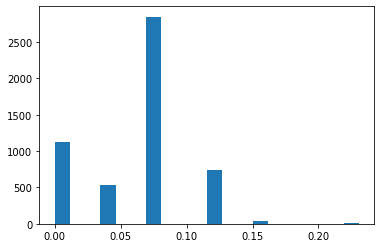

In [49]:
# plotting the null percents to visually see # of recipes
plt.figure()
plt.hist(scraped_recipes['pct_nulls'], bins=20)
plt.show()

Upon further investigation into the nulls, there seems to be about 1250 recipes that have 4% missing data and about 100 recipes with 8% missing data and a select few with over 10% of data missing.

We will address `recipe_id` next since there is only 1 missing value, followed by `category` and `author` which have 2 nulls.

In [50]:
# reset index to get updated row indices

scraped_recipes.reset_index(drop=True, inplace=True)

In [51]:
# find the recipe_id for the recipe with missing recipe_id

scraped_recipes[scraped_recipes['recipe_id'].isna()].T

4457
recipe_id                                                     NaN
recipe_name                                 Colorful Corn Chowder
url                       https://www.allrecipes.com/recipe/13013
category                                   Soups, Stews and Chili
sub_category                                             Chowders
author                                                     MARGOC
rating                                                       4.27
rating_5                                                       69
rating_4                                                       45
rating_3                                                       13
rating_2                                                        5
rating_1                                                        3
rating_counts                                                 135
review_counts                                                 135
prep_time                                                      10
cook_time                                                      25
total_time                                                     35
servings                                                      NaN
yields                                                         10
calories                                                      192
fat_g                                                         8.5
cholesterol_mg                                                 25
carbs_g                                                        25
sodium_mg                                                     566
protein_g                                                     6.6
image_link      https://imagesvc.meredithcorp.io/v3/mm/image?u...
pct_nulls                                               0.0769231

The missing `recipe_id` value seems to have all other values so we can fill this with the recipe id found in the url, which is 13013.

In [52]:
# fill recipe_id nan

scraped_recipes.iloc[4457,0] = 13013

In [53]:
# recheck nulls

scraped_recipes.isnull().sum()

recipe_id            0
recipe_name          0
url                  0
category             2
sub_category        43
author               2
rating              16
rating_5             0
rating_4             0
rating_3             0
rating_2             0
rating_1             0
rating_counts       16
review_counts      175
prep_time            0
cook_time         3561
total_time        3601
servings           732
yields               0
calories             0
fat_g                0
cholesterol_mg       0
carbs_g              0
sodium_mg            0
protein_g            0
image_link         528
pct_nulls            0
dtype: int64

Next, we will look at the nulls in `category` and `author`.

In [54]:
# check where category is missing values

scraped_recipes[scraped_recipes['category'].isna()].T

4186  \
recipe_id                                                   12480   
recipe_name                                     Cajun Sweet Dough   
url                       https://www.allrecipes.com/recipe/12480   
category                                                      NaN   
sub_category                                                  NaN   
author                                                   Julie P.   
rating                                                       4.41   
rating_5                                                       36   
rating_4                                                        6   
rating_3                                                        5   
rating_2                                                        2   
rating_1                                                        2   
rating_counts                                                  51   
review_counts                                                  51   
prep_time                                                      15   
cook_time                                                      15   
total_time                                                     30   
servings                                                       30   
yields                                         30 turnover crusts   
calories                                                      162   
fat_g                                                           5   
cholesterol_mg                                                 19   
carbs_g                                                      26.8   
sodium_mg                                                     119   
protein_g                                                     2.5   
image_link      https://imagesvc.meredithcorp.io/v3/mm/image?u...   
pct_nulls                                               0.0769231   

                                                             4869  
recipe_id                                                   15140  
recipe_name                                   Eggless Puff Pastry  
url                       https://www.allrecipes.com/recipe/15140  
category                                                      NaN  
sub_category                                                  NaN  
author                                                   phaylock  
rating                                                       4.55  
rating_5                                                       62  
rating_4                                                       14  
rating_3                                                        6  
rating_2                                                        3  
rating_1                                                        1  
rating_counts                                                  86  
review_counts                                                  86  
prep_time                                                       8  
cook_time                                                     NaN  
total_time                                                    NaN  
servings                                                        8  
yields                                                1 pie shell  
calories                                                      320  
fat_g                                                        26.3  
cholesterol_mg                                                 67  
carbs_g                                                      18.5  
sodium_mg                                                     172  
protein_g                                                     3.1  
image_link      https://imagesvc.meredithcorp.io/v3/mm/image?u...  
pct_nulls                                                0.153846

Looking at the websites for both of these recipes, there is actually no category but all the other values are accurate, so we will just make the category here as `other`.

In [55]:
# fill nans in category column

scraped_recipes.iloc[4186,3] = 'other'
scraped_recipes.iloc[4869,3] = 'other'

In [56]:
# check where author is missing values

scraped_recipes[scraped_recipes['author'].isna()].T

1426  \
recipe_id                                                    9188   
recipe_name                              Pumpkin Pecan Cheesecake   
url                        https://www.allrecipes.com/recipe/9188   
category                                    Fruits and Vegetables   
sub_category                                           Vegetables   
author                                                        NaN   
rating                                                       4.73   
rating_5                                                       87   
rating_4                                                       20   
rating_3                                                        3   
rating_2                                                        0   
rating_1                                                        1   
rating_counts                                                 111   
review_counts                                                 111   
prep_time                                                      15   
cook_time                                                      45   
total_time                                                     60   
servings                                                      NaN   
yields                                                         10   
calories                                                      340   
fat_g                                                        20.3   
cholesterol_mg                                                 68   
carbs_g                                                      36.8   
sodium_mg                                                     221   
protein_g                                                     4.5   
image_link      https://imagesvc.meredithcorp.io/v3/mm/image?u...   
pct_nulls                                               0.0769231   

                                                             4805  
recipe_id                                                   14977  
recipe_name                                   Cheesecake Cupcakes  
url                       https://www.allrecipes.com/recipe/14977  
category                                                 Desserts  
sub_category                                                Cakes  
author                                                        NaN  
rating                                                       3.87  
rating_5                                                       80  
rating_4                                                       64  
rating_3                                                       12  
rating_2                                                        7  
rating_1                                                       26  
rating_counts                                                 189  
review_counts                                                 189  
prep_time                                                      18  
cook_time                                                     NaN  
total_time                                                    NaN  
servings                                                       18  
yields                                                18 cupcakes  
calories                                                      265  
fat_g                                                          17  
cholesterol_mg                                                 98  
carbs_g                                                      23.9  
sodium_mg                                                     137  
protein_g                                                       5  
image_link      https://imagesvc.meredithcorp.io/v3/mm/image?u...  
pct_nulls                                                0.115385

I have found the author's through the URL's and will use that to impute author for recipe 9188 as Eleanor Johnson and author for recipe 14977 as 'other' since there is no author identified.

In [57]:
# fill nulls for author column

scraped_recipes.iloc[1426,5] = 'Eleanor Johnson'
scraped_recipes.iloc[4805,5] = 'other'

Now that there are no more missing values in the `author` column, we can check to see how many unique values there are to see on average how many recipes each author has. 

In [58]:
# number of recipes
len(scraped_recipes)

5291

In [59]:
# number of authors
len(scraped_recipes['author'].unique())

2544

It looks like the recipes to author ratio is about 2:1, which won't offer us much value considering we won't be able to draw inferences from a customer enjoying recipes from particular authors. For this, we will drop the author column.

In [60]:
# drop author column
scraped_recipes.drop('author', axis=1, inplace=True)

In [61]:
# recheck nulls

scraped_recipes.isnull().sum()

recipe_id            0
recipe_name          0
url                  0
category             0
sub_category        43
rating              16
rating_5             0
rating_4             0
rating_3             0
rating_2             0
rating_1             0
rating_counts       16
review_counts      175
prep_time            0
cook_time         3561
total_time        3601
servings           732
yields               0
calories             0
fat_g                0
cholesterol_mg       0
carbs_g              0
sodium_mg            0
protein_g            0
image_link         528
pct_nulls            0
dtype: int64

Based on initial intuition from scraping and also from filling in the nulls and relooking at some recipes, it appears that `rating_counts` and `review_counts` are very similar. We will check this to be sure, and if so, we will drop `rating_counts` as it contains nulls.

In [62]:
# number of recipes left
len(scraped_recipes)

5291

In [63]:
# check if `rating_counts` values are same as `review_counts` values

(scraped_recipes['rating_counts'] == scraped_recipes['review_counts']).sum()

5116

it appears out of the 5291 recipes left in the DataFrame, 5116 recipes have the same values for `rating_counts` and `review_counts` so we will drop `review_counts` to avoid redundancy, as that column has more nulls.

In [64]:
# drop review_counts column

scraped_recipes.drop('review_counts', axis=1, inplace=True)

In [65]:
# recheck nulls

scraped_recipes.isnull().sum()

recipe_id            0
recipe_name          0
url                  0
category             0
sub_category        43
rating              16
rating_5             0
rating_4             0
rating_3             0
rating_2             0
rating_1             0
rating_counts       16
prep_time            0
cook_time         3561
total_time        3601
servings           732
yields               0
calories             0
fat_g                0
cholesterol_mg       0
carbs_g              0
sodium_mg            0
protein_g            0
image_link         528
pct_nulls            0
dtype: int64

We will look at `sub_category` next. My initial belief is that these recipes don't have a subcategory. 

In [66]:
# check recipes where sub_category is missing values

scraped_recipes[scraped_recipes['sub_category'].isna()]

recipe_id                                 recipe_name  \
28       7032.0  Chinese Steamed Buns with BBQ Pork Filling   
96       7106.0                                Essene Bread   
182      7196.0                                     Lefse I   
200      7218.0                                 Rye Starter   
201      7219.0                          Wild Grape Starter   
1360     9074.0               Baked Pineapple with Crackers   
1437     9205.0                           Scalloped Oysters   
1446     9218.0                Sweet Potato Balls Appetizer   
1518     9309.0                  Water Chestnut Wraparounds   
1561     9387.0                              Italian Butter   
1633     9553.0                                       Puffs   
2192    10132.0     Beverly's Get Up & Go Breakfast Cookies   
2249    10200.0                                     Kolacky   
2527    10488.0                    Hearty Breakfast Cookies   
2721    10685.0                                   Empanadas   
2980    10946.0                        Chewy Breakfast Bars   
3271    11257.0                               Quick Kolacky   
3339    11327.0                           Ice Cream Kolacky   
3659    11666.0                      Mediterranean Farfalle   
3669    11684.0          Pasta with Blue Cheese and Walnuts   
3671    11687.0                     Pasta with Yogurt Sauce   
3681    11713.0                            The Cheese Thing   
3690    11725.0                             Pineapple Kugel   
3699    11741.0                      Poppy Seed Spaghettini   
3708    11759.0                             Noodles Alfredo   
3739    11835.0                       Peanut Butter Noodles   
3747    11853.0                Orzo with Parmesan and Basil   
3748    11855.0                           Lemon Pasta Sauce   
3755    11868.0                                 Onion Pasta   
3763    11884.0                          Garlic Spaghetti I   
3781    11929.0                  Hungarian Noodle Side Dish   
3795    11963.0                      Spaghetti with a Twist   
3823    12031.0                       Noodles a la Pakistan   
3831    12050.0          Pasta with Fresh Tomatoes and Corn   
3835    12058.0                       Pasta with Sweet Peas   
3838    12062.0                         Noodles Romanoff II   
4186    12480.0                           Cajun Sweet Dough   
4632    14295.0                           Seven Layer Salad   
4651    14521.0                          Asian Beef Skewers   
4663    14581.0                           Marinated Veggies   
4665    14606.0       Beef Tenderloin With Roasted Shallots   
4869    15140.0                         Eggless Puff Pastry   
5101    15621.0                               Maurice Salad   

                                          url               category  \
28     https://www.allrecipes.com/recipe/7032                  Bread   
96     https://www.allrecipes.com/recipe/7106                  Bread   
182    https://www.allrecipes.com/recipe/7196                  Bread   
200    https://www.allrecipes.com/recipe/7218                  Bread   
201    https://www.allrecipes.com/recipe/7219                  Bread   
1360   https://www.allrecipes.com/recipe/9074              Side Dish   
1437   https://www.allrecipes.com/recipe/9205              Side Dish   
1446   https://www.allrecipes.com/recipe/9218  Appetizers and Snacks   
1518   https://www.allrecipes.com/recipe/9309  Appetizers and Snacks   
1561   https://www.allrecipes.com/recipe/9387  Appetizers and Snacks   
1633   https://www.allrecipes.com/recipe/9553  Appetizers and Snacks   
2192  https://www.allrecipes.com/recipe/10132   Breakfast and Brunch   
2249  https://www.allrecipes.com/recipe/10200                  Bread   
2527  https://www.allrecipes.com/recipe/10488   Breakfast and Brunch   
2721  https://www.allrecipes.com/recipe/10685                  Bread   
2980  https://www.allrecipes.com/recipe/10946   Breakfast and Brunch   
3271  htt

In [67]:
# seeing the common categories without subcategories

scraped_recipes[scraped_recipes['sub_category'].isna()]['category'].unique()

array(['Bread', 'Side Dish', 'Appetizers and Snacks',
       'Breakfast and Brunch', 'other', 'Salad', 'Everyday Cooking'],
      dtype=object)

After looking at the few recipes from each of the categories without subcategories, it appears my initial intuition was correct and that these recipes do not have subcategories. In this case, I will make the `sub_category` value equal to the `category` value. 

In [68]:
# fill missing sub_category values with category value

scraped_recipes['sub_category'].fillna(scraped_recipes['category'], inplace=True)

In [69]:
# recheck nulls

scraped_recipes.isnull().sum()

recipe_id            0
recipe_name          0
url                  0
category             0
sub_category         0
rating              16
rating_5             0
rating_4             0
rating_3             0
rating_2             0
rating_1             0
rating_counts       16
prep_time            0
cook_time         3561
total_time        3601
servings           732
yields               0
calories             0
fat_g                0
cholesterol_mg       0
carbs_g              0
sodium_mg            0
protein_g            0
image_link         528
pct_nulls            0
dtype: int64

Next, we will impute the missing `rating_counts` values with the sum of the rating tallies from 1 to 5, as that will give us the best estimate of total number of rating counts instead of imputing by mean or median.

In [70]:
# sum up the rating columns 1 to 5

sum_rating = scraped_recipes['rating_5'] + scraped_recipes['rating_4'] + scraped_recipes['rating_3'] +\
scraped_recipes['rating_2'] + scraped_recipes['rating_1']

In [71]:
# check if sum of the rating tallies equals the rating counts

(sum_rating == scraped_recipes['rating_counts']).sum()

5275

In [72]:
# number of recipes 

len(scraped_recipes)

5291

Out of 5291 recipes left in the dataset, 5275 of them are true where the sum of the individual score counts equals the total rating counts. There are 16 that are not equal, which presumably are the nulls, however we will check again after filling the nulls. We will go ahead with filling the missing rating count values with the sum.

In [73]:
# fill rating_count nulls

scraped_recipes['rating_counts'].fillna(sum_rating, inplace=True)

In [74]:
# recheck nulls

scraped_recipes.isnull().sum()

recipe_id            0
recipe_name          0
url                  0
category             0
sub_category         0
rating              16
rating_5             0
rating_4             0
rating_3             0
rating_2             0
rating_1             0
rating_counts        0
prep_time            0
cook_time         3561
total_time        3601
servings           732
yields               0
calories             0
fat_g                0
cholesterol_mg       0
carbs_g              0
sodium_mg            0
protein_g            0
image_link         528
pct_nulls            0
dtype: int64

In [75]:
# check if sum of the rating tallies equals the rating counts

(sum_rating == scraped_recipes['rating_counts']).all()

True

It appears after filling in the nulls in `rating_counts` column, the summation of the individual rating counts all equal the total count. 

Next, we will impute the missing `rating` values with the average of the rating tallies (ratings 1 to 5).

In [76]:
# totalling all scores by their value

sum_score = scraped_recipes['rating_5'] * 5 + scraped_recipes['rating_4'] * 4 + scraped_recipes['rating_3'] * 3 +\
    scraped_recipes['rating_2'] * 2 + scraped_recipes['rating_1']

# taking average 
avg_score = sum_score / sum_rating

In [77]:
# confirm average score looks valid
avg_score

0       4.574307
1       4.788177
2       4.750000
3       4.381295
4       4.285714
          ...   
5286    4.333333
5287    4.647709
5288    4.780358
5289    4.142857
5290    3.285714
Length: 5291, dtype: float64

In [78]:
# fill na of rating column with avg_score

scraped_recipes['rating'].fillna(avg_score, inplace=True)

In [79]:
# recheck nulls

scraped_recipes.isnull().sum()

recipe_id            0
recipe_name          0
url                  0
category             0
sub_category         0
rating              16
rating_5             0
rating_4             0
rating_3             0
rating_2             0
rating_1             0
rating_counts        0
prep_time            0
cook_time         3561
total_time        3601
servings           732
yields               0
calories             0
fat_g                0
cholesterol_mg       0
carbs_g              0
sodium_mg            0
protein_g            0
image_link         528
pct_nulls            0
dtype: int64

For some reason, the nulls still exist in the `rating` column. We will have to take a further look as to why.

In [80]:
# show recipes where rating is na

scraped_recipes[scraped_recipes['rating'].isna()]

recipe_id                               recipe_name  \
667      7746.0                               Pousse Cafe   
723      7812.0  Orange Party Cake with Chocolate Coating   
761      7853.0                               Simnel Cake   
1693     9621.0         Frosted Chocolate Coconut Goodies   
1810     9739.0                          Icebox Cookies I   
1813     9742.0                     Old Fashioned Wreaths   
2319    10272.0                            Zucker Hutchen   
2358    10311.0                                 Listy III   
2604    10567.0                            Fruit Drops II   
2836    10801.0                 Blue Ribbon Fruit Cookies   
2864    10829.0                         Italian Egg Dough   
3100    11069.0              Cookies with Chocbit Topping   
3260    11245.0                         Half Moon Cookies   
3557    11560.0                   Rosie's Raisin Rhapsody   
3964    12217.0                      Crunchy Caramel Tart   
4928    15270.0                           Fruit Meringues   

                                          url       category    sub_category  \
667    https://www.allrecipes.com/recipe/7746       Desserts           Cakes   
723    https://www.allrecipes.com/recipe/7812       Desserts       Chocolate   
761    https://www.allrecipes.com/recipe/7853       Desserts           Cakes   
1693   https://www.allrecipes.com/recipe/9621       Desserts         Cookies   
1810   https://www.allrecipes.com/recipe/9739       Desserts         Cookies   
1813   https://www.allrecipes.com/recipe/9742       Desserts         Cookies   
2319  https://www.allrecipes.com/recipe/10272  World Cuisine        European   
2358  https://www.allrecipes.com/recipe/10311  World Cuisine        European   
2604  https://www.allrecipes.com/recipe/10567       Desserts         Cookies   
2836  https://www.allrecipes.com/recipe/10801       Desserts         Cookies   
2864  https://www.allrecipes.com/recipe/10829  World Cuisine        European   
3100  https://www.allrecipes.com/recipe/11069       Desserts         Cookies   
3260  https://www.allrecipes.com/recipe/11245       Desserts         Cookies   
3557  https://www.allrecipes.com/recipe/11560       Desserts         Cookies   
3964  https://www.allrecipes.com/recipe/12217       Desserts            Pies   
4928  https://www.allrecipes.com/recipe/15270       Desserts  Fruit Desserts   

      rating  rating_5  rating_4  rating_3  rating_2  ...  servings  \
667      NaN       0.0       0.0       0.0       0.0  ...      12.0   
723      NaN       0.0       0.0       0.0       0.0  ...      10.0   
761      NaN       0.0       0.0       0.0       0.0  ...      14.0   
1693     NaN       0.0       0.0       0.0       0.0  ...      24.0   
1810     NaN       0.0       0.0       0.0       0.0  ...      36.0   
1813     NaN       0.0       0.0       0.0       0.0  ...      84.0   
2319     NaN       0.0       0.0       0.0       0.0  ...      30.0   
2358     NaN       0.0       0.0       0.0       0.0  ...      24.0   
2604     NaN       0.0       0.0       0.0       0.0  ...      60.0   
2836     NaN       0.0       0.0       0.0       0.0  ...      48.0   
2864     NaN       0.0       0.0       0.0       0.0  ...      12.0   
3100     NaN       0.0       0.0       0.0       0.0  ...       4.0   
3260     NaN       0.0       0.0       0.0       0.0  ...      20.0   
3557     NaN       0.0       0.0       0.0       0.0  ...      30.0   
3964     NaN       0.0       0.0       0.0       0.0  ...      24.0   
4928     NaN       0.0       0.0       0.0       0.0  ...      18.0   

                          yields  calories  fat_g  cholesterol_mg  carbs_g  \
667   1 fluted 2 quart ring mold     500.0   31.2           108.0     48.8   
723        1 - 8 inch layer cake     578.0   33.5           108.0     65.7   
761           1 -9 inch tube pan     314.0   11.6            79.0     50.3   
1693                     4 dozen     158.0    5.4            24.0     25.8   
1810     

It looks like the ratings with nulls have 0 ratings given. We will check to see if this is beyond just the rows with `rating` values missing. If so, we will impute 0 for ratings with missing values.

In [81]:
# show recipes where rating counts equal 0

scraped_recipes[scraped_recipes['rating_counts'] == 0]

recipe_id                               recipe_name  \
667      7746.0                               Pousse Cafe   
723      7812.0  Orange Party Cake with Chocolate Coating   
761      7853.0                               Simnel Cake   
1693     9621.0         Frosted Chocolate Coconut Goodies   
1810     9739.0                          Icebox Cookies I   
1813     9742.0                     Old Fashioned Wreaths   
2319    10272.0                            Zucker Hutchen   
2358    10311.0                                 Listy III   
2604    10567.0                            Fruit Drops II   
2836    10801.0                 Blue Ribbon Fruit Cookies   
2864    10829.0                         Italian Egg Dough   
3100    11069.0              Cookies with Chocbit Topping   
3260    11245.0                         Half Moon Cookies   
3557    11560.0                   Rosie's Raisin Rhapsody   
3964    12217.0                      Crunchy Caramel Tart   
4928    15270.0                           Fruit Meringues   

                                          url       category    sub_category  \
667    https://www.allrecipes.com/recipe/7746       Desserts           Cakes   
723    https://www.allrecipes.com/recipe/7812       Desserts       Chocolate   
761    https://www.allrecipes.com/recipe/7853       Desserts           Cakes   
1693   https://www.allrecipes.com/recipe/9621       Desserts         Cookies   
1810   https://www.allrecipes.com/recipe/9739       Desserts         Cookies   
1813   https://www.allrecipes.com/recipe/9742       Desserts         Cookies   
2319  https://www.allrecipes.com/recipe/10272  World Cuisine        European   
2358  https://www.allrecipes.com/recipe/10311  World Cuisine        European   
2604  https://www.allrecipes.com/recipe/10567       Desserts         Cookies   
2836  https://www.allrecipes.com/recipe/10801       Desserts         Cookies   
2864  https://www.allrecipes.com/recipe/10829  World Cuisine        European   
3100  https://www.allrecipes.com/recipe/11069       Desserts         Cookies   
3260  https://www.allrecipes.com/recipe/11245       Desserts         Cookies   
3557  https://www.allrecipes.com/recipe/11560       Desserts         Cookies   
3964  https://www.allrecipes.com/recipe/12217       Desserts            Pies   
4928  https://www.allrecipes.com/recipe/15270       Desserts  Fruit Desserts   

      rating  rating_5  rating_4  rating_3  rating_2  ...  servings  \
667      NaN       0.0       0.0       0.0       0.0  ...      12.0   
723      NaN       0.0       0.0       0.0       0.0  ...      10.0   
761      NaN       0.0       0.0       0.0       0.0  ...      14.0   
1693     NaN       0.0       0.0       0.0       0.0  ...      24.0   
1810     NaN       0.0       0.0       0.0       0.0  ...      36.0   
1813     NaN       0.0       0.0       0.0       0.0  ...      84.0   
2319     NaN       0.0       0.0       0.0       0.0  ...      30.0   
2358     NaN       0.0       0.0       0.0       0.0  ...      24.0   
2604     NaN       0.0       0.0       0.0       0.0  ...      60.0   
2836     NaN       0.0       0.0       0.0       0.0  ...      48.0   
2864     NaN       0.0       0.0       0.0       0.0  ...      12.0   
3100     NaN       0.0       0.0       0.0       0.0  ...       4.0   
3260     NaN       0.0       0.0       0.0       0.0  ...      20.0   
3557     NaN       0.0       0.0       0.0       0.0  ...      30.0   
3964     NaN       0.0       0.0       0.0       0.0  ...      24.0   
4928     NaN       0.0       0.0       0.0       0.0  ...      18.0   

                          yields  calories  fat_g  cholesterol_mg  carbs_g  \
667   1 fluted 2 quart ring mold     500.0   31.2           108.0     48.8   
723        1 - 8 inch layer cake     578.0   33.5           108.0     65.7   
761           1 -9 inch tube pan     314.0   11.6            79.0     50.3   
1693                     4 dozen     158.0    5.4            24.0     25.8   
1810     

It does appear that the `rating` values that are missing is due to the recipe actually not having any ratings yet. In this case, we will impute 0 for the missing values.

In [82]:
# fill missing ratings with 0

scraped_recipes['rating'].fillna(0, inplace=True)

In [83]:
# recheck nulls

scraped_recipes.isnull().sum()

recipe_id            0
recipe_name          0
url                  0
category             0
sub_category         0
rating               0
rating_5             0
rating_4             0
rating_3             0
rating_2             0
rating_1             0
rating_counts        0
prep_time            0
cook_time         3561
total_time        3601
servings           732
yields               0
calories             0
fat_g                0
cholesterol_mg       0
carbs_g              0
sodium_mg            0
protein_g            0
image_link         528
pct_nulls            0
dtype: int64

This leaves just `servings` column left with missing values. We can disregard `image_link` because this is for a bonus section to display the food image in the recommender. 

In [84]:
# check recipes where servings is null

scraped_recipes[scraped_recipes['servings'].isna()]

recipe_id                          recipe_name  \
116      7126.0                         Pain Perdu I   
163      7174.0                   Navajo Fry Bread I   
167      7179.0                             Beignets   
178      7192.0              Real Southern Cornbread   
179      7193.0                        Herb Biscuits   
...         ...                                  ...   
5240    15917.0             Fudge Truffle Cheesecake   
5241    15925.0            Creamy Au Gratin Potatoes   
5242    15931.0                         Hoppin' John   
5243    15932.0                  Berry Valentine Pie   
5272    15970.0  Pumpkin Cheesecake with Pecan Crust   

                                          url               category  \
116    https://www.allrecipes.com/recipe/7126   Breakfast and Brunch   
163    https://www.allrecipes.com/recipe/7174   Breakfast and Brunch   
167    https://www.allrecipes.com/recipe/7179                  Bread   
178    https://www.allrecipes.com/recipe/7192                  Bread   
179    https://www.allrecipes.com/recipe/7193                  Bread   
...                                       ...                    ...   
5240  https://www.allrecipes.com/recipe/15917               Desserts   
5241  https://www.allrecipes.com/recipe/15925              Side Dish   
5242  https://www.allrecipes.com/recipe/15931       Meat and Poultry   
5243  https://www.allrecipes.com/recipe/15932               Desserts   
5272  https://www.allrecipes.com/recipe/15970  Fruits and Vegetables   

         sub_category  rating  rating_5  rating_4  rating_3  rating_2  ...  \
116      French Toast    3.58       4.0       2.0       4.0       1.0  ...   
163   Breakfast Bread    2.68       6.0       1.0       1.0       3.0  ...   
167       Yeast Bread    4.65     239.0      40.0      13.0       8.0  ...   
178       Quick Bread    4.00      77.0      32.0      11.0       9.0  ...   
179       Quick Bread    4.43      71.0      44.0       6.0       1.0  ...   
...               ...     ...       ...       ...       ...       ...  ...   
5240            Cakes    4.75     365.0      63.0      15.0       3.0  ...   
5241         Potatoes    4.54    3807.0    1377.0     329.0     102.0  ...   
5242             Pork    4.22     116.0      77.0      24.0      11.0  ...   
5243             Pies    3.40       3.0       0.0       0.0       0.0  ...   
5272       Vegetables    4.76      52.0       7.0       4.0       0.0  ...   

      servings  yields  calories  fat_g  cholesterol_mg  carbs_g sodium_mg  \
116        NaN       4     360.0   19.1           109.0     39.1     274.0   
163        NaN       8     543.0   34.2            35.0     47.0    1069.0   
167        NaN      10     543.0   17.7            45.0     82.7     277.0   
178        NaN      12     369.0   22.0            34.0     36.3     621.0   
179        NaN       8     238.0   17.2            31.0     18.4     502.0   
...        ...     ...       ...    ...             ...      ...       ...   
5240       NaN      14     552.0   35.9           127.0     51.4     288.0   
5241       NaN       4     499.0   25.4            77.0     49.3     683.0   
5242       NaN       6     475.0    9.3            61.0     64.1     619.0   
5243       NaN       7     519.0   26.8            64.0     68.9     309.0   
5272       NaN      15     562.0   37.5            66.0     53.6     492.0   

      protein_g                                         image_link  pct_nulls  
116         8.1  https://imagesvc.meredithcorp.io/v3/mm/image?u...   0.115385  
163        10.7  https://imagesvc.meredithcorp.io/v3/mm/image?u...   0.115385  
167        12.4  https://imagesvc.meredithcorp.io/v3/mm/image?u...   0.038462  
178         7.7  https://imagesvc.meredithcorp.io/v3/mm/image?u...   0.038462  
179         3.0  https://imagesvc.meredithcorp.io/v3/mm/image?u...   0.038462  
...         ...                                                ...        ...  
5240       10.6  https://imagesvc.

Since `yields` has no missing values, we will impute the missing values in the `servings` column with values from `yields` column. This is under the assumption that yields is very similar to servings and also best estimate to account for missing `servings` values. To avoid imputing strings, we will first split the values to only the numerical numbers. 

In [85]:
# split yields column to only the numeric values before the white space

scraped_recipes['yields'] = scraped_recipes['yields'].str.split(' ', expand=True)

In [86]:
# convert yields column to float to confirm that all values are floats

scraped_recipes['yields'].astype(float)

0       20.0
1        2.0
2        2.0
3        2.0
4        5.0
        ... 
5286     1.0
5287     1.0
5288     4.0
5289     1.0
5290     1.0
Name: yields, Length: 5291, dtype: float64

In [87]:
# fill missing servings values with yields values

scraped_recipes['servings'].fillna(scraped_recipes['yields'], inplace=True)

In [88]:
# recheck nulls

scraped_recipes.isnull().sum()

recipe_id            0
recipe_name          0
url                  0
category             0
sub_category         0
rating               0
rating_5             0
rating_4             0
rating_3             0
rating_2             0
rating_1             0
rating_counts        0
prep_time            0
cook_time         3561
total_time        3601
servings             0
yields               0
calories             0
fat_g                0
cholesterol_mg       0
carbs_g              0
sodium_mg            0
protein_g            0
image_link         528
pct_nulls            0
dtype: int64

It appears now all the columns have no more missing values. Again, except for `image_link` which we may or may not use later on. If I do decide to use this column, I will determine if I will display empty images for these recipes or impute it some other way. For modeling purposes, we have all the needed columns cleaned up. 

Next, we can drop the `pct_null` column.

In [89]:
# drop pct_nulls column
scraped_recipes.drop('pct_nulls', axis=1, inplace=True)
scraped_recipes.columns

Index(['recipe_id', 'recipe_name', 'url', 'category', 'sub_category', 'rating',
       'rating_5', 'rating_4', 'rating_3', 'rating_2', 'rating_1',
       'rating_counts', 'prep_time', 'cook_time', 'total_time', 'servings',
       'yields', 'calories', 'fat_g', 'cholesterol_mg', 'carbs_g', 'sodium_mg',
       'protein_g', 'image_link'],
      dtype='object')

Before looking into the recipe dataset from Kaggle, we will save the scraped recipe dataset to a new csv.

In [64]:
# save cleaned dataset to csv

scraped_recipes.to_csv('scraped_recipes_clean.csv', index=False)

In [90]:
# check if save was successful

pd.read_csv('scraped_recipes_clean.csv')

recipe_id                  recipe_name  \
0        7000.0        Golden Crescent Rolls   
1        7001.0  Poppy Seed Bread with Glaze   
2        7002.0        Czech Christmas Hoska   
3        7003.0           Applesauce Bread I   
4        7004.0           Raisin Brown Bread   
...         ...                          ...   
5286    15992.0            Ho Ho Ho Rum Cake   
5287    15994.0  Chocolate Bourbon Pecan Pie   
5288    15995.0   Ruth's Grandma's Pie Crust   
5289    15996.0       French Apple Cream Pie   
5290    15997.0                Sugar Pie III   

                                          url              category  \
0      https://www.allrecipes.com/recipe/7000                 Bread   
1      https://www.allrecipes.com/recipe/7001  Breakfast and Brunch   
2      https://www.allrecipes.com/recipe/7002                 Bread   
3      https://www.allrecipes.com/recipe/7003  Breakfast and Brunch   
4      https://www.allrecipes.com/recipe/7004  Breakfast and Brunch   
...                                       ...                   ...   
5286  https://www.allrecipes.com/recipe/15992              Desserts   
5287  https://www.allrecipes.com/recipe/15994              Desserts   
5288  https://www.allrecipes.com/recipe/15995              Desserts   
5289  https://www.allrecipes.com/recipe/15996              Desserts   
5290  https://www.allrecipes.com/recipe/15997              Desserts   

            sub_category             author  rating  rating_5  rating_4  \
0            Yeast Bread            Mike A.    4.57     279.0      85.0   
1        Breakfast Bread      Christina Jun    4.79     174.0      19.0   
2            Yeast Bread  Carol Ponec-Nemec    4.75      15.0       5.0   
3        Breakfast Bread              GAF55    4.38      77.0      43.0   
4        Breakfast Bread               Tina    4.29       4.0       1.0   
...                  ...                ...     ...       ...       ...   
5286  Specialty Desserts              Carol    4.33       1.0       2.0   
5287                Pies             ANITAL    4.65     483.0     102.0   
5288                Pies   barbara castodio    4.78    1321.0     103.0   
5289                Pies    Mary Ann Benzon    4.14       4.0       1.0   
5290                Pies    Phyllis Bartlow    3.29       3.0       0.0   

      rating_3  ...  rating_counts  servings  yields  calories  fat_g  \
0         18.0  ...          397.0      20.0    20.0     181.0    7.7   
1          7.0  ...          203.0      24.0     2.0     302.0   13.8   
2          0.0  ...           20.0      30.0     2.0     177.0    4.9   
3         15.0  ...          139.0      24.0     2.0     251.0   11.0   
4          2.0  ...            7.0      60.0     5.0      40.0    0.6   
...        ...  ...            ...       ...     ...       ...    ...   
5286       0.0  ...            3.0      14.0     1.0     456.0   22.2   
5287      31.0  ...          633.0       8.0     1.0     647.0   35.4   
5288      42.0  ...         1507.0      32.0     4.0     163.0   11.5   
5289       1.0  ...            7.0       8.0     1.0     398.0   20.9   
5290       1.0  ...            7.0       6.0     1.0     492.0   20.3   

      cholesterol_mg  carbs_g  sodium_mg  protein_g  \
0               37.0     24.4      173.0        3.6   
1               24.0     42.0      192.0        3.1   
2               22.0     29.4      110.0        4.0   
3               25.0     36.7       70.0        2.8   
4                0.0      8.8      158.0        0.4   
...              ...      ...        ...        ...   
5286            54.0     56.8      424.0        4.1   
5287           124.0     79.9      320.0        6.1   
5288             6.0     13.1      148.0        1.8   
5289            38.0     49.3      311.0        4.7   
5290            54.0     77.8      138.0        1.9   

                                             image_link  
0     https://imagesvc.meredithcorp.io/v3/mm/image?u...  
1     https://imagesv

Next, we will join the Kaggle dataset to our scraped recipes dataset, so that we can have the following columns:
`recipe_id`, `recipe_name`, `url`, `category`, `sub_category`, `rating`, `rating_5`, `rating_4`, `rating_3`, `rating_2`, `rating_1`, `rating_counts`, `servings`, `yields`, `calories`, `fat_g`, `cholesterol_mg`, `carbs_g`, `sodium_mg`, `protein_g`, `image_link`, `prep_time`, `cook_time`, `total_time`.

Additionally, we will address the missing values in the timing columns.

In [338]:
# number of recipes in cleaned scraped recipes dataset
len(scraped_recipes)

5291

In [337]:
# join scraped_recipes with recipes_df from Kaggle

full_recipe_df = pd.merge(scraped_recipes, recipe_df, how='left', on='recipe_id')
full_recipe_df

recipe_id                recipe_name_x  \
0        7000.0        Golden Crescent Rolls   
1        7001.0  Poppy Seed Bread with Glaze   
2        7002.0        Czech Christmas Hoska   
3        7003.0           Applesauce Bread I   
4        7004.0           Raisin Brown Bread   
...         ...                          ...   
5286    15992.0            Ho Ho Ho Rum Cake   
5287    15994.0  Chocolate Bourbon Pecan Pie   
5288    15995.0   Ruth's Grandma's Pie Crust   
5289    15996.0       French Apple Cream Pie   
5290    15997.0                Sugar Pie III   

                                          url              category  \
0      https://www.allrecipes.com/recipe/7000                 Bread   
1      https://www.allrecipes.com/recipe/7001  Breakfast and Brunch   
2      https://www.allrecipes.com/recipe/7002                 Bread   
3      https://www.allrecipes.com/recipe/7003  Breakfast and Brunch   
4      https://www.allrecipes.com/recipe/7004  Breakfast and Brunch   
...                                       ...                   ...   
5286  https://www.allrecipes.com/recipe/15992              Desserts   
5287  https://www.allrecipes.com/recipe/15994              Desserts   
5288  https://www.allrecipes.com/recipe/15995              Desserts   
5289  https://www.allrecipes.com/recipe/15996              Desserts   
5290  https://www.allrecipes.com/recipe/15997              Desserts   

            sub_category  rating  rating_5  rating_4  rating_3  rating_2  ...  \
0            Yeast Bread    4.57     279.0      85.0      18.0      12.0  ...   
1        Breakfast Bread    4.79     174.0      19.0       7.0       2.0  ...   
2            Yeast Bread    4.75      15.0       5.0       0.0       0.0  ...   
3        Breakfast Bread    4.38      77.0      43.0      15.0       3.0  ...   
4        Breakfast Bread    4.29       4.0       1.0       2.0       0.0  ...   
...                  ...     ...       ...       ...       ...       ...  ...   
5286  Specialty Desserts    4.33       1.0       2.0       0.0       0.0  ...   
5287                Pies    4.65     483.0     102.0      31.0       9.0  ...   
5288                Pies    4.78    1321.0     103.0      42.0      20.0  ...   
5289                Pies    4.14       4.0       1.0       1.0       1.0  ...   
5290                Pies    3.29       3.0       0.0       1.0       2.0  ...   

      sodium_mg  protein_g                                         image_link  \
0         173.0        3.6  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
1         192.0        3.1  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
2         110.0        4.0  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
3          70.0        2.8  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
4         158.0        0.4  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
...         ...        ...                                                ...   
5286      424.0        4.1  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
5287      320.0        6.1  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
5288      148.0        1.8  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
5289      311.0        4.7  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
5290      138.0        1.9                                                NaN   

                               recipe_name_y  num_reviews  \
0              Golden Crescent Rolls Recipe         304.0   
1        Poppy Seed Bread with Glaze Recipe         137.0   
2                                        NaN          NaN   
3                 Applesauce Bread I Recipe         124.0   
4                                        NaN          NaN   
...                                      ...          ...   
5286                                     NaN          NaN   
5287     Chocolate Bourbon Pecan Pie Recipe         469.0   
5288  'Ruth''s Grandma''s Pie Crust Recipe '       1000.0   
5289          French

Confirming merge was completed successfully, so now we will check the columns of the joined dataset.

In [339]:
# columns of full data set
full_recipe_df.columns

Index(['recipe_id', 'recipe_name_x', 'url', 'category', 'sub_category',
       'rating', 'rating_5', 'rating_4', 'rating_3', 'rating_2', 'rating_1',
       'rating_counts', 'prep_time_x', 'cook_time_x', 'total_time_x',
       'servings', 'yields', 'calories', 'fat_g', 'cholesterol_mg', 'carbs_g',
       'sodium_mg', 'protein_g', 'image_link', 'recipe_name_y', 'num_reviews',
       'image', 'prep_time_y', 'cook_time_y', 'total_time_y', 'ingredients'],
      dtype='object')

We can see there are a number of duplicate columns such as the recipe name, cooking times (for reason of imputing missing values), number of reviews (which we had established earlier would be number of ratings). For now, we will drop `recipe_name_y` and `num_reviews`.

In [341]:
# drop recipe_name_y and num_reviews columns

full_recipe_df.drop(['recipe_name_y','num_reviews'], axis=1, inplace=True)

In [342]:
# confirm columns

full_recipe_df.columns

Index(['recipe_id', 'recipe_name_x', 'url', 'category', 'sub_category',
       'rating', 'rating_5', 'rating_4', 'rating_3', 'rating_2', 'rating_1',
       'rating_counts', 'prep_time_x', 'cook_time_x', 'total_time_x',
       'servings', 'yields', 'calories', 'fat_g', 'cholesterol_mg', 'carbs_g',
       'sodium_mg', 'protein_g', 'image_link', 'image', 'prep_time_y',
       'cook_time_y', 'total_time_y', 'ingredients'],
      dtype='object')

Now, we will address the time columns and hopefully we can leverage both datasets to impute the data.

In [343]:
# check missing values

full_recipe_df.isna().sum()

recipe_id            0
recipe_name_x        0
url                  0
category             0
sub_category         0
rating               0
rating_5             0
rating_4             0
rating_3             0
rating_2             0
rating_1             0
rating_counts        0
prep_time_x          0
cook_time_x       3561
total_time_x      3601
servings             0
yields               0
calories             0
fat_g                0
cholesterol_mg       0
carbs_g              0
sodium_mg            0
protein_g            0
image_link         528
image             1428
prep_time_y       4183
cook_time_y       4183
total_time_y      4183
ingredients       1428
dtype: int64

Unfortunately, it looks like the Kaggle dataset won't be helpful as there are 4183 missing values out of the 5291 recipes we have in the combined dataset. In this case, we will drop `prep_time_y`, `cook_time_y`, `total_time_y`, along with `cook_time_x`, and `total_time_x` from the scraped dataset. It would definitely skew the data if we were to impute these values with an aggregation when there are more than 67% of the values missing. Fortunately, we can keep `prep_time_x` as there are no missing values. Depending on the results of our models and direction taken with our models, we can always alter the code to scrape for more data. For now, we will proceed with what we have.

In [344]:
# drop prep_time_y, cook_time_y, total_time_y, cook_time_x, and total_time_x
full_recipe_df.drop(['prep_time_y', 'cook_time_y', 'total_time_y', 'cook_time_x', 'total_time_x'], axis=1, inplace=True)

In [345]:
# check nulls

full_recipe_df.isna().sum()

recipe_id            0
recipe_name_x        0
url                  0
category             0
sub_category         0
rating               0
rating_5             0
rating_4             0
rating_3             0
rating_2             0
rating_1             0
rating_counts        0
prep_time_x          0
servings             0
yields               0
calories             0
fat_g                0
cholesterol_mg       0
carbs_g              0
sodium_mg            0
protein_g            0
image_link         528
image             1428
ingredients       1428
dtype: int64

Before addressing the missing values in the `ingredients` column, I will impute the values in the `image_link` column with what is available in the `image` column. After that, I will drop the `image` column to reduce redundancy.

In [351]:
# fill nulls in image_link with image values where possible
full_recipe_df['image_link'].fillna(full_recipe_df['image'], inplace=True)

In [352]:
# check nulls

full_recipe_df.isna().sum()

recipe_id            0
recipe_name_x        0
url                  0
category             0
sub_category         0
rating               0
rating_5             0
rating_4             0
rating_3             0
rating_2             0
rating_1             0
rating_counts        0
prep_time_x          0
servings             0
yields               0
calories             0
fat_g                0
cholesterol_mg       0
carbs_g              0
sodium_mg            0
protein_g            0
image_link         145
image             1428
ingredients       1428
dtype: int64

Good news is that I was able to fill more than half of the missing `image_link` values. Now I will drop `image` column and leave the remaining nulls in `image_link` column as is. Again, I will fill this information with further scraping if needed, depending on the final product.

In [353]:
# drop image column
full_recipe_df.drop('image', axis=1, inplace=True)

Next, we will address the `ingredients` column. Because the basis of my capstone is on the idea of building a recipe recommender based on ingredients in the recipes and the interrelations between the ingredients, I unfortunately cannot use the recipes that do not have this information available. For this reason, I will be dropping the rows where `ingredients` are missing values. Unfortunately, this would also reduce the number of recipes I have to about 3800.

In [354]:
# drop recipes missing ingredients
clean_recipe_df = full_recipe_df[~full_recipe_df['ingredients'].isna()]
clean_recipe_df

recipe_id                recipe_name_x  \
0        7000.0        Golden Crescent Rolls   
1        7001.0  Poppy Seed Bread with Glaze   
3        7003.0           Applesauce Bread I   
6        7006.0           Apple Raisin Bread   
7        7007.0     Buttermilk Oatmeal Bread   
...         ...                          ...   
5284    15990.0      Old Fashioned Cream Pie   
5287    15994.0  Chocolate Bourbon Pecan Pie   
5288    15995.0   Ruth's Grandma's Pie Crust   
5289    15996.0       French Apple Cream Pie   
5290    15997.0                Sugar Pie III   

                                          url              category  \
0      https://www.allrecipes.com/recipe/7000                 Bread   
1      https://www.allrecipes.com/recipe/7001  Breakfast and Brunch   
3      https://www.allrecipes.com/recipe/7003  Breakfast and Brunch   
6      https://www.allrecipes.com/recipe/7006  Breakfast and Brunch   
7      https://www.allrecipes.com/recipe/7007                 Bread   
...                                       ...                   ...   
5284  https://www.allrecipes.com/recipe/15990              Desserts   
5287  https://www.allrecipes.com/recipe/15994              Desserts   
5288  https://www.allrecipes.com/recipe/15995              Desserts   
5289  https://www.allrecipes.com/recipe/15996              Desserts   
5290  https://www.allrecipes.com/recipe/15997              Desserts   

         sub_category  rating  rating_5  rating_4  rating_3  rating_2  ...  \
0         Yeast Bread    4.57     279.0      85.0      18.0      12.0  ...   
1     Breakfast Bread    4.79     174.0      19.0       7.0       2.0  ...   
3     Breakfast Bread    4.38      77.0      43.0      15.0       3.0  ...   
6     Breakfast Bread    4.11      19.0      19.0       3.0       1.0  ...   
7         Quick Bread    4.21      28.0      20.0       5.0       4.0  ...   
...               ...     ...       ...       ...       ...       ...  ...   
5284             Pies    4.60       9.0       6.0       0.0       0.0  ...   
5287             Pies    4.65     483.0     102.0      31.0       9.0  ...   
5288             Pies    4.78    1321.0     103.0      42.0      20.0  ...   
5289             Pies    4.14       4.0       1.0       1.0       1.0  ...   
5290             Pies    3.29       3.0       0.0       1.0       2.0  ...   

      servings  yields  calories fat_g cholesterol_mg  carbs_g  sodium_mg  \
0           20      20     181.0   7.7           37.0     24.4      173.0   
1           24       2     302.0  13.8           24.0     42.0      192.0   
3           24       2     251.0  11.0           25.0     36.7       70.0   
6           12       1     218.0   7.8           31.0     34.1      320.0   
7           12       1     194.0  10.3           16.0     22.6      220.0   
...        ...     ...       ...   ...            ...      ...        ...   
5284         8       1     448.0  32.5          118.0     37.5      160.0   
5287         8       1     647.0  35.4          124.0     79.9      320.0   
5288        32       4     163.0  11.5            6.0     13.1      148.0   
5289         8       1     398.0  20.9           38.0     49.3      311.0   
5290         6       1     492.0  20.3           54.0     77.8      138.0   

      protein_g                                         image_link  \
0           3.6  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
1           3.1  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
3           2.8  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
6           4.3  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
7           3.2  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
...         ...                                                ...   
5284        3.5  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
5287        6.1  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
5288        1.8  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
5289        4.

In [355]:
# check nulls
clean_recipe_df.isna().sum() 

recipe_id         0
recipe_name_x     0
url               0
category          0
sub_category      0
rating            0
rating_5          0
rating_4          0
rating_3          0
rating_2          0
rating_1          0
rating_counts     0
prep_time_x       0
servings          0
yields            0
calories          0
fat_g             0
cholesterol_mg    0
carbs_g           0
sodium_mg         0
protein_g         0
image_link        0
ingredients       0
dtype: int64

It appears that by dropping the recipes with missing values in the `ingredients` column, we also dropped all the values that were missing in the `image_link` column. 

As a final step before saving this cleaned dataset, I will rename the columns accordingly. 

In [356]:
# check columns 
clean_recipe_df.columns

Index(['recipe_id', 'recipe_name_x', 'url', 'category', 'sub_category',
       'rating', 'rating_5', 'rating_4', 'rating_3', 'rating_2', 'rating_1',
       'rating_counts', 'prep_time_x', 'servings', 'yields', 'calories',
       'fat_g', 'cholesterol_mg', 'carbs_g', 'sodium_mg', 'protein_g',
       'image_link', 'ingredients'],
      dtype='object')

In [358]:
# new column names
col_names = ['recipe_id', 'recipe_name', 'url', 'category', 'sub_category',\
       'rating', 'rating_5', 'rating_4', 'rating_3', 'rating_2', 'rating_1',\
       'rating_counts', 'prep_time', 'servings', 'yields', 'calories',\
       'fat_g', 'cholesterol_mg', 'carbs_g', 'sodium_mg', 'protein_g',\
       'image_link', 'ingredients']

# rename columns
clean_recipe_df.columns = col_names

# check 
clean_recipe_df.columns

Index(['recipe_id', 'recipe_name', 'url', 'category', 'sub_category', 'rating',
       'rating_5', 'rating_4', 'rating_3', 'rating_2', 'rating_1',
       'rating_counts', 'prep_time', 'servings', 'yields', 'calories', 'fat_g',
       'cholesterol_mg', 'carbs_g', 'sodium_mg', 'protein_g', 'image_link',
       'ingredients'],
      dtype='object')

In [359]:
# save full cleaned dataset to csv

clean_recipe_df.to_csv('clean_recipe_df.csv', index=False)

In [361]:
# check if save was successful

pd.read_csv('clean_recipe_df.csv')

recipe_id                  recipe_name  \
0        7000.0        Golden Crescent Rolls   
1        7001.0  Poppy Seed Bread with Glaze   
2        7003.0           Applesauce Bread I   
3        7006.0           Apple Raisin Bread   
4        7007.0     Buttermilk Oatmeal Bread   
...         ...                          ...   
3858    15990.0      Old Fashioned Cream Pie   
3859    15994.0  Chocolate Bourbon Pecan Pie   
3860    15995.0   Ruth's Grandma's Pie Crust   
3861    15996.0       French Apple Cream Pie   
3862    15997.0                Sugar Pie III   

                                          url              category  \
0      https://www.allrecipes.com/recipe/7000                 Bread   
1      https://www.allrecipes.com/recipe/7001  Breakfast and Brunch   
2      https://www.allrecipes.com/recipe/7003  Breakfast and Brunch   
3      https://www.allrecipes.com/recipe/7006  Breakfast and Brunch   
4      https://www.allrecipes.com/recipe/7007                 Bread   
...                                       ...                   ...   
3858  https://www.allrecipes.com/recipe/15990              Desserts   
3859  https://www.allrecipes.com/recipe/15994              Desserts   
3860  https://www.allrecipes.com/recipe/15995              Desserts   
3861  https://www.allrecipes.com/recipe/15996              Desserts   
3862  https://www.allrecipes.com/recipe/15997              Desserts   

         sub_category  rating  rating_5  rating_4  rating_3  rating_2  ...  \
0         Yeast Bread    4.57     279.0      85.0      18.0      12.0  ...   
1     Breakfast Bread    4.79     174.0      19.0       7.0       2.0  ...   
2     Breakfast Bread    4.38      77.0      43.0      15.0       3.0  ...   
3     Breakfast Bread    4.11      19.0      19.0       3.0       1.0  ...   
4         Quick Bread    4.21      28.0      20.0       5.0       4.0  ...   
...               ...     ...       ...       ...       ...       ...  ...   
3858             Pies    4.60       9.0       6.0       0.0       0.0  ...   
3859             Pies    4.65     483.0     102.0      31.0       9.0  ...   
3860             Pies    4.78    1321.0     103.0      42.0      20.0  ...   
3861             Pies    4.14       4.0       1.0       1.0       1.0  ...   
3862             Pies    3.29       3.0       0.0       1.0       2.0  ...   

      servings  yields  calories  fat_g  cholesterol_mg  carbs_g  sodium_mg  \
0         20.0    20.0     181.0    7.7            37.0     24.4      173.0   
1         24.0     2.0     302.0   13.8            24.0     42.0      192.0   
2         24.0     2.0     251.0   11.0            25.0     36.7       70.0   
3         12.0     1.0     218.0    7.8            31.0     34.1      320.0   
4         12.0     1.0     194.0   10.3            16.0     22.6      220.0   
...        ...     ...       ...    ...             ...      ...        ...   
3858       8.0     1.0     448.0   32.5           118.0     37.5      160.0   
3859       8.0     1.0     647.0   35.4           124.0     79.9      320.0   
3860      32.0     4.0     163.0   11.5             6.0     13.1      148.0   
3861       8.0     1.0     398.0   20.9            38.0     49.3      311.0   
3862       6.0     1.0     492.0   20.3            54.0     77.8      138.0   

      protein_g                                         image_link  \
0           3.6  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
1           3.1  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
2           2.8  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
3           4.3  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
4           3.2  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
...         ...                                                ...   
3858        3.5  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
3859        6.1  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
3860        1.8  https://imagesvc.meredithcorp.io/v3/mm/imag

### <a id="kaggle_recipes">Kaggle Recipes</a>

Next, we will clean the Kaggle Recipes dataset and then combine the two dataframes - the Kaggle dataset with the scraped data.

In [91]:
# read in recipes dataset

recipe_df = pd.read_csv('recipes.csv', skiprows=[0], sep=';', header=None)
recipe_df.head()

0    1  \
0        Golden Crescent Rolls Recipe   304   
1  Poppy Seed Bread with Glaze Recipe   137   
2           Applesauce Bread I Recipe   124   
3           Apple Raisin Bread Recipe    39   
4     Buttermilk Oatmeal Bread Recipe    41   

                                                   2              3     4  \
0  https://images.media-allrecipes.com/userphotos...        Mike A.  25 m   
1  https://images.media-allrecipes.com/userphotos...  Christina Jun  15 m   
2  https://images.media-allrecipes.com/userphotos...          GAF55  10 m   
3  https://images.media-allrecipes.com/userphotos...   Helen Hanson  15 m   
4  https://images.media-allrecipes.com/userphotos...   Helen Hanson  10 m   

          5         6                                                  7  \
0      15 m  3 h 10 m  yeast,water,white sugar,salt,egg,butter,flour,...   
1       1 h  1 h 20 m  flour,salt,baking powder,poppy,butter,vegetabl...   
2  1 h 20 m  1 h 30 m  flour,egg,white sugar,vegetable oil,applesauce...   
3       1 h  1 h 15 m  flour,baking powder,baking soda,salt,cinnamon,...   
4       1 h  1 h 40 m  oat,buttermilk,vegetable oil,egg,brown sugar,f...   

                                                   8     9  
0  Dissolve yeast in warm water.**Stir in sugar, ...  7000  
1  'Preheat oven to 350 degrees F (175 degrees C)...  7001  
2  Preheat oven to 350 degrees F (175 degrees C)....  7003  
3  Preheat oven to 350 degrees F (175 degrees C)....  7006  
4  Mix oats with buttermilk.  Let stand for 1/2 h...  7007

In [93]:
# add in column names

recipe_df.columns = ['recipe_name', 'num_reviews', 'image', 'author', 'prep_time', 'cook_time', 'total_time',\
                     'ingredients', 'instructions', 'recipe_id']
recipe_df.head()

recipe_name num_reviews  \
0        Golden Crescent Rolls Recipe          304   
1  Poppy Seed Bread with Glaze Recipe          137   
2           Applesauce Bread I Recipe          124   
3           Apple Raisin Bread Recipe           39   
4     Buttermilk Oatmeal Bread Recipe           41   

                                               image         author prep_time  \
0  https://images.media-allrecipes.com/userphotos...        Mike A.      25 m   
1  https://images.media-allrecipes.com/userphotos...  Christina Jun      15 m   
2  https://images.media-allrecipes.com/userphotos...          GAF55      10 m   
3  https://images.media-allrecipes.com/userphotos...   Helen Hanson      15 m   
4  https://images.media-allrecipes.com/userphotos...   Helen Hanson      10 m   

  cook_time total_time                                        ingredients  \
0      15 m   3 h 10 m  yeast,water,white sugar,salt,egg,butter,flour,...   
1       1 h   1 h 20 m  flour,salt,baking powder,poppy,butter,vegetabl...   
2  1 h 20 m   1 h 30 m  flour,egg,white sugar,vegetable oil,applesauce...   
3       1 h   1 h 15 m  flour,baking powder,baking soda,salt,cinnamon,...   
4       1 h   1 h 40 m  oat,buttermilk,vegetable oil,egg,brown sugar,f...   

                                        instructions  recipe_id  
0  Dissolve yeast in warm water.**Stir in sugar, ...       7000  
1  'Preheat oven to 350 degrees F (175 degrees C)...       7001  
2  Preheat oven to 350 degrees F (175 degrees C)....       7003  
3  Preheat oven to 350 degrees F (175 degrees C)....       7006  
4  Mix oats with buttermilk.  Let stand for 1/2 h...       7007

Based off what I can see so far from this dataset, the columns that I would like to keep are: `recipe_name`, `num_reviews`, `image` (potentially to display on the output of the recommender), `author`, `prep_time`, `cook_time`, `total_time`, `ingredients` (for basket analysis) and `recipe_id`. 

The idea of the recommender is that it would recommend a number of recipes and ingredients, with a link to the actual website on Allrecipes.com if the user is interested. This means, we can drop the `instructions` column.

In [94]:
# drop instructions column 

recipe_df = recipe_df.drop('instructions', axis=1)
recipe_df.head()

recipe_name num_reviews  \
0        Golden Crescent Rolls Recipe          304   
1  Poppy Seed Bread with Glaze Recipe          137   
2           Applesauce Bread I Recipe          124   
3           Apple Raisin Bread Recipe           39   
4     Buttermilk Oatmeal Bread Recipe           41   

                                               image         author prep_time  \
0  https://images.media-allrecipes.com/userphotos...        Mike A.      25 m   
1  https://images.media-allrecipes.com/userphotos...  Christina Jun      15 m   
2  https://images.media-allrecipes.com/userphotos...          GAF55      10 m   
3  https://images.media-allrecipes.com/userphotos...   Helen Hanson      15 m   
4  https://images.media-allrecipes.com/userphotos...   Helen Hanson      10 m   

  cook_time total_time                                        ingredients  \
0      15 m   3 h 10 m  yeast,water,white sugar,salt,egg,butter,flour,...   
1       1 h   1 h 20 m  flour,salt,baking powder,poppy,butter,vegetabl...   
2  1 h 20 m   1 h 30 m  flour,egg,white sugar,vegetable oil,applesauce...   
3       1 h   1 h 15 m  flour,baking powder,baking soda,salt,cinnamon,...   
4       1 h   1 h 40 m  oat,buttermilk,vegetable oil,egg,brown sugar,f...   

   recipe_id  
0       7000  
1       7001  
2       7003  
3       7006  
4       7007

As part of general cleaning, we will check for duplicates and missing values.

In [95]:
# check data info

recipe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12351 entries, 0 to 12350
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   recipe_name  12351 non-null  object
 1   num_reviews  12351 non-null  object
 2   image        12351 non-null  object
 3   author       12351 non-null  object
 4   prep_time    12351 non-null  object
 5   cook_time    12351 non-null  object
 6   total_time   12351 non-null  object
 7   ingredients  12351 non-null  object
 8   recipe_id    12351 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 868.6+ KB


In [96]:
# check for duplicates

recipe_df.duplicated().sum()

0

Since there are no duplicates, we will check for missing values.

In [97]:
# check for missing values

recipe_df.isna().sum()

recipe_name    0
num_reviews    0
image          0
author         0
prep_time      0
cook_time      0
total_time     0
ingredients    0
recipe_id      0
dtype: int64

Great, it appears there are no duplicates or missing values in the Kaggle recipes dataset. However, I do notice that most of these columns are object datatypes and many should be numeric or could be converted to numeric. These include: `num_reviews`, `prep_time`, `cook_time`, `total_time`. 

In [98]:
# look at dataset again
recipe_df.head()

recipe_name num_reviews  \
0        Golden Crescent Rolls Recipe          304   
1  Poppy Seed Bread with Glaze Recipe          137   
2           Applesauce Bread I Recipe          124   
3           Apple Raisin Bread Recipe           39   
4     Buttermilk Oatmeal Bread Recipe           41   

                                               image         author prep_time  \
0  https://images.media-allrecipes.com/userphotos...        Mike A.      25 m   
1  https://images.media-allrecipes.com/userphotos...  Christina Jun      15 m   
2  https://images.media-allrecipes.com/userphotos...          GAF55      10 m   
3  https://images.media-allrecipes.com/userphotos...   Helen Hanson      15 m   
4  https://images.media-allrecipes.com/userphotos...   Helen Hanson      10 m   

  cook_time total_time                                        ingredients  \
0      15 m   3 h 10 m  yeast,water,white sugar,salt,egg,butter,flour,...   
1       1 h   1 h 20 m  flour,salt,baking powder,poppy,butter,vegetabl...   
2  1 h 20 m   1 h 30 m  flour,egg,white sugar,vegetable oil,applesauce...   
3       1 h   1 h 15 m  flour,baking powder,baking soda,salt,cinnamon,...   
4       1 h   1 h 40 m  oat,buttermilk,vegetable oil,egg,brown sugar,f...   

   recipe_id  
0       7000  
1       7001  
2       7003  
3       7006  
4       7007

In [99]:
# looking at num_reviews to see if there are non-numeric values
recipe_df['num_reviews'].unique()

array(['304', '137', '124', '39', '41', '27', '91', '579', '4', '43',
       '1k', '157', '159', '26', '107', '12', '223', '671', '37', '44',
       '36', '176', '13', '63', '46', '3k', '339', '57', '184', '132',
       '16', '11', '59', '51', '9', '15', '20', '732', '6', '47', '162',
       '167', '83', '14', '10', '150', '31', '217', '422', '95', '3',
       '224', '8', '18', '79', '70', '979', '50', '45', '110', '33',
       '180', '146', '7', '345', '121', '143', '108', '356', '49', '24',
       '60', '40', '56', '29', '104', '241', '81', '23', '71', '582',
       '401', '191', '286', '5', '186', '17', '21', '133', '76', '72',
       '543', '2k', '689', '211', '67', '256', '170', '99', '48', '317',
       '122', '52', '215', '189', '78', '548', '34', '1', '177', '93',
       '105', '28', '161', '22', '131', '101', '444', '127', '25', '116',
       '80', '541', '234', '89', '113', '32', '42', '61', '202', '194',
       '927', '38', '125', '96', '74', '35', '242', '65', '250', '163',

It appears that the values under `num_review` have thousands as denoted with a 'k', so I will convert it back to thousands using regex. 

In [100]:
# convert the 1k in num_reviews to numeric
recipe_df['num_reviews'].replace('k', '000', regex=True, inplace=True)

In [101]:
# converting num_reviews to numeric
recipe_df['num_reviews'] = recipe_df['num_reviews'].astype(int)

In [102]:
# looking at num_reviews to see if there are non-numeric values
recipe_df['num_reviews'].unique()

array([  304,   137,   124,    39,    41,    27,    91,   579,     4,
          43,  1000,   157,   159,    26,   107,    12,   223,   671,
          37,    44,    36,   176,    13,    63,    46,  3000,   339,
          57,   184,   132,    16,    11,    59,    51,     9,    15,
          20,   732,     6,    47,   162,   167,    83,    14,    10,
         150,    31,   217,   422,    95,     3,   224,     8,    18,
          79,    70,   979,    50,    45,   110,    33,   180,   146,
           7,   345,   121,   143,   108,   356,    49,    24,    60,
          40,    56,    29,   104,   241,    81,    23,    71,   582,
         401,   191,   286,     5,   186,    17,    21,   133,    76,
          72,   543,  2000,   689,   211,    67,   256,   170,    99,
          48,   317,   122,    52,   215,   189,    78,   548,    34,
           1,   177,    93,   105,    28,   161,    22,   131,   101,
         444,   127,    25,   116,    80,   541,   234,    89,   113,
          32,    42,

Next, we have the time columns that have m representing minutes and h representing hours, which is causing the column to be object type. We will apply a combination of a lambda function and eval function to convert it mathematically all to minutes

In [103]:
# Inspecting values from prep_time
list(recipe_df['prep_time'])

['25 m',
 '15 m',
 '10 m',
 '15 m',
 '10 m',
 '30 m',
 '20 m',
 '5 m',
 '10 m',
 '10 m',
 '10 m',
 '5 m',
 '35 m',
 '10 m',
 '30 m',
 '25 m',
 '15 m',
 '10 m',
 '5 m',
 '5 m',
 '10 m',
 '15 m',
 '15 m',
 '10 m',
 '10 m',
 '5 m',
 '30 m',
 '5 m',
 '5 m',
 '20 m',
 '15 m',
 '20 m',
 '5 m',
 '5 m',
 '10 m',
 '5 m',
 '5 m',
 '5 m',
 '5 m',
 '5 m',
 '10 m',
 '10 m',
 '30 m',
 '20 m',
 '20 m',
 '13 m',
 '10 m',
 '10 m',
 '30 m',
 '5 m',
 '40 m',
 '5 m',
 '5 m',
 '5 m',
 '5 m',
 '5 m',
 '10 m',
 '5 m',
 '5 m',
 '5 m',
 '5 m',
 '5 m',
 '15 m',
 '5 m',
 '10 m',
 '15 m',
 '5 m',
 '5 m',
 '10 m',
 '20 m',
 '15 m',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 '15 m',
 '10 m',
 'X',
 'X',
 '10 m',
 '15 m',
 'X',
 'X',
 'X',
 '25 m',
 '30 m',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 '15 m',
 'X',
 'X',
 'X',
 '15 m',
 'X',
 'X',
 '30 m',
 '15 m',
 '15 m',
 '25 m',
 'X',
 'X',
 'X',
 '20 m',
 '15 m',
 'X',
 'X',
 'X',
 'X',
 '15 

In [104]:
# inspect values in cook_time
list(recipe_df['cook_time'])

['15 m',
 '1 h',
 '1 h 20 m',
 '1 h',
 '1 h',
 '20 m',
 '35 m',
 '3 h',
 '25 m',
 '45 m',
 '20 m',
 '15 m',
 '10 m',
 '25 m',
 '1 h',
 '20 m',
 '45 m',
 '45 m',
 '3 h',
 '3 h',
 '40 m',
 '45 m',
 '3 h',
 '40 m',
 '20 m',
 '3 h',
 '15 m',
 '3 h',
 '3 h',
 '1 h',
 '1 h 10 m',
 '40 m',
 '3 h',
 '3 h',
 '1 h 15 m',
 '1 h',
 '3 h',
 '3 h',
 '3 h',
 '3 h',
 '15 m',
 '1 h',
 '30 m',
 '1 h',
 '20 m',
 '17 m',
 '1 h',
 '10 m',
 '20 m',
 '3 h',
 '20 m',
 '3 h',
 '3 h',
 '3 h',
 '3 h',
 '3 h',
 '20 m',
 '3 h',
 '3 h',
 '3 h',
 '3 h',
 '3 h',
 '10 m',
 '45 m',
 '20 m',
 '12 m',
 '3 h',
 '3 h',
 '3 h',
 '20 m',
 '1 h 10 m',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 '20 m',
 '30 m',
 'X',
 'X',
 '25 m',
 '50 m',
 'X',
 'X',
 'X',
 '45 m',
 '25 m',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 '20 m',
 'X',
 'X',
 'X',
 '55 m',
 'X',
 'X',
 'X',
 '30 m',
 '40 m',
 '50 m',
 'X',
 'X',
 'X',
 '25 m',
 '20 m',
 'X',
 'X',
 'X',
 'X',


In [105]:
# Inspecting values from prep_time

list(recipe_df['total_time'])

['3 h 10 m',
 '1 h 20 m',
 '1 h 30 m',
 '1 h 15 m',
 '1 h 40 m',
 '2 h 5 m',
 '2 h 25 m',
 '3 h 5 m',
 '35 m',
 '55 m',
 '30 m',
 '20 m',
 '1 h 45 m',
 '35 m',
 '2 h 30 m',
 '2 h 25 m',
 '1 h',
 '1 h 5 m',
 '3 h 5 m',
 '3 h 5 m',
 '50 m',
 '1 h',
 '3 h 15 m',
 '50 m',
 '30 m',
 '3 h 5 m',
 '45 m',
 '3 h 5 m',
 '3 h 5 m',
 '1 h 20 m',
 '1 h 35 m',
 '6 h',
 '3 h 5 m',
 '3 h 5 m',
 '1 h 35 m',
 '1 h 5 m',
 '3 h 5 m',
 '3 h 5 m',
 '3 h 5 m',
 '3 h 5 m',
 '25 m',
 '1 h 10 m',
 '2 h 40 m',
 '2 h 50 m',
 '40 m',
 '30 m',
 '1 h 10 m',
 '1 d 20 m',
 '50 m',
 '3 h 15 m',
 '2 h 30 m',
 '3 h 5 m',
 '3 h 5 m',
 '3 h 5 m',
 '3 h 5 m',
 '3 h 5 m',
 '2 h 40 m',
 '3 h 5 m',
 '3 h 5 m',
 '3 h 5 m',
 '3 h 5 m',
 '3 h 5 m',
 '25 m',
 '50 m',
 '13 h 20 m',
 '57 m',
 '3 h 5 m',
 '3 h 5 m',
 '3 h 25 m',
 '1 h 40 m',
 '1 h 25 m',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 '35 m',
 '40 m',
 'X',
 'X',
 '35 m',
 '1 h 15 m',
 'X',
 'X',
 'X',
 '2 h 40 m',
 '55 m',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',


As I look deeper into the timing columns, it looks like a lot of the values are marked with an 'X' which to me means null. I will convert these values to nulls and recheck for missing values to see how many values are missing from these columns.

In [106]:
# replace X with nans

recipe_df['prep_time'].replace('X', np.nan, inplace=True)
recipe_df['cook_time'].replace('X', np.nan, inplace=True)
recipe_df['total_time'].replace('X', np.nan, inplace=True)

In [107]:
# check nulls 
recipe_df.isna().sum()

recipe_name       0
num_reviews       0
image             0
author            0
prep_time      4156
cook_time      5877
total_time     4091
ingredients       0
recipe_id         0
dtype: int64

In [108]:
# check length of dataset 

print(f'number of recipes: {len(recipe_df)}')
print(f'% of values missing in prep_time: {4156/len(recipe_df)}')
print(f'% of values missing in cook_time: {5877/len(recipe_df)}')
print(f'% of values missing in total_time: {4091/len(recipe_df)}')

number of recipes: 12351
% of values missing in prep_time: 0.33649097239089953
% of values missing in cook_time: 0.4758319164440126
% of values missing in total_time: 0.3312282406282892


Now relooking at the nulls in these columns, it looks like `cook_time` is missing almost half of its values (~48%), while `prep_time` and `total_time` is missing about 33%. I do not want to drop these columns entirely given that these columns could offer valuable information when it comes to user decisions and their ratings. Instead, I can fill the missing values in `cook_time` with the difference between `total_time` and `prep_time`, wherever possible. I will also add `prep_time` and `cook_time` to fill the missing `total_time`, wherever possible. Followed by `total_time` minus `cook_time` to get `prep_time`. Then see how many values are left missing.

Since the values in these columns are still stored as objects, I will first convert them to numeric and then impute the missing values.

In [109]:
# check unique values in prep_time

list(recipe_df['prep_time'].unique())

['25 m',
 '15 m',
 '10 m',
 '30 m',
 '20 m',
 '5 m',
 '35 m',
 '13 m',
 '40 m',
 nan,
 '2 h',
 '45 m',
 '1 h',
 '50 m',
 '1 h 30 m',
 '55 m',
 '12 m',
 '3 h 30 m',
 '9 m',
 '2 m',
 '1 m',
 '1 h 25 m',
 '3 h 20 m',
 '1 h 20 m',
 '1 h 15 m',
 '8 h 5 m',
 '1 h 5 m',
 '4 h 5 m',
 '2 h 25 m',
 '8 h',
 '3 h 15 m',
 '32 m',
 '1 h 10 m',
 '8 h 15 m',
 '2 h 5 m',
 '14 m',
 '8 m',
 '3 m',
 '8 h 10 m',
 '2 h 30 m',
 '6 m',
 '2 h 10 m',
 '4 h 10 m',
 '8 h 45 m',
 '17 m',
 '3 h',
 '3 h 10 m',
 '7 m',
 '4 h',
 '3 h 5 m',
 '4 h 25 m',
 '8 h 20 m',
 '2 h 20 m',
 '4 h 15 m',
 '1 h 35 m',
 '19 m',
 '4 m',
 '3 h 40 m',
 '5 h 20 m',
 '6 h',
 '9 h',
 '13 h 50 m',
 '18 m',
 '4 h 40 m',
 '1 h 50 m',
 '1 d 9 h 40 m',
 '1 d',
 '1 h 45 m',
 '1 d 1 h 10 m',
 '5 d',
 '16 m',
 '28 m',
 '11 m']

Looking at the unique values, we can see a pattern of each digit or measurement separated by whitespace. What we can do is replace the whitespace with an asterisk and replace d with 1440 (minutes in a day), h with 60, m with 1. Then we can treat each value as a basic math.

In [110]:
# set up dictionary to replace all letter keys to value with respective time in minutes

replace_dict = {'d':'1440', 'h':'60', 'm':'1'}

In [111]:
# replace white space with asterisk

recipe_df['prep_time'].replace(' ','*', regex=True, inplace=True)

In [112]:
# replace letters with key value

recipe_df['prep_time'].replace(replace_dict, regex=True, inplace=True)

In [113]:
# check if replace was done correctly

list(recipe_df['prep_time'])

['25*1',
 '15*1',
 '10*1',
 '15*1',
 '10*1',
 '30*1',
 '20*1',
 '5*1',
 '10*1',
 '10*1',
 '10*1',
 '5*1',
 '35*1',
 '10*1',
 '30*1',
 '25*1',
 '15*1',
 '10*1',
 '5*1',
 '5*1',
 '10*1',
 '15*1',
 '15*1',
 '10*1',
 '10*1',
 '5*1',
 '30*1',
 '5*1',
 '5*1',
 '20*1',
 '15*1',
 '20*1',
 '5*1',
 '5*1',
 '10*1',
 '5*1',
 '5*1',
 '5*1',
 '5*1',
 '5*1',
 '10*1',
 '10*1',
 '30*1',
 '20*1',
 '20*1',
 '13*1',
 '10*1',
 '10*1',
 '30*1',
 '5*1',
 '40*1',
 '5*1',
 '5*1',
 '5*1',
 '5*1',
 '5*1',
 '10*1',
 '5*1',
 '5*1',
 '5*1',
 '5*1',
 '5*1',
 '15*1',
 '5*1',
 '10*1',
 '15*1',
 '5*1',
 '5*1',
 '10*1',
 '20*1',
 '15*1',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 '15*1',
 '10*1',
 nan,
 nan,
 '10*1',
 '15*1',
 nan,
 nan,
 nan,
 '25*1',
 '30*1',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 '15*1',
 nan,
 nan,
 nan,
 '15*1',
 nan,
 nan,
 '30*1',
 '15*1',
 '15*1',
 '25*1',
 nan,
 nan,
 nan,
 '20*1',
 '15*1',
 nan,
 nan,
 nan,
 nan,
 '15*

In [114]:
# create temp list

prep_list = []

# evaluate each string value 
for i in recipe_df['prep_time']:
    try:
        prep_list.append(pd.eval(i))
    except:
        prep_list.append(np.nan)

# check list
prep_list

[25,
 15,
 10,
 15,
 10,
 30,
 20,
 5,
 10,
 10,
 10,
 5,
 35,
 10,
 30,
 25,
 15,
 10,
 5,
 5,
 10,
 15,
 15,
 10,
 10,
 5,
 30,
 5,
 5,
 20,
 15,
 20,
 5,
 5,
 10,
 5,
 5,
 5,
 5,
 5,
 10,
 10,
 30,
 20,
 20,
 13,
 10,
 10,
 30,
 5,
 40,
 5,
 5,
 5,
 5,
 5,
 10,
 5,
 5,
 5,
 5,
 5,
 15,
 5,
 10,
 15,
 5,
 5,
 10,
 20,
 15,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 15,
 10,
 nan,
 nan,
 10,
 15,
 nan,
 nan,
 nan,
 25,
 30,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 15,
 nan,
 nan,
 nan,
 15,
 nan,
 nan,
 30,
 15,
 15,
 25,
 nan,
 nan,
 nan,
 20,
 15,
 nan,
 nan,
 nan,
 nan,
 15,
 30,
 30,
 30,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 30,
 nan,
 nan,
 nan,
 10,
 10,
 nan,
 40,
 nan,
 nan,
 25,
 nan,
 nan,
 nan,
 15,
 nan,
 30,
 10,
 nan,
 nan,
 nan,
 15,
 nan,
 nan,
 nan,
 10,
 nan,
 nan,
 nan,
 nan,
 20,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 15,
 nan,
 nan,
 30,
 nan,
 30,
 nan,
 20,
 nan,
 nan

In [116]:
# replace prep_time with prep_list in df

recipe_df['prep_time'] = prep_list
recipe_df.head()

recipe_name  num_reviews  \
0        Golden Crescent Rolls Recipe           304   
1  Poppy Seed Bread with Glaze Recipe           137   
2           Applesauce Bread I Recipe           124   
3           Apple Raisin Bread Recipe            39   
4     Buttermilk Oatmeal Bread Recipe            41   

                                               image         author  \
0  https://images.media-allrecipes.com/userphotos...        Mike A.   
1  https://images.media-allrecipes.com/userphotos...  Christina Jun   
2  https://images.media-allrecipes.com/userphotos...          GAF55   
3  https://images.media-allrecipes.com/userphotos...   Helen Hanson   
4  https://images.media-allrecipes.com/userphotos...   Helen Hanson   

   prep_time cook_time total_time  \
0       25.0      15 m   3 h 10 m   
1       15.0       1 h   1 h 20 m   
2       10.0  1 h 20 m   1 h 30 m   
3       15.0       1 h   1 h 15 m   
4       10.0       1 h   1 h 40 m   

                                         ingredients  recipe_id  
0  yeast,water,white sugar,salt,egg,butter,flour,...       7000  
1  flour,salt,baking powder,poppy,butter,vegetabl...       7001  
2  flour,egg,white sugar,vegetable oil,applesauce...       7003  
3  flour,baking powder,baking soda,salt,cinnamon,...       7006  
4  oat,buttermilk,vegetable oil,egg,brown sugar,f...       7007

Confirming that the conversion was successful, we will apply the same approach to `cook_time` and `total_time` columns.

The one thing I do notice is that the prep time and cook time don't always add up to the total time. This suggests that some recipes may have time spent outside of prep and cook, or the author simply did not add up the time correctly. There may have also been data loss in the way the data was retrieved. For the sake of imputations, we will attempt to clean the missing values assuming that for most recipes, the prep and cook time add up to the total time.

In [117]:
# columns to convert
cols = ['cook_time', 'total_time']

for col in cols:

    # replace white space with asterisk

    recipe_df[col].replace(' ','*', regex=True, inplace=True)
    
    # replace letters with key value

    recipe_df[col].replace(replace_dict, regex=True, inplace=True)
    
    # create temp list

    temp_list = []

    # evaluate each string value 
    for i in recipe_df[col]:
        try:
            temp_list.append(pd.eval(i))
        except:
            temp_list.append(np.nan)

    # replace prep_time with prep_list in df

    recipe_df[col] = temp_list

recipe_df


recipe_name  num_reviews  \
0                     Golden Crescent Rolls Recipe           304   
1               Poppy Seed Bread with Glaze Recipe           137   
2                        Applesauce Bread I Recipe           124   
3                        Apple Raisin Bread Recipe            39   
4                  Buttermilk Oatmeal Bread Recipe            41   
...                                             ...          ...   
12346                   Hot Coffee Frosting Recipe             5   
12347  White Chocolate Blueberry Cheesecake Recipe            78   
12348            'Aunt Anne''s Coffee Cake Recipe '          704   
12349                  Giant Ding Dong Cake Recipe           157   
12350                     Peach Coffee Cake Recipe            10   

                                                   image              author  \
0      https://images.media-allrecipes.com/userphotos...             Mike A.   
1      https://images.media-allrecipes.com/userphotos...       Christina Jun   
2      https://images.media-allrecipes.com/userphotos...               GAF55   
3      https://images.media-allrecipes.com/userphotos...        Helen Hanson   
4      https://images.media-allrecipes.com/userphotos...        Helen Hanson   
...                                                  ...                 ...   
12346  https://images.media-allrecipes.com/userphotos...                Jean   
12347  https://images.media-allrecipes.com/userphotos...            Scott M.   
12348  https://images.media-allrecipes.com/userphotos...                Mary   
12349  https://images.media-allrecipes.com/userphotos...  TheThreeDogKitchen   
12350  https://images.media-allrecipes.com/userphotos...               David   

       prep_time  cook_time  total_time  \
0           25.0       15.0      1800.0   
1           15.0       60.0      1200.0   
2           10.0     1200.0      1800.0   
3           15.0       60.0       900.0   
4           10.0       60.0      2400.0   
...          ...        ...         ...   
12346       30.0       30.0        60.0   
12347       20.0       60.0      1200.0   
12348       20.0       25.0        45.0   
12349       25.0       50.0      1800.0   
12350       15.0       50.0       300.0   

                                             ingredients  recipe_id  
0      yeast,water,white sugar,salt,egg,butter,flour,...       7000  
1      flour,salt,baking powder,poppy,butter,vegetabl...       7001  
2      flour,egg,white sugar,vegetable oil,applesauce...       7003  
3      flour,baking powder,baking soda,salt,cinnamon,...       7006  
4      oat,buttermilk,vegetable oil,egg,brown sugar,f...       7007  
...                                                  ...        ...  
12346           sugar,butter,cocoa powder,vanilla,coffee      27456  
12347  CRUST:,ham,almond,white sugar,butter,caramel,F...      27478  
12348  flour,white sugar,baking powder,salt,butter,eg...      27491  
12349  cake,chocolate,egg,water,vegetable oil,flour,m...      27511  
12350  peach,brown sugar,cornstarch,vegetable oil,flo...      27546  

[12351 rows x 9 columns]

In [118]:
# confirm datatypes 

recipe_df.dtypes

recipe_name     object
num_reviews      int64
image           object
author          object
prep_time      float64
cook_time      float64
total_time     float64
ingredients     object
recipe_id        int64
dtype: object

In [119]:
# check nulls again

recipe_df.isna().sum()

recipe_name       0
num_reviews       0
image             0
author            0
prep_time      4156
cook_time      5877
total_time     4091
ingredients       0
recipe_id         0
dtype: int64

Now that we have successfully converted `num_reviews`, `prep_time`, `cook_time`, and `total_time` to numeric columns, we can next clean up the nulls.

In [120]:
# taking difference of total time and cook time to get prep time
preptime = recipe_df['total_time'] - recipe_df['cook_time']

# taking difference of total time and prep time to get cook time
cooktime = recipe_df['total_time'] - recipe_df['prep_time']

# taking sum of prep time and cook time to get total time
totaltime = recipe_df['prep_time'] + recipe_df['cook_time']

In [121]:
# filling in missing values with respective imputed values above

recipe_df['prep_time'].fillna(preptime, inplace=True)
recipe_df['cook_time'].fillna(cooktime, inplace=True)
recipe_df['total_time'].fillna(totaltime, inplace=True)

In [122]:
# check nulls

recipe_df.isna().sum()

recipe_name       0
num_reviews       0
image             0
author            0
prep_time      4091
cook_time      4091
total_time     4091
ingredients       0
recipe_id         0
dtype: int64

In [123]:
# check dataset again
recipe_df.head()

recipe_name  num_reviews  \
0        Golden Crescent Rolls Recipe           304   
1  Poppy Seed Bread with Glaze Recipe           137   
2           Applesauce Bread I Recipe           124   
3           Apple Raisin Bread Recipe            39   
4     Buttermilk Oatmeal Bread Recipe            41   

                                               image         author  \
0  https://images.media-allrecipes.com/userphotos...        Mike A.   
1  https://images.media-allrecipes.com/userphotos...  Christina Jun   
2  https://images.media-allrecipes.com/userphotos...          GAF55   
3  https://images.media-allrecipes.com/userphotos...   Helen Hanson   
4  https://images.media-allrecipes.com/userphotos...   Helen Hanson   

   prep_time  cook_time  total_time  \
0       25.0       15.0      1800.0   
1       15.0       60.0      1200.0   
2       10.0     1200.0      1800.0   
3       15.0       60.0       900.0   
4       10.0       60.0      2400.0   

                                         ingredients  recipe_id  
0  yeast,water,white sugar,salt,egg,butter,flour,...       7000  
1  flour,salt,baking powder,poppy,butter,vegetabl...       7001  
2  flour,egg,white sugar,vegetable oil,applesauce...       7003  
3  flour,baking powder,baking soda,salt,cinnamon,...       7006  
4  oat,buttermilk,vegetable oil,egg,brown sugar,f...       7007

After imputing the timing where we can, we are still left with 4091 missing values across the 3 columns. We will leave this for now and see what we can get out of the scraped data.

Thinking for modeling purposes, I would like to see if there is an opportunity to apply One Hot Encoding on the author column, so I will check to see how many unique authors there are and see if it's reasonable to apply OHE.

In [124]:
# check # of recipes in dataset

len(recipe_df)

12351

In [125]:
# check number of unique authors
print(len(list(recipe_df['author'].unique())))
list(recipe_df['author'].unique())

6582


['Mike A.',
 'Christina Jun',
 'GAF55',
 'Helen Hanson',
 'Nan',
 'Ruth Uitto',
 'Kathy Nowell',
 'Shelley Ross',
 'Mitzi Lyons',
 'Jan Bittner',
 'Karin Christian',
 'LITSTER5',
 'Clem Zulinski',
 'Michelle Chen',
 'Brent',
 'Linda Jean',
 'Frank De Lisi',
 'P.Weiss',
 'Mary',
 'Helen H.',
 'Laura',
 'Sandra Chan',
 'John Pickett',
 'Suzy',
 'Liz B.',
 'Michele',
 'ELLENMARIE',
 'Janice',
 'Steve Lockhart',
 'Liz Bartholomew',
 'Kevin Ryan',
 'Nicole Ribecca',
 'Jan',
 'Joe Beck',
 'MELH',
 'Kevin',
 'GINNY LEE',
 'Aronna Palmer',
 'Lindsay Schott',
 'Karen Gibson',
 'Candace',
 'GODGIFU',
 'Rob Wilson',
 'Jennifer',
 'Sandy Speer',
 'Ron Evers',
 'Jennifer Houde',
 'Kathi',
 'KT Welch',
 'Steve Morrison',
 'Sharon Spencer',
 'Michelle L.',
 'Mari',
 'Angela Martini',
 'Andrew Chin',
 'Barbara',
 'Danielle',
 'Robyn',
 'Susan',
 'Rhea Faber',
 'Krissyp',
 'MARBALET',
 'Patsy Wilson',
 'Holly',
 'ANGCHICK',
 'Dee',
 'knowell',
 'Kathy Kauffman',
 'Ed',
 'Jamie Mikall Martinez',
 'Julia

In [126]:
# % of unique authors to number of recipes

6582 / 12351

0.5329123147923245

It appears the ratio of author to recipes is about 1:2 which, in my opinion, will not provide much valuable information since we won't be able to recommend many other recipes by the same author. Therefore, I will drop the `author` column.

In [127]:
# drop author column
recipe_df.drop('author', axis=1, inplace=True)

Besides the timing columns, there are no missing values nor duplicates.

### <a id="combining_data">Combining Kaggle and Scraped Data</a>

Next, we will join the Kaggle dataset to our scraped recipes dataset, so that we can have the following columns:
`recipe_id`, `recipe_name`, `url`, `category`, `sub_category`, `rating`, `rating_5`, `rating_4`, `rating_3`, `rating_2`, `rating_1`, `rating_counts`, `servings`, `yields`, `calories`, `fat_g`, `cholesterol_mg`, `carbs_g`, `sodium_mg`, `protein_g`, `image_link`, `prep_time`, `cook_time`, `total_time`.

Additionally, we will address the missing values in the timing columns.

In [128]:
# number of recipes in cleaned scraped recipes dataset
len(scraped_recipes)

5291

In [129]:
# join scraped_recipes with recipes_df from Kaggle

full_recipe_df = pd.merge(scraped_recipes, recipe_df, how='left', on='recipe_id')
full_recipe_df

recipe_id                recipe_name_x  \
0        7000.0        Golden Crescent Rolls   
1        7001.0  Poppy Seed Bread with Glaze   
2        7002.0        Czech Christmas Hoska   
3        7003.0           Applesauce Bread I   
4        7004.0           Raisin Brown Bread   
...         ...                          ...   
5286    15992.0            Ho Ho Ho Rum Cake   
5287    15994.0  Chocolate Bourbon Pecan Pie   
5288    15995.0   Ruth's Grandma's Pie Crust   
5289    15996.0       French Apple Cream Pie   
5290    15997.0                Sugar Pie III   

                                          url              category  \
0      https://www.allrecipes.com/recipe/7000                 Bread   
1      https://www.allrecipes.com/recipe/7001  Breakfast and Brunch   
2      https://www.allrecipes.com/recipe/7002                 Bread   
3      https://www.allrecipes.com/recipe/7003  Breakfast and Brunch   
4      https://www.allrecipes.com/recipe/7004  Breakfast and Brunch   
...                                       ...                   ...   
5286  https://www.allrecipes.com/recipe/15992              Desserts   
5287  https://www.allrecipes.com/recipe/15994              Desserts   
5288  https://www.allrecipes.com/recipe/15995              Desserts   
5289  https://www.allrecipes.com/recipe/15996              Desserts   
5290  https://www.allrecipes.com/recipe/15997              Desserts   

            sub_category  rating  rating_5  rating_4  rating_3  rating_2  ...  \
0            Yeast Bread    4.57     279.0      85.0      18.0      12.0  ...   
1        Breakfast Bread    4.79     174.0      19.0       7.0       2.0  ...   
2            Yeast Bread    4.75      15.0       5.0       0.0       0.0  ...   
3        Breakfast Bread    4.38      77.0      43.0      15.0       3.0  ...   
4        Breakfast Bread    4.29       4.0       1.0       2.0       0.0  ...   
...                  ...     ...       ...       ...       ...       ...  ...   
5286  Specialty Desserts    4.33       1.0       2.0       0.0       0.0  ...   
5287                Pies    4.65     483.0     102.0      31.0       9.0  ...   
5288                Pies    4.78    1321.0     103.0      42.0      20.0  ...   
5289                Pies    4.14       4.0       1.0       1.0       1.0  ...   
5290                Pies    3.29       3.0       0.0       1.0       2.0  ...   

      sodium_mg  protein_g                                         image_link  \
0         173.0        3.6  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
1         192.0        3.1  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
2         110.0        4.0  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
3          70.0        2.8  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
4         158.0        0.4  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
...         ...        ...                                                ...   
5286      424.0        4.1  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
5287      320.0        6.1  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
5288      148.0        1.8  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
5289      311.0        4.7  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
5290      138.0        1.9                                                NaN   

                               recipe_name_y  num_reviews  \
0              Golden Crescent Rolls Recipe         304.0   
1        Poppy Seed Bread with Glaze Recipe         137.0   
2                                        NaN          NaN   
3                 Applesauce Bread I Recipe         124.0   
4                                        NaN          NaN   
...                                      ...          ...   
5286                                     NaN          NaN   
5287     Chocolate Bourbon Pecan Pie Recipe         469.0   
5288  'Ruth''s Grandma''s Pie Crust Recipe '       1000.0   
5289          French

Confirming merge was completed successfully, so now we will check the columns of the joined dataset.

In [130]:
# columns of full data set
full_recipe_df.columns

Index(['recipe_id', 'recipe_name_x', 'url', 'category', 'sub_category',
       'rating', 'rating_5', 'rating_4', 'rating_3', 'rating_2', 'rating_1',
       'rating_counts', 'prep_time_x', 'cook_time_x', 'total_time_x',
       'servings', 'yields', 'calories', 'fat_g', 'cholesterol_mg', 'carbs_g',
       'sodium_mg', 'protein_g', 'image_link', 'recipe_name_y', 'num_reviews',
       'image', 'prep_time_y', 'cook_time_y', 'total_time_y', 'ingredients'],
      dtype='object')

We can see there are a number of duplicate columns such as the recipe name, cooking times (for reason of imputing missing values), number of reviews (which we had established earlier would be number of ratings). For now, we will drop `recipe_name_y` and `num_reviews`.

In [131]:
# drop recipe_name_y and num_reviews columns

full_recipe_df.drop(['recipe_name_y','num_reviews'], axis=1, inplace=True)

In [132]:
# confirm columns

full_recipe_df.columns

Index(['recipe_id', 'recipe_name_x', 'url', 'category', 'sub_category',
       'rating', 'rating_5', 'rating_4', 'rating_3', 'rating_2', 'rating_1',
       'rating_counts', 'prep_time_x', 'cook_time_x', 'total_time_x',
       'servings', 'yields', 'calories', 'fat_g', 'cholesterol_mg', 'carbs_g',
       'sodium_mg', 'protein_g', 'image_link', 'image', 'prep_time_y',
       'cook_time_y', 'total_time_y', 'ingredients'],
      dtype='object')

Now, we will address the time columns and hopefully we can leverage both datasets to impute the data.

In [133]:
# check missing values

full_recipe_df.isna().sum()

recipe_id            0
recipe_name_x        0
url                  0
category             0
sub_category         0
rating               0
rating_5             0
rating_4             0
rating_3             0
rating_2             0
rating_1             0
rating_counts        0
prep_time_x          0
cook_time_x       3561
total_time_x      3601
servings             0
yields               0
calories             0
fat_g                0
cholesterol_mg       0
carbs_g              0
sodium_mg            0
protein_g            0
image_link         528
image             1428
prep_time_y       4183
cook_time_y       4183
total_time_y      4183
ingredients       1428
dtype: int64

Unfortunately, it looks like the Kaggle dataset won't be helpful as there are 4183 missing values out of the 5291 recipes we have in the combined dataset. In this case, we will drop `prep_time_y`, `cook_time_y`, `total_time_y`, along with `cook_time_x`, and `total_time_x` from the scraped dataset. It would definitely skew the data if we were to impute these values with an aggregation when there are more than 67% of the values missing. Fortunately, we can keep `prep_time_x` as there are no missing values. Depending on the results of our models and direction taken with our models, we can always alter the code to scrape for more data. For now, we will proceed with what we have.

In [134]:
# drop prep_time_y, cook_time_y, total_time_y, cook_time_x, and total_time_x
full_recipe_df.drop(['prep_time_y', 'cook_time_y', 'total_time_y', 'cook_time_x', 'total_time_x'], axis=1, inplace=True)

In [135]:
# check nulls
full_recipe_df.isna().sum()

recipe_id            0
recipe_name_x        0
url                  0
category             0
sub_category         0
rating               0
rating_5             0
rating_4             0
rating_3             0
rating_2             0
rating_1             0
rating_counts        0
prep_time_x          0
servings             0
yields               0
calories             0
fat_g                0
cholesterol_mg       0
carbs_g              0
sodium_mg            0
protein_g            0
image_link         528
image             1428
ingredients       1428
dtype: int64

Before addressing the missing values in the `ingredients` column, I will impute the values in the `image_link` column with what is available in the `image` column. After that, I will drop the `image` column to reduce redundancy.

In [136]:
# fill nulls in image_link with image values where possible
full_recipe_df['image_link'].fillna(full_recipe_df['image'], inplace=True)

In [137]:
# check nulls
full_recipe_df.isna().sum()

recipe_id            0
recipe_name_x        0
url                  0
category             0
sub_category         0
rating               0
rating_5             0
rating_4             0
rating_3             0
rating_2             0
rating_1             0
rating_counts        0
prep_time_x          0
servings             0
yields               0
calories             0
fat_g                0
cholesterol_mg       0
carbs_g              0
sodium_mg            0
protein_g            0
image_link         145
image             1428
ingredients       1428
dtype: int64

Good news is that I was able to fill more than half of the missing `image_link` values. Now I will drop `image` column and leave the remaining nulls in `image_link` column as is. Again, I will fill this information with further scraping if needed, depending on the final product.

In [138]:
# drop image column
full_recipe_df.drop('image', axis=1, inplace=True)

Next, we will address the `ingredients` column. Because the basis of my capstone is on the idea of building a recipe recommender based on ingredients in the recipes and the interrelations between the ingredients, I unfortunately cannot use the recipes that do not have this information available. For this reason, I will be dropping the rows where `ingredients` are missing values. Unfortunately, this would also reduce the number of recipes I have to about 3800.

In [140]:
# drop recipes missing ingredients
clean_recipe_df = full_recipe_df[~full_recipe_df['ingredients'].isna()]
clean_recipe_df.head()

recipe_id                recipe_name_x  \
0     7000.0        Golden Crescent Rolls   
1     7001.0  Poppy Seed Bread with Glaze   
3     7003.0           Applesauce Bread I   
6     7006.0           Apple Raisin Bread   
7     7007.0     Buttermilk Oatmeal Bread   

                                      url              category  \
0  https://www.allrecipes.com/recipe/7000                 Bread   
1  https://www.allrecipes.com/recipe/7001  Breakfast and Brunch   
3  https://www.allrecipes.com/recipe/7003  Breakfast and Brunch   
6  https://www.allrecipes.com/recipe/7006  Breakfast and Brunch   
7  https://www.allrecipes.com/recipe/7007                 Bread   

      sub_category  rating  rating_5  rating_4  rating_3  rating_2  ...  \
0      Yeast Bread    4.57     279.0      85.0      18.0      12.0  ...   
1  Breakfast Bread    4.79     174.0      19.0       7.0       2.0  ...   
3  Breakfast Bread    4.38      77.0      43.0      15.0       3.0  ...   
6  Breakfast Bread    4.11      19.0      19.0       3.0       1.0  ...   
7      Quick Bread    4.21      28.0      20.0       5.0       4.0  ...   

   servings  yields  calories fat_g cholesterol_mg  carbs_g  sodium_mg  \
0        20      20     181.0   7.7           37.0     24.4      173.0   
1        24       2     302.0  13.8           24.0     42.0      192.0   
3        24       2     251.0  11.0           25.0     36.7       70.0   
6        12       1     218.0   7.8           31.0     34.1      320.0   
7        12       1     194.0  10.3           16.0     22.6      220.0   

   protein_g                                         image_link  \
0        3.6  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
1        3.1  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
3        2.8  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
6        4.3  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
7        3.2  https://imagesvc.meredithcorp.io/v3/mm/image?u...   

                                         ingredients  
0  yeast,water,white sugar,salt,egg,butter,flour,...  
1  flour,salt,baking powder,poppy,butter,vegetabl...  
3  flour,egg,white sugar,vegetable oil,applesauce...  
6  flour,baking powder,baking soda,salt,cinnamon,...  
7  oat,buttermilk,vegetable oil,egg,brown sugar,f...  

[5 rows x 23 columns]

In [141]:
# check nulls
clean_recipe_df.isna().sum() 

recipe_id         0
recipe_name_x     0
url               0
category          0
sub_category      0
rating            0
rating_5          0
rating_4          0
rating_3          0
rating_2          0
rating_1          0
rating_counts     0
prep_time_x       0
servings          0
yields            0
calories          0
fat_g             0
cholesterol_mg    0
carbs_g           0
sodium_mg         0
protein_g         0
image_link        0
ingredients       0
dtype: int64

It appears that by dropping the recipes with missing values in the `ingredients` column, we also dropped all the values that were missing in the `image_link` column. 

As a final step before saving this cleaned dataset, I will rename the columns accordingly. 

In [142]:
# check columns 
clean_recipe_df.columns

Index(['recipe_id', 'recipe_name_x', 'url', 'category', 'sub_category',
       'rating', 'rating_5', 'rating_4', 'rating_3', 'rating_2', 'rating_1',
       'rating_counts', 'prep_time_x', 'servings', 'yields', 'calories',
       'fat_g', 'cholesterol_mg', 'carbs_g', 'sodium_mg', 'protein_g',
       'image_link', 'ingredients'],
      dtype='object')

In [143]:
# new column names
col_names = ['recipe_id', 'recipe_name', 'url', 'category', 'sub_category',\
       'rating', 'rating_5', 'rating_4', 'rating_3', 'rating_2', 'rating_1',\
       'rating_counts', 'prep_time', 'servings', 'yields', 'calories',\
       'fat_g', 'cholesterol_mg', 'carbs_g', 'sodium_mg', 'protein_g',\
       'image_link', 'ingredients']

# rename columns
clean_recipe_df.columns = col_names

# check 
clean_recipe_df.columns

Index(['recipe_id', 'recipe_name', 'url', 'category', 'sub_category', 'rating',
       'rating_5', 'rating_4', 'rating_3', 'rating_2', 'rating_1',
       'rating_counts', 'prep_time', 'servings', 'yields', 'calories', 'fat_g',
       'cholesterol_mg', 'carbs_g', 'sodium_mg', 'protein_g', 'image_link',
       'ingredients'],
      dtype='object')

In [359]:
# save full cleaned dataset to csv
clean_recipe_df.to_csv('clean_recipe_df.csv', index=False)

In [145]:
# check if save was successful
pd.read_csv('clean_recipe_df.csv')

recipe_id                  recipe_name  \
0        7000.0        Golden Crescent Rolls   
1        7001.0  Poppy Seed Bread with Glaze   
2        7003.0           Applesauce Bread I   
3        7006.0           Apple Raisin Bread   
4        7007.0     Buttermilk Oatmeal Bread   
...         ...                          ...   
3858    15990.0      Old Fashioned Cream Pie   
3859    15994.0  Chocolate Bourbon Pecan Pie   
3860    15995.0   Ruth's Grandma's Pie Crust   
3861    15996.0       French Apple Cream Pie   
3862    15997.0                Sugar Pie III   

                                          url              category  \
0      https://www.allrecipes.com/recipe/7000                 Bread   
1      https://www.allrecipes.com/recipe/7001  Breakfast and Brunch   
2      https://www.allrecipes.com/recipe/7003  Breakfast and Brunch   
3      https://www.allrecipes.com/recipe/7006  Breakfast and Brunch   
4      https://www.allrecipes.com/recipe/7007                 Bread   
...                                       ...                   ...   
3858  https://www.allrecipes.com/recipe/15990              Desserts   
3859  https://www.allrecipes.com/recipe/15994              Desserts   
3860  https://www.allrecipes.com/recipe/15995              Desserts   
3861  https://www.allrecipes.com/recipe/15996              Desserts   
3862  https://www.allrecipes.com/recipe/15997              Desserts   

         sub_category  rating  rating_5  rating_4  rating_3  rating_2  ...  \
0         Yeast Bread    4.57     279.0      85.0      18.0      12.0  ...   
1     Breakfast Bread    4.79     174.0      19.0       7.0       2.0  ...   
2     Breakfast Bread    4.38      77.0      43.0      15.0       3.0  ...   
3     Breakfast Bread    4.11      19.0      19.0       3.0       1.0  ...   
4         Quick Bread    4.21      28.0      20.0       5.0       4.0  ...   
...               ...     ...       ...       ...       ...       ...  ...   
3858             Pies    4.60       9.0       6.0       0.0       0.0  ...   
3859             Pies    4.65     483.0     102.0      31.0       9.0  ...   
3860             Pies    4.78    1321.0     103.0      42.0      20.0  ...   
3861             Pies    4.14       4.0       1.0       1.0       1.0  ...   
3862             Pies    3.29       3.0       0.0       1.0       2.0  ...   

      servings  yields  calories  fat_g  cholesterol_mg  carbs_g  sodium_mg  \
0         20.0    20.0     181.0    7.7            37.0     24.4      173.0   
1         24.0     2.0     302.0   13.8            24.0     42.0      192.0   
2         24.0     2.0     251.0   11.0            25.0     36.7       70.0   
3         12.0     1.0     218.0    7.8            31.0     34.1      320.0   
4         12.0     1.0     194.0   10.3            16.0     22.6      220.0   
...        ...     ...       ...    ...             ...      ...        ...   
3858       8.0     1.0     448.0   32.5           118.0     37.5      160.0   
3859       8.0     1.0     647.0   35.4           124.0     79.9      320.0   
3860      32.0     4.0     163.0   11.5             6.0     13.1      148.0   
3861       8.0     1.0     398.0   20.9            38.0     49.3      311.0   
3862       6.0     1.0     492.0   20.3            54.0     77.8      138.0   

      protein_g                                         image_link  \
0           3.6  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
1           3.1  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
2           2.8  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
3           4.3  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
4           3.2  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
...         ...                                                ...   
3858        3.5  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
3859        6.1  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
3860        1.8  https://imagesvc.meredithcorp.io/v3/mm/imag

### <a id="ingredients_df">Ingredients Dataframe</a> 

For the purposes of a market basket analysis, I will create a new dataframe with just the ingredients of each of these recipes, so that we can apply label encoding to find patterns between the ingredients using apriori and association_rules modules as part of mlxtend package.

In [148]:
# looking at ingredients column
recipe_df['ingredients']

0        yeast,water,white sugar,salt,egg,butter,flour,...
1        flour,salt,baking powder,poppy,butter,vegetabl...
2        flour,egg,white sugar,vegetable oil,applesauce...
3        flour,baking powder,baking soda,salt,cinnamon,...
4        oat,buttermilk,vegetable oil,egg,brown sugar,f...
                               ...                        
12346             sugar,butter,cocoa powder,vanilla,coffee
12347    CRUST:,ham,almond,white sugar,butter,caramel,F...
12348    flour,white sugar,baking powder,salt,butter,eg...
12349    cake,chocolate,egg,water,vegetable oil,flour,m...
12350    peach,brown sugar,cornstarch,vegetable oil,flo...
Name: ingredients, Length: 12351, dtype: object

Based on what I can see from the `ingredients` column in the original Kaggle dataset, all the ingredients are separated by commas, so we will create a new DataFrame of just the ingredients split by comma delimiter. 

In [149]:
# split ingredients column from Kaggle recipes dataset into new df so each ingredient is in a separate column
ingredients_df = recipe_df['ingredients'].str.split(',',expand=True)

# add recipe ID
ingredients_df.insert(0, 'recipe_id', recipe_df['recipe_id'])

# check
ingredients_df

recipe_id       0              1              2              3  \
0           7000   yeast          water    white sugar           salt   
1           7001   flour           salt  baking powder          poppy   
2           7003   flour            egg    white sugar  vegetable oil   
3           7006   flour  baking powder    baking soda           salt   
4           7007     oat     buttermilk  vegetable oil            egg   
...          ...     ...            ...            ...            ...   
12346      27456   sugar         butter   cocoa powder        vanilla   
12347      27478  CRUST:            ham         almond    white sugar   
12348      27491   flour    white sugar  baking powder           salt   
12349      27511    cake      chocolate            egg          water   
12350      27546   peach    brown sugar     cornstarch  vegetable oil   

                   4              5              6            7  \
0                egg         butter          flour       butter   
1             butter  vegetable oil            egg         milk   
2         applesauce         raisin       cinnamon  baking soda   
3           cinnamon         nutmeg    brown sugar          oat   
4        brown sugar          flour  baking powder  baking soda   
...              ...            ...            ...          ...   
12346         coffee           None           None         None   
12347         butter        caramel       FILLING:    chocolate   
12348         butter            egg           milk      vanilla   
12349  vegetable oil          flour           milk   shortening   
12350          flour    white sugar  baking powder        lemon   

                   8  ...    20    21    22    23    24    25    26    27  \
0               None  ...  None  None  None  None  None  None  None  None   
1        white sugar  ...  None  None  None  None  None  None  None  None   
2      baking powder  ...  None  None  None  None  None  None  None  None   
3              apple  ...  None  None  None  None  None  None  None  None   
4               salt  ...  None  None  None  None  None  None  None  None   
...              ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
12346           None  ...  None  None  None  None  None  None  None  None   
12347   cream cheese  ...  None  None  None  None  None  None  None  None   
12348          flour  ...  None  None  None  None  None  None  None  None   
12349         butter  ...  None  None  None  None  None  None  None  None   
12350            egg  ...  None  None  None  None  None  None  None  None   

         28    29  
0      None  None  
1      None  None  
2      None  None  
3      None  None  
4      None  None  
...     ...   ...  
12346  None  None  
12347  None  None  
12348  None  None  
12349  None  None  
12350  None  None  

[12351 rows x 31 columns]

Based on the new dataframe created for the ingredients, I notice that there are some "ingredients" that aren't actually ingredients, like "FILLING:". To simplify looking through all the ingredients column by column, I will first stack the ingredients so it all are in 1 column

In [150]:
# stack columns with melt function
ingredients_stacked_df = ingredients_df.melt(id_vars='recipe_id', value_name='ingredient')

# check df
ingredients_stacked_df

recipe_id variable ingredient
0            7000        0      yeast
1            7001        0      flour
2            7003        0      flour
3            7006        0      flour
4            7007        0        oat
...           ...      ...        ...
370525      27456       29       None
370526      27478       29       None
370527      27491       29       None
370528      27511       29       None
370529      27546       29       None

[370530 rows x 3 columns]

As I can't think of a more efficient way of sorting through the string for non-ingredient items, I will list all the unique values in the `ingredient` column and then continuously add words to a `split_words` variable. From there, I will use the unstacked ingredients DataFrame and split the columns on the `split_words`.

In [151]:
# list unique "ingredients"
list(ingredients_stacked_df['ingredient'].unique())

['yeast',
 'flour',
 'oat',
 'shortening',
 'water',
 'margarine',
 'cornmeal',
 'bread',
 'applesauce',
 'milk',
 'buttermilk',
 'baking soda',
 'egg',
 'cream cheese',
 'pineapple',
 'beer',
 'tomato',
 'sourdough',
 'dough',
 'potato',
 'raisin',
 'cake',
 'berry',
 'cereal',
 'apple',
 'white sugar',
 'baking mix',
 'vegetable oil',
 'blueberry',
 'vinegar',
 'banana',
 'whole wheat',
 'ricotta',
 'brown sugar',
 'butter',
 'wheat',
 'coffee',
 'peanut butter',
 'ham',
 'pumpkin',
 'carrot',
 'chocolate',
 'cherry',
 'yogurt',
 'vanilla',
 'currant',
 'pistachio',
 'coconut',
 'hazelnut',
 'walnut',
 'whipping cream',
 'orange',
 'mayonnaise',
 'cocoa powder',
 'date',
 'pecan',
 'poppy',
 'anise',
 'gelatin',
 'sugar',
 'almond',
 'lemon',
 'strawberry',
 'brownie',
 'ice cream',
 'marshmallow',
 'raspberry',
 'rhubarb',
 'bake',
 'apricot',
 'fruit',
 'sour cream',
 'cookies',
 '1 1/2 cups crushed zwieback toast',
 'peach',
 'beet',
 'corn',
 'cream',
 'nutmeg',
 'lemon juice',
 

Based on a continuous cycle of splitting and recheck the ingredients, I have found the following measurement words to split on: `package`, `packages`, `loaf`, `packet`, `jigger`, `can`, `cans`, `jar`, `bottles`, `pounds`, `pound`, `tablespoon`, `tablespoons`, `cups`, `cup`, `dash`, `ounce`, `pinch`, `ounces`, `dashes`, `container`, `bottle`, `bottled`, `prepared`, `uncooked`, `jiggers`, `gallon`, `bunch`, `loaves`, `drops`, `envelope`, `chopped`, `cubed`. Using these words, I will split the unstacked ingredients DataFrame to split the words but also at the same time eliminating these words.

In [152]:
# split all ingredients by metrics as some ingredients contain measurements

# creating variable for the split words
split_words = 'package +|packages +|loaf +|packet +|jigger +|can +|cans +|jar +|bottles +|pounds +|pound +|tablespoon +|tablespoons +|cups +|cup +|dash +|ounce +|pinch +|ounces +|dashes +|container +|bottle +|bottled +|prepared +|uncooked +|jiggers +|gallon +|bunch +|loaves +|drops +|envelope +|chopped +|cubed +|\) ?'

# creating variable for specific digits and white space 
split_words2 = '^\d+ +|^ +'

# creating temp DF to store the split string
temp_df = pd.DataFrame()
temp_df2 = pd.DataFrame()
temp_df3 = pd.DataFrame()

for col in ingredients_df.columns[0:]:
    
    # split on split_words 
    temp_df2 = ingredients_df[col].astype(str).str.lower().str.split(split_words, expand=True)
    
    # split temp_df2 on split_words2
    for col2 in temp_df2.columns[0:]:

        temp_df3 = temp_df2[col2].astype(str).str.lower().str.split(split_words2, expand=True)
        
        # concat temp_df3 to temp_df
        temp_df = pd.concat((temp_df, temp_df3), axis=1, sort=False, ignore_index=True)

temp_df.head()

0      1     2     3     4     5              6     7     8     9   ...  \
0  7000  yeast  None  none  none  none          water  None  none  none  ...   
1  7001  flour  None  none  none  none           salt  None  none  none  ...   
2  7003  flour  None  none  none  none            egg  None  none  none  ...   
3  7006  flour  None  none  none  none  baking powder  None  none  none  ...   
4  7007    oat  None  none  none  none     buttermilk  None  none  none  ...   

     84    85    86    87    88    89    90    91    92    93  
0  none  none  none  none  none  None  none  none  none  none  
1  none  none  none  none  none  None  none  none  none  none  
2  none  none  none  none  none  None  none  none  none  none  
3  none  none  none  none  none  None  none  none  none  none  
4  none  none  none  none  none  None  none  none  none  none  

[5 rows x 94 columns]

In [153]:
# renaming column 0 to recipe_id
temp_df.rename({0:'recipe_id'}, axis=1, inplace=True)

# check new df with all the splitting completed
temp_df

recipe_id       1     2     3     4     5              6     7     8  \
0          7000   yeast  None  none  none  none          water  None  none   
1          7001   flour  None  none  none  none           salt  None  none   
2          7003   flour  None  none  none  none            egg  None  none   
3          7006   flour  None  none  none  none  baking powder  None  none   
4          7007     oat  None  none  none  none     buttermilk  None  none   
...         ...     ...   ...   ...   ...   ...            ...   ...   ...   
12346     27456   sugar  None  none  none  none         butter  None  none   
12347     27478  crust:  None  none  none  none            ham  None  none   
12348     27491   flour  None  none  none  none    white sugar  None  none   
12349     27511    cake  None  none  none  none      chocolate  None  none   
12350     27546   peach  None  none  none  none    brown sugar  None  none   

          9  ...    84    85    86    87    88    89    90    91    92    93  
0      none  ...  none  none  none  none  none  None  none  none  none  none  
1      none  ...  none  none  none  none  none  None  none  none  none  none  
2      none  ...  none  none  none  none  none  None  none  none  none  none  
3      none  ...  none  none  none  none  none  None  none  none  none  none  
4      none  ...  none  none  none  none  none  None  none  none  none  none  
...     ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
12346  none  ...  none  none  none  none  none  None  none  none  none  none  
12347  none  ...  none  none  none  none  none  None  none  none  none  none  
12348  none  ...  none  none  none  none  none  None  none  none  none  none  
12349  none  ...  none  none  none  none  none  None  none  none  none  none  
12350  none  ...  none  none  none  none  none  None  none  none  none  none  

[12351 rows x 94 columns]

Now that we have split all the ingredients accordingly, we need to rearrange the dataframe into a format which we can use for our Market Basket Analysis. In order to do so, we would need each unique ingredient to have its own column. For this, I will stack the ingredients again into a single column and then group by the `recipe_id` and `ingredient` so that the `recipe_id` is the row indices while the unique ingredient are the columns. This way, it would also make it easier to clean, by again looking at the unique values in a single column.

In [154]:
# making all ingredients as one column to remove nulls and for future pivoting of dataframe

ingredients_stacked_df = temp_df.melt(id_vars='recipe_id', value_name='ingredient')

ingredients_stacked_df

recipe_id variable ingredient
0            7000        1      yeast
1            7001        1      flour
2            7003        1      flour
3            7006        1      flour
4            7007        1        oat
...           ...      ...        ...
1148638     27456       93       none
1148639     27478       93       none
1148640     27491       93       none
1148641     27511       93       none
1148642     27546       93       none

[1148643 rows x 3 columns]

In [155]:
# check dataypes of ingredients_stacked_df

ingredients_stacked_df.dtypes

recipe_id     object
variable      object
ingredient    object
dtype: object

In [156]:
# changing recipe_id column to int 

ingredients_stacked_df['recipe_id'] = ingredients_stacked_df['recipe_id'].astype(int)

In [157]:
# check dataypes of ingredients_stacked_df, again

ingredients_stacked_df.dtypes

recipe_id      int64
variable      object
ingredient    object
dtype: object

Stacking seemed to have created an additional column, `variable`, which we won't be needing so I will drop it. We will also sort the dataframe in ascending order by `recipe_id`.

In [158]:
# sorting ingredients_stacked_df in ascending order by recipe_id column
# drop variable column
ingredients_stacked_df = ingredients_stacked_df.sort_values('recipe_id').drop('variable', axis=1).reset_index(drop=True)

# check
ingredients_stacked_df.head()

recipe_id ingredient
0       7000      yeast
1       7000       none
2       7000       none
3       7000       none
4       7000       none

In order to create the DataFrame for our Basket Analysis, we will need to also have a boolean value to indicate if the ingredient exists in the recipe. For this, I will add a `quantity` column with all value 1's so that when we convert it to the grouped DataFrame, it will resemble a matrix where the intersection of the `recipe_id` and `ingredient` will signify whether or not the ingredient is in the recipe (1 or 0).

In [159]:
# adding column of 1 as true for ingredient in recipe
ingredients_stacked_df['quantity'] = 1

# check
ingredients_stacked_df.head()

recipe_id ingredient  quantity
0       7000      yeast         1
1       7000       none         1
2       7000       none         1
3       7000       none         1
4       7000       none         1

I can see from the splitting we had done earlier, there are a lot of `none` values so we will drop these and also check for nulls.

In [160]:
# check for nulls
ingredients_stacked_df.isna().sum()

recipe_id          0
ingredient    246466
quantity           0
dtype: int64

There are 246,466 nulls so we will drop these, which will reduce our dataframe from 1,148,643 rows to 902,177.

In [161]:
# drop nulls
ingredients_stacked_df.dropna(inplace=True)

# check
ingredients_stacked_df.head()

recipe_id ingredient  quantity
0       7000      yeast         1
1       7000       none         1
2       7000       none         1
3       7000       none         1
4       7000       none         1

It didn't seem like dropping the nulls had dropped the `none` values. So in this case, we will just filter out those values.

In [162]:
# drop rows with 'none' value in ingredients column
ingredients_stacked_df = ingredients_stacked_df[ingredients_stacked_df['ingredient'] != 'none'].reset_index(drop=True)

# check
ingredients_stacked_df

recipe_id     ingredient  quantity
0            7000          yeast         1
1            7000            egg         1
2            7000         butter         1
3            7000    white sugar         1
4            7000          water         1
...           ...            ...       ...
103784      27546  vegetable oil         1
103785      27546            egg         1
103786      27546        vanilla         1
103787      27546  vegetable oil         1
103788      27546    brown sugar         1

[103789 rows x 3 columns]

We have drastically reduced the size of the dataframe by dropping the `none` values - from 902,177 to 103,789. However, that is still a lot of ingredients. Next, we will check if there are still unnecessary values.

In [163]:
# check values of ingredients column
ingredients_list = list(ingredients_stacked_df['ingredient'].sort_values())

# show only unique values
ingredients_list = list(dict.fromkeys(ingredients_list))
ingredients_list

['',
 "'",
 "'1 ",
 "'2 ",
 "'3 ",
 "'5 pig''s feet",
 "'crust:",
 "'ladyfingers",
 "'streusel:",
 '(.25 ounce',
 '(.7 ounce',
 '(1 gram',
 '(1 ounce',
 '(1 pound',
 '(1.1 oz',
 '(1.27 ounce',
 '(1.3 ounce',
 '(1.5 fluid ounce',
 '(1.75 ounce',
 '(10',
 '(10 ounce',
 '(10.75 ounce',
 '(12 fluid ounce',
 '(12 ounce',
 '(14 ounce',
 '(15 ounce',
 '(16 ounce',
 '(18 ounce',
 '(19 ounce',
 '(2 inch square',
 '(2 ounce',
 '(2 pound',
 '(29 ounce',
 '(3.5 inch square',
 '(32 ounce',
 '(4 ounce',
 '(4.5 ounce',
 '(5.5 ounce',
 '(6 fluid ounce',
 '(6 ounce',
 '(7.25 ounce',
 '(8 ounce',
 '(optional',
 '1/2 ',
 '1/2 (1 ounce',
 '1/2 (16 ounce',
 '1/2 (32 ounce',
 '1/2 (4 ounce',
 '1/2 (8 ounce',
 '1/2 fluid ',
 '1/3 ',
 '1/3 (2 ounce',
 '1/4 ',
 '1/4 fluid ',
 '2',
 '2 inches thick',
 '2/3 fluid ',
 '24x8x1 inch untreated cedar plank',
 '3/4 ',
 '3/4 fluid ',
 'absinthe',
 'adobo seasoning to taste',
 'alcoholic',
 'alfalfa sprouts',
 'almond',
 'amaretto',
 'anchovy',
 'and 3:',
 'and dried',


We can see from the list of unique ingredients, there are still a lot of measurements, numeric values, and words that are just not ingredients like 'days 1' and 'julienned'. There doesn't seem like a simple solution to this, so I will manually, create a list of values that will be dropped.

I will address the ingredients with numeric values later since there is more of a pattern which we can then isolate with regex.

In [164]:
# finding index of "'3 " as everything before it will be dropped

ingredients_list.index("'3 ")

4

In [165]:
# confirm values of indices 0-4 

drop_list = ingredients_list[0:5]
drop_list

['', "'", "'1 ", "'2 ", "'3 "]

In [166]:
# drop noteable values that aren't actual ingredients like crust, and those with just numeric values

ingredients_stacked_df = ingredients_stacked_df[~ingredients_stacked_df['ingredient'].isin(drop_list)]
ingredients_stacked_df

recipe_id     ingredient  quantity
0            7000          yeast         1
1            7000            egg         1
2            7000         butter         1
3            7000    white sugar         1
4            7000          water         1
...           ...            ...       ...
103784      27546  vegetable oil         1
103785      27546            egg         1
103786      27546        vanilla         1
103787      27546  vegetable oil         1
103788      27546    brown sugar         1

[102810 rows x 3 columns]

In [167]:
# rechecking list of ingredients

ingredients_list = list(ingredients_stacked_df['ingredient'].sort_values())
ingredients_list = list(dict.fromkeys(ingredients_list))
ingredients_list

["'5 pig''s feet",
 "'crust:",
 "'ladyfingers",
 "'streusel:",
 '(.25 ounce',
 '(.7 ounce',
 '(1 gram',
 '(1 ounce',
 '(1 pound',
 '(1.1 oz',
 '(1.27 ounce',
 '(1.3 ounce',
 '(1.5 fluid ounce',
 '(1.75 ounce',
 '(10',
 '(10 ounce',
 '(10.75 ounce',
 '(12 fluid ounce',
 '(12 ounce',
 '(14 ounce',
 '(15 ounce',
 '(16 ounce',
 '(18 ounce',
 '(19 ounce',
 '(2 inch square',
 '(2 ounce',
 '(2 pound',
 '(29 ounce',
 '(3.5 inch square',
 '(32 ounce',
 '(4 ounce',
 '(4.5 ounce',
 '(5.5 ounce',
 '(6 fluid ounce',
 '(6 ounce',
 '(7.25 ounce',
 '(8 ounce',
 '(optional',
 '1/2 ',
 '1/2 (1 ounce',
 '1/2 (16 ounce',
 '1/2 (32 ounce',
 '1/2 (4 ounce',
 '1/2 (8 ounce',
 '1/2 fluid ',
 '1/3 ',
 '1/3 (2 ounce',
 '1/4 ',
 '1/4 fluid ',
 '2',
 '2 inches thick',
 '2/3 fluid ',
 '24x8x1 inch untreated cedar plank',
 '3/4 ',
 '3/4 fluid ',
 'absinthe',
 'adobo seasoning to taste',
 'alcoholic',
 'alfalfa sprouts',
 'almond',
 'amaretto',
 'anchovy',
 'and 3:',
 'and dried',
 'anise',
 'any color liquid food c

In [168]:
# create a little is one off non-ingredients in ingredient column 
# dropping water as well assuming it's not usually a purchased ingredient

drop_list2 = ["'crust:","and 3:","(optional","and dried","bake","bottom layer","bottom layer:","bottom round",\
              "breakfast",'casings removed','chill','chopped','citrus','cleaned','crushed','crust:','cubed',\
              'cut into 1/2 inch thick circles','dairy','days 1','days 4 and 5:','dessert','divided','drained',\
              'drained and chopped','drained and finely chopped','drained and mashed','drinks','fat','fat free',\
              'filling','filling:','for the icing:','for the streusel:','for the swiss meringue:','for topping',\
              'frosting:','fry','halved','icing:','japan','julienned','lean','leftovers','low fat','low sodium',\
              'lunch','mashed','mixed with:','or ','or less grenadine (to taste','other soup ingredients','peeled and ',\
              'peeled and cubed','peeled and julienned','peeled and segmented','peeled and shredded','split','split and toasted',\
              'spring','steam','stemmed and rinsed','thawed','to layer in jar:','to make batter combine 1 1/3 ','to taste',\
              'top layer','top layer:','top round','topping','topping thawed','topping:','triple sec','tube','vegetarian',\
              'washed and cubed','water','without shells','','rinsed and dried','rinsed','rinsed and torn','roast',\
              'southern comfort','ground','soaked','warmed']

In [169]:
# drop noteable values listed in drop_list2

ingredients_stacked_df = ingredients_stacked_df[~ingredients_stacked_df['ingredient'].isin(drop_list2)]
ingredients_stacked_df

recipe_id     ingredient  quantity
0            7000          yeast         1
1            7000            egg         1
2            7000         butter         1
3            7000    white sugar         1
5            7000          flour         1
...           ...            ...       ...
103784      27546  vegetable oil         1
103785      27546            egg         1
103786      27546        vanilla         1
103787      27546  vegetable oil         1
103788      27546    brown sugar         1

[99023 rows x 3 columns]

From dropping the non-ingredients, we have reduced the dataframe from 103,789 rows to 99,023 rows. Additionally, from looking through the list of ingredients, I noticed there were repeated ingredients due to pluralization and spelling. Because of this, I will create a dictionary of words to replace.

In [170]:
# rechecking ingredients

ingredients_list = list(ingredients_stacked_df['ingredient'].sort_values())
ingredients_list = list(dict.fromkeys(ingredients_list))
ingredients_list

["'5 pig''s feet",
 "'ladyfingers",
 "'streusel:",
 '(.25 ounce',
 '(.7 ounce',
 '(1 gram',
 '(1 ounce',
 '(1 pound',
 '(1.1 oz',
 '(1.27 ounce',
 '(1.3 ounce',
 '(1.5 fluid ounce',
 '(1.75 ounce',
 '(10',
 '(10 ounce',
 '(10.75 ounce',
 '(12 fluid ounce',
 '(12 ounce',
 '(14 ounce',
 '(15 ounce',
 '(16 ounce',
 '(18 ounce',
 '(19 ounce',
 '(2 inch square',
 '(2 ounce',
 '(2 pound',
 '(29 ounce',
 '(3.5 inch square',
 '(32 ounce',
 '(4 ounce',
 '(4.5 ounce',
 '(5.5 ounce',
 '(6 fluid ounce',
 '(6 ounce',
 '(7.25 ounce',
 '(8 ounce',
 '1/2 ',
 '1/2 (1 ounce',
 '1/2 (16 ounce',
 '1/2 (32 ounce',
 '1/2 (4 ounce',
 '1/2 (8 ounce',
 '1/2 fluid ',
 '1/3 ',
 '1/3 (2 ounce',
 '1/4 ',
 '1/4 fluid ',
 '2',
 '2 inches thick',
 '2/3 fluid ',
 '24x8x1 inch untreated cedar plank',
 '3/4 ',
 '3/4 fluid ',
 'absinthe',
 'adobo seasoning to taste',
 'alcoholic',
 'alfalfa sprouts',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'any color liquid food color',
 'apple',
 'apple juice',
 'applesauce',
 'a

In [171]:
# creating dictionary of values to replace
replace_values = {"'5 pig''s feet":"pig feet", "'ladyfingers":'ladyfingers', 'kippers (smoked herring':'kippers',\
                  'top sirloin - cut into 2 inch strips':'top sirloin', '24x8x1 inch untreated cedar plank':'cedar plank',\
                 "'streusel:":'streusel','any color liquid food color':'food coloring',"beau monde \x99 seasoning":'beau monde seasoning',\
                 "brewed espresso":'espresso','brussels sprouts':'brussel sprout',"calves'' brains":'calves brains',"calves'' livers":'calves livers',\
                 'chile':'chili','chile pepper':'chile','cookie':'cookies','creole-style seasoning to taste':'creole-style seasoning',\
                 'crushed crackers':'crackers','crushed croutons':'croutons','day old baguette':'baguette','file powder (see note':'file powder',\
                 'finely crushed dry stuffing mix':'dry stuffing mix','ganache:':'ganache','gum drop':'gumdrop','hot dogs':'hot dog',\
                 "hot fudge topping'":'hot fudge topping','jars tom yum soup paste':'tom yum soup paste','kosher for passover':'kosher',\
                 'mountain dew\x99':'mountain dew','nopales - drained':'nopales',"multicolored sprinkles (jimmies'":'multicolored sprinkles',\
                 'old bay seasoning tm':'old bay seasoning','old bay seasoning tm to taste':'old bay seasoning','old bay \x99 seasoning':'old bay seasoning',\
                 'pandan leaves':'pandan leaf',"pig''s ears":'pig ears',"pig''s feet":'pig feet','recipe lady baltimore frosting':'lady baltimore frosting',\
                 "reconstituted karengo (seaweed'":'karengo','round pumpernickel loaves':'round pumpernickel loaf','round wonton wrappers':'wonton wrappers',\
                 'seasoned croutons':'croutons',"sheets nori (dry seaweed'":'nori','sheets nori seaweed sheets':'nori','small won ton wrappers':'wonton wrappers',\
                 'taro (eddoes':'taro','tom yum soup paste (optional':'tom yum soup paste','won ton wrappers':'wonton wrappers',\
                 "yellow frosting'":'frosting','yams':'yam','powdered pectin (optional':'powdered pectin','reconstituted karengo (seaweed':'karengo','french baguette':'baguette',\
                 'fillets flounder':'flounder fillets','cobbler topping:':'cobbler topping','fillets sole':'sole fillets',\
                 'hominy grits':'hominy','matzo crackers':'matzo cracker','ortega® tostada shells':'tortillas','polish kielbasa':'kielbasa',\
                 'round pumpernickel':'round pumpernickel loaf','saturei (dried rose petals':'saturei','sheets nori (dry seaweed':'nori'}
    
# replace ingredients based on replace_values
ingredients_stacked_df = ingredients_stacked_df.replace(replace_values)

In [172]:
# repeating previous steps to check values of ingredients to drop

ingredients_list = list(ingredients_stacked_df['ingredient'].sort_values())
ingredients_list = list(dict.fromkeys(ingredients_list))
ingredients_list

['(.25 ounce',
 '(.7 ounce',
 '(1 gram',
 '(1 ounce',
 '(1 pound',
 '(1.1 oz',
 '(1.27 ounce',
 '(1.3 ounce',
 '(1.5 fluid ounce',
 '(1.75 ounce',
 '(10',
 '(10 ounce',
 '(10.75 ounce',
 '(12 fluid ounce',
 '(12 ounce',
 '(14 ounce',
 '(15 ounce',
 '(16 ounce',
 '(18 ounce',
 '(19 ounce',
 '(2 inch square',
 '(2 ounce',
 '(2 pound',
 '(29 ounce',
 '(3.5 inch square',
 '(32 ounce',
 '(4 ounce',
 '(4.5 ounce',
 '(5.5 ounce',
 '(6 fluid ounce',
 '(6 ounce',
 '(7.25 ounce',
 '(8 ounce',
 '1/2 ',
 '1/2 (1 ounce',
 '1/2 (16 ounce',
 '1/2 (32 ounce',
 '1/2 (4 ounce',
 '1/2 (8 ounce',
 '1/2 fluid ',
 '1/3 ',
 '1/3 (2 ounce',
 '1/4 ',
 '1/4 fluid ',
 '2',
 '2 inches thick',
 '2/3 fluid ',
 '3/4 ',
 '3/4 fluid ',
 'absinthe',
 'adobo seasoning to taste',
 'alcoholic',
 'alfalfa sprouts',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'apple',
 'apple juice',
 'applesauce',
 'apricot',
 'arrowroot powder',
 'artichoke',
 'artificial sweetener',
 'arugula',
 'asafoetida powder',
 'asparagus',
 'as

Now we can address the ingredients with numeric values and filter those out. Going through the list above, none of these seem to be ingredients, but rather measurements so we can remove them.

In [173]:
# filter out ingredients that only have numeric values or end with ') '
ingredients_stacked_df = ingredients_stacked_df[~ingredients_stacked_df['ingredient'].str.contains('\d+ ?', regex=True)]

# check
ingredients_stacked_df

recipe_id     ingredient  quantity
0            7000          yeast         1
1            7000            egg         1
2            7000         butter         1
3            7000    white sugar         1
5            7000          flour         1
...           ...            ...       ...
103784      27546  vegetable oil         1
103785      27546            egg         1
103786      27546        vanilla         1
103787      27546  vegetable oil         1
103788      27546    brown sugar         1

[98744 rows x 3 columns]

In [174]:
# repeating previous steps to check values of ingredients to drop

ingredients_list = list(ingredients_stacked_df['ingredient'].sort_values())
ingredients_list = list(dict.fromkeys(ingredients_list))
ingredients_list

['absinthe',
 'adobo seasoning to taste',
 'alcoholic',
 'alfalfa sprouts',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'apple',
 'apple juice',
 'applesauce',
 'apricot',
 'arrowroot powder',
 'artichoke',
 'artificial sweetener',
 'arugula',
 'asafoetida powder',
 'asparagus',
 'aspartame sweetener',
 'avocado',
 'bacon',
 'bagel',
 'bagel chips',
 'bagels',
 'baguette',
 'baking mix',
 'baking powder',
 'baking soda',
 'bamboo shoots',
 'banana',
 'barbecue sauce',
 'barbeque seasoning',
 'barley',
 'basil',
 'bass',
 'batter',
 'bay leaf',
 'bean',
 'beau monde seasoning',
 'beef',
 'beef rib',
 'beef shank',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'biscuit',
 'bitters',
 'black pepper',
 'blackberry',
 'bloody mary mix',
 'blue cheese',
 'blue curacao',
 'blueberry',
 'boil',
 'bok choy',
 'bologna',
 'bourbon',
 'bran',
 'brandy',
 'bratwurst',
 'braunschweiger liverwurst',
 'bread',
 'breadcrumbs',
 'brine',
 'brisket',
 'broccoli',
 'broccoli rabe',


In [175]:
# number of recipes
len(ingredients_stacked_df)

98744

Based on the final check on the list of unique ingredients, it looks like the dataset is now clean, so we will save this to a csv and then move on to restructuring the DataFrame for Market Basket Analysis purposes.

We were all able to reduced what was originally 1,148,643 rows down to 98,744 rows.

In [9]:
# save cleaned ingredients to csv
ingredients_stacked_df.to_csv('ingredients_stacked.csv', index=False)

### <a id="ingredients_df">Ingredients Dataframe</a> 

To reiterate my approach as mentioned earlier, in order to apply apriori algorithm for Market Basket Analysis, I will have to rearrange the `ingredients_stacked_df` so that it resembles a matrix between the `recipe_id` and unique ingredients.

In [176]:
# read in ingredients_stacked csv
ingredients_stacked_df = pd.read_csv('ingredients_stacked.csv')

# check
ingredients_stacked_df.head()

recipe_id   ingredient  quantity
0       7000        yeast         1
1       7000          egg         1
2       7000       butter         1
3       7000  white sugar         1
4       7000        flour         1

In [235]:
# unstacking ingredients_stacked_df by grouping recipe_id on the rows and ingredients and on the columns

basket_df = ingredients_stacked_df.groupby(['recipe_id','ingredient'])['quantity'].sum().unstack().reset_index().set_index('recipe_id')

# check new df
basket_df.head()

ingredient  absinthe  adobo seasoning to taste  alcoholic  alfalfa sprouts  \
recipe_id                                                                    
7000             NaN                       NaN        NaN              NaN   
7001             NaN                       NaN        NaN              NaN   
7003             NaN                       NaN        NaN              NaN   
7006             NaN                       NaN        NaN              NaN   
7007             NaN                       NaN        NaN              NaN   

ingredient  almond  amaretto  anchovy  anise  apple  apple juice  ...  \
recipe_id                                                         ...   
7000           NaN       NaN      NaN    NaN    NaN          NaN  ...   
7001           2.0       NaN      NaN    NaN    NaN          NaN  ...   
7003           NaN       NaN      NaN    NaN    NaN          NaN  ...   
7006           NaN       NaN      NaN    NaN    1.0          NaN  ...   
7007           NaN       NaN      NaN    NaN    NaN          NaN  ...   

ingredient  worcestershire sauce  xanthan gum  yam  yam extract  yeast  \
recipe_id                                                                
7000                         NaN          NaN  NaN          NaN    1.0   
7001                         NaN          NaN  NaN          NaN    NaN   
7003                         NaN          NaN  NaN          NaN    NaN   
7006                         NaN          NaN  NaN          NaN    NaN   
7007                         NaN          NaN  NaN          NaN    NaN   

ingredient  yellow squash  yogurt  zest  zucchini  zwieback toast  
recipe_id                                                          
7000                  NaN     NaN   NaN       NaN             NaN  
7001                  NaN     NaN   NaN       NaN             NaN  
7003                  NaN     NaN   NaN       NaN             NaN  
7006                  NaN     NaN   NaN       NaN             NaN  
7007                  NaN     NaN   NaN       NaN             NaN  

[5 rows x 645 columns]

In [236]:
# check columns to make sure they are all ingredients
list(basket_df.columns)

['absinthe',
 'adobo seasoning to taste',
 'alcoholic',
 'alfalfa sprouts',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'apple',
 'apple juice',
 'applesauce',
 'apricot',
 'arrowroot powder',
 'artichoke',
 'artificial sweetener',
 'arugula',
 'asafoetida powder',
 'asparagus',
 'aspartame sweetener',
 'avocado',
 'bacon',
 'bagel',
 'bagel chips',
 'bagels',
 'baguette',
 'baking mix',
 'baking powder',
 'baking soda',
 'bamboo shoots',
 'banana',
 'barbecue sauce',
 'barbeque seasoning',
 'barley',
 'basil',
 'bass',
 'batter',
 'bay leaf',
 'bean',
 'beau monde seasoning',
 'beef',
 'beef rib',
 'beef shank',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'biscuit',
 'bitters',
 'black pepper',
 'blackberry',
 'bloody mary mix',
 'blue cheese',
 'blue curacao',
 'blueberry',
 'boil',
 'bok choy',
 'bologna',
 'bourbon',
 'bran',
 'brandy',
 'bratwurst',
 'braunschweiger liverwurst',
 'bread',
 'breadcrumbs',
 'brine',
 'brisket',
 'broccoli',
 'broccoli rabe',


In [237]:
# confirm shape
basket_df.shape

(12350, 645)

The new dataframe was created as intended, however there are a lot of nulls so we will just fill these with 0s to signify that the ingredient does not exist in the respective recipe. We will fill the nulls with 0's, resembling label encoding.

In [238]:
# fill Nan's with 0's

basket_df.fillna(0, inplace=True)
basket_df

ingredient  absinthe  adobo seasoning to taste  alcoholic  alfalfa sprouts  \
recipe_id                                                                    
7000             0.0                       0.0        0.0              0.0   
7001             0.0                       0.0        0.0              0.0   
7003             0.0                       0.0        0.0              0.0   
7006             0.0                       0.0        0.0              0.0   
7007             0.0                       0.0        0.0              0.0   
...              ...                       ...        ...              ...   
27456            0.0                       0.0        0.0              0.0   
27478            0.0                       0.0        0.0              0.0   
27491            0.0                       0.0        0.0              0.0   
27511            0.0                       0.0        0.0              0.0   
27546            0.0                       0.0        0.0              0.0   

ingredient  almond  amaretto  anchovy  anise  apple  apple juice  ...  \
recipe_id                                                         ...   
7000           0.0       0.0      0.0    0.0    0.0          0.0  ...   
7001           2.0       0.0      0.0    0.0    0.0          0.0  ...   
7003           0.0       0.0      0.0    0.0    0.0          0.0  ...   
7006           0.0       0.0      0.0    0.0    1.0          0.0  ...   
7007           0.0       0.0      0.0    0.0    0.0          0.0  ...   
...            ...       ...      ...    ...    ...          ...  ...   
27456          0.0       0.0      0.0    0.0    0.0          0.0  ...   
27478          1.0       0.0      0.0    0.0    0.0          0.0  ...   
27491          0.0       0.0      0.0    0.0    0.0          0.0  ...   
27511          0.0       0.0      0.0    0.0    0.0          0.0  ...   
27546          0.0       0.0      0.0    0.0    0.0          0.0  ...   

ingredient  worcestershire sauce  xanthan gum  yam  yam extract  yeast  \
recipe_id                                                                
7000                         0.0          0.0  0.0          0.0    1.0   
7001                         0.0          0.0  0.0          0.0    0.0   
7003                         0.0          0.0  0.0          0.0    0.0   
7006                         0.0          0.0  0.0          0.0    0.0   
7007                         0.0          0.0  0.0          0.0    0.0   
...                          ...          ...  ...          ...    ...   
27456                        0.0          0.0  0.0          0.0    0.0   
27478                        0.0          0.0  0.0          0.0    0.0   
27491                        0.0          0.0  0.0          0.0    0.0   
27511                        0.0          0.0  0.0          0.0    0.0   
27546                        0.0          0.0  0.0          0.0    0.0   

ingredient  yellow squash  yogurt  zest  zucchini  zwieback toast  
recipe_id                                                          
7000                  0.0     0.0   0.0       0.0             0.0  
7001                  0.0     0.0   0.0       0.0             0.0  
7003                  0.0     0.0   0.0       0.0             0.0  
7006                  0.0     0.0   0.0       0.0             0.0  
7007                  0.0     0.0   0.0       0.0             0.0  
...                   ...     ...   ...       ...             ...  
27456                 0.0     0.0   0.0       0.0             0.0  
27478                 0.0     0.0   0.0       0.0             0.0  
27491                 0.0     0.0   0.0       0.0             0.0  
27511                 0.0     0.0   0.0       0.0             0.0  
27546                 0.0     0.0   0.0       0.0             0.0  

[12350 rows x 645 columns]

In [239]:
# changing all values not 0 to 1

basket_df[basket_df != 0] = 1

basket_df.head()

ingredient  absinthe  adobo seasoning to taste  alcoholic  alfalfa sprouts  \
recipe_id                                                                    
7000             0.0                       0.0        0.0              0.0   
7001             0.0                       0.0        0.0              0.0   
7003             0.0                       0.0        0.0              0.0   
7006             0.0                       0.0        0.0              0.0   
7007             0.0                       0.0        0.0              0.0   

ingredient  almond  amaretto  anchovy  anise  apple  apple juice  ...  \
recipe_id                                                         ...   
7000           0.0       0.0      0.0    0.0    0.0          0.0  ...   
7001           1.0       0.0      0.0    0.0    0.0          0.0  ...   
7003           0.0       0.0      0.0    0.0    0.0          0.0  ...   
7006           0.0       0.0      0.0    0.0    1.0          0.0  ...   
7007           0.0       0.0      0.0    0.0    0.0          0.0  ...   

ingredient  worcestershire sauce  xanthan gum  yam  yam extract  yeast  \
recipe_id                                                                
7000                         0.0          0.0  0.0          0.0    1.0   
7001                         0.0          0.0  0.0          0.0    0.0   
7003                         0.0          0.0  0.0          0.0    0.0   
7006                         0.0          0.0  0.0          0.0    0.0   
7007                         0.0          0.0  0.0          0.0    0.0   

ingredient  yellow squash  yogurt  zest  zucchini  zwieback toast  
recipe_id                                                          
7000                  0.0     0.0   0.0       0.0             0.0  
7001                  0.0     0.0   0.0       0.0             0.0  
7003                  0.0     0.0   0.0       0.0             0.0  
7006                  0.0     0.0   0.0       0.0             0.0  
7007                  0.0     0.0   0.0       0.0             0.0  

[5 rows x 645 columns]

In [240]:
# check nulls
basket_df.isna().sum().sum()

0

All the values look good now and there are no more nulls, but to further reduce the size of the dataframe.

In [241]:
# convert all columns to integers
basket_df = basket_df.astype(int)

# check
basket_df.dtypes

ingredient
absinthe                    int64
adobo seasoning to taste    int64
alcoholic                   int64
alfalfa sprouts             int64
almond                      int64
                            ...  
yellow squash               int64
yogurt                      int64
zest                        int64
zucchini                    int64
zwieback toast              int64
Length: 645, dtype: object

As a last step, given that our cleaned recipe dataset contains 3,863 recipes, I will filter the `basket_df` to match the recipes in the cleaned recipe dataset.

In [184]:
# read in clean recipes dataset
clean_recipe_df = pd.read_csv('clean_recipe_df.csv')
clean_recipe_df.head()

recipe_id                  recipe_name  \
0     7000.0        Golden Crescent Rolls   
1     7001.0  Poppy Seed Bread with Glaze   
2     7003.0           Applesauce Bread I   
3     7006.0           Apple Raisin Bread   
4     7007.0     Buttermilk Oatmeal Bread   

                                      url              category  \
0  https://www.allrecipes.com/recipe/7000                 Bread   
1  https://www.allrecipes.com/recipe/7001  Breakfast and Brunch   
2  https://www.allrecipes.com/recipe/7003  Breakfast and Brunch   
3  https://www.allrecipes.com/recipe/7006  Breakfast and Brunch   
4  https://www.allrecipes.com/recipe/7007                 Bread   

      sub_category  rating  rating_5  rating_4  rating_3  rating_2  ...  \
0      Yeast Bread    4.57     279.0      85.0      18.0      12.0  ...   
1  Breakfast Bread    4.79     174.0      19.0       7.0       2.0  ...   
2  Breakfast Bread    4.38      77.0      43.0      15.0       3.0  ...   
3  Breakfast Bread    4.11      19.0      19.0       3.0       1.0  ...   
4      Quick Bread    4.21      28.0      20.0       5.0       4.0  ...   

   servings  yields  calories  fat_g  cholesterol_mg  carbs_g  sodium_mg  \
0      20.0    20.0     181.0    7.7            37.0     24.4      173.0   
1      24.0     2.0     302.0   13.8            24.0     42.0      192.0   
2      24.0     2.0     251.0   11.0            25.0     36.7       70.0   
3      12.0     1.0     218.0    7.8            31.0     34.1      320.0   
4      12.0     1.0     194.0   10.3            16.0     22.6      220.0   

   protein_g                                         image_link  \
0        3.6  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
1        3.1  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
2        2.8  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
3        4.3  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
4        3.2  https://imagesvc.meredithcorp.io/v3/mm/image?u...   

                                         ingredients  
0  yeast,water,white sugar,salt,egg,butter,flour,...  
1  flour,salt,baking powder,poppy,butter,vegetabl...  
2  flour,egg,white sugar,vegetable oil,applesauce...  
3  flour,baking powder,baking soda,salt,cinnamon,...  
4  oat,buttermilk,vegetable oil,egg,brown sugar,f...  

[5 rows x 23 columns]

In [185]:
# convert recipe_id column to int
clean_recipe_df['recipe_id'] = clean_recipe_df['recipe_id'].astype(int)

# check
clean_recipe_df.dtypes

recipe_id           int64
recipe_name        object
url                object
category           object
sub_category       object
rating            float64
rating_5          float64
rating_4          float64
rating_3          float64
rating_2          float64
rating_1          float64
rating_counts     float64
prep_time         float64
servings          float64
yields            float64
calories          float64
fat_g             float64
cholesterol_mg    float64
carbs_g           float64
sodium_mg         float64
protein_g         float64
image_link         object
ingredients        object
dtype: object

In order to filter the ingredients dataset to just the recipes in our cleaned dataset, I will create a sub dataframe with just the recipe_id's of the cleaned recipes and then merge the respective ingredients on the `recipe_id`.

In [186]:
# create sub df
sub_df = clean_recipe_df['recipe_id']

# check
sub_df

0        7000
1        7001
2        7003
3        7006
4        7007
        ...  
3858    15990
3859    15994
3860    15995
3861    15996
3862    15997
Name: recipe_id, Length: 3863, dtype: int64

In [188]:
# merge ingredients to sub_df
clean_ingredients = pd.merge(sub_df, basket_df, how='left', on='recipe_id')

# check
clean_ingredients.head()

recipe_id  absinthe  adobo seasoning to taste  alcoholic  alfalfa sprouts  \
0       7000         0                         0          0                0   
1       7001         0                         0          0                0   
2       7003         0                         0          0                0   
3       7006         0                         0          0                0   
4       7007         0                         0          0                0   

   almond  amaretto  anchovy  anise  apple  ...  worcestershire sauce  \
0       0         0        0      0      0  ...                     0   
1       1         0        0      0      0  ...                     0   
2       0         0        0      0      0  ...                     0   
3       0         0        0      0      1  ...                     0   
4       0         0        0      0      0  ...                     0   

   xanthan gum  yam  yam extract  yeast  yellow squash  yogurt  zest  \
0            0    0            0      1              0       0     0   
1            0    0            0      0              0       0     0   
2            0    0            0      0              0       0     0   
3            0    0            0      0              0       0     0   
4            0    0            0      0              0       0     0   

   zucchini  zwieback toast  
0         0               0  
1         0               0  
2         0               0  
3         0               0  
4         0               0  

[5 rows x 646 columns]

In [189]:
# drop columns that have all 0 values
col_list = []

for col in clean_ingredients.columns:
    # check if column is greater than 0
    if clean_ingredients[col].sum() > 0:
        # keep columns that are greater than 0
        col_list.append(col)
    else: 
        pass

# check
col_list

['recipe_id',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'apple',
 'apple juice',
 'applesauce',
 'apricot',
 'arrowroot powder',
 'artichoke',
 'artificial sweetener',
 'arugula',
 'asparagus',
 'aspartame sweetener',
 'avocado',
 'bacon',
 'baking mix',
 'baking powder',
 'baking soda',
 'banana',
 'barbecue sauce',
 'barbeque seasoning',
 'barley',
 'basil',
 'bass',
 'bay leaf',
 'bean',
 'beef',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'biscuit',
 'bitters',
 'black pepper',
 'blackberry',
 'blue cheese',
 'blueberry',
 'boil',
 'bok choy',
 'bourbon',
 'bran',
 'brandy',
 'bratwurst',
 'bread',
 'broccoli',
 'brown rice',
 'brown sugar',
 'brownie',
 'butter',
 'buttermilk',
 'butternut squash',
 'cabbage',
 'cacao',
 'cajun seasoning',
 'cake',
 'candy',
 'canola oil',
 'cantaloupe',
 'capers',
 'caramel',
 'caraway',
 'cardamom',
 'carob powder',
 'carrot',
 'cashew',
 'cauliflower',
 'celery',
 'cereal',
 'champagne',
 'cheddar',
 'cheese',
 'cherry

In [191]:
# update ingredients df with ingredients that appear in at least 1 recipe
clean_ingredients = clean_ingredients[col_list]

# check
clean_ingredients.head()

recipe_id  almond  amaretto  anchovy  anise  apple  apple juice  \
0       7000       0         0        0      0      0            0   
1       7001       1         0        0      0      0            0   
2       7003       0         0        0      0      0            0   
3       7006       0         0        0      0      1            0   
4       7007       0         0        0      0      0            0   

   applesauce  apricot  arrowroot powder  ...  whole wheat  wild rice  wine  \
0           0        0                 0  ...            0          0     0   
1           0        0                 0  ...            0          0     0   
2           1        0                 0  ...            0          0     0   
3           0        0                 0  ...            0          0     0   
4           0        0                 0  ...            0          0     0   

   wonton wrappers  worcestershire sauce  xanthan gum  yeast  yellow squash  \
0                0                     0            0      1              0   
1                0                     0            0      0              0   
2                0                     0            0      0              0   
3                0                     0            0      0              0   
4                0                     0            0      0              0   

   yogurt  zucchini  
0       0         0  
1       0         0  
2       0         0  
3       0         0  
4       0         0  

[5 rows x 372 columns]

By filtering the ingredients to only those that appear in our cleaned recipes dataset, we were able to drop the number of unique ingredients from 646 to 372. Now we have our final ingredients matrix for our basket analysis, so we can save this dataframe to csv. 

In [26]:
# saving to csv

clean_ingredients.to_csv('market_baskets.csv', index=False)

In [245]:
# check saved csv
basket_df = pd.read_csv('market_baskets.csv')
basket_df.head()

recipe_id  almond  amaretto  anchovy  anise  apple  apple juice  \
0       7000       0         0        0      0      0            0   
1       7001       1         0        0      0      0            0   
2       7003       0         0        0      0      0            0   
3       7006       0         0        0      0      1            0   
4       7007       0         0        0      0      0            0   

   applesauce  apricot  arrowroot powder  ...  whole wheat  wild rice  wine  \
0           0        0                 0  ...            0          0     0   
1           0        0                 0  ...            0          0     0   
2           1        0                 0  ...            0          0     0   
3           0        0                 0  ...            0          0     0   
4           0        0                 0  ...            0          0     0   

   wonton wrappers  worcestershire sauce  xanthan gum  yeast  yellow squash  \
0                0                     0            0      1              0   
1                0                     0            0      0              0   
2                0                     0            0      0              0   
3                0                     0            0      0              0   
4                0                     0            0      0              0   

   yogurt  zucchini  
0       0         0  
1       0         0  
2       0         0  
3       0         0  
4       0         0  

[5 rows x 372 columns]

### <a id="kaggle_reviews">Kaggle Reviews</a>

For our memory-based recommender, i will be using the AllRecipes reviews dataset from Kaggle and surprise package. In order to read in the data with Surprise, the dataset needs be in a specific format with the following columns: user ID, item ID, ratings, timestamp (optional). 

As such, I will read in the Kaggle reviews and confirm that the format is aligned while also checking for duplicates and nulls. 

In [193]:
# read in reviews data
reviews_df = pd.read_csv('reviews.csv')
reviews_df.head()

RecipeID  profileID  Rate
0      7000     675719   5.0
1      7000    1478626   5.0
2      7000     608663   5.0
3      7000    2785736   5.0
4      7000     594474   5.0

Confirming that the format looks aligned with Surprise's requirement, so we can proceed with cleaning it.

In [194]:
# check datatype
reviews_df.dtypes

RecipeID       int64
profileID      int64
Rate         float64
dtype: object

In [195]:
# check info
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1563566 entries, 0 to 1563565
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   RecipeID   1563566 non-null  int64  
 1   profileID  1563566 non-null  int64  
 2   Rate       1563566 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 35.8 MB


In [196]:
# check nulls
reviews_df.isna().sum()

RecipeID     0
profileID    0
Rate         0
dtype: int64

The original dataset has 1,563,566 ratings. Confirming that there are no nulls, so next we will check for duplicates

In [197]:
# check duplicates
reviews_df.duplicated().sum()

7943

There appears to be 7,943 duplicates in the dataset which we will drop. 

In [198]:
# drop duplicates
reviews_df.drop_duplicates(inplace=True)
# check shape
reviews_df.shape

(1555623, 3)

After dropping the duplicates, there are now 1,555,623 rows. However, this is the full dataset based off the all the recipes in the Kaggle dataset so we will have to filter for only the recipes in our cleaned recipes data set which contains 3,863 recipes. We will do so by merging the reviews to the `sub_df` dataframe we had created earlier.

In [199]:
# number of unique recipes in reviews data
len(reviews_df['RecipeID'].unique())

9036

In [200]:
# list of clean recipe id's 
sub_df

0        7000
1        7001
2        7003
3        7006
4        7007
        ...  
3858    15990
3859    15994
3860    15995
3861    15996
3862    15997
Name: recipe_id, Length: 3863, dtype: int64

In [202]:
# merge ratings and profiles to clean recipe id
clean_reviews = pd.merge(sub_df, reviews_df, how='left', left_on='recipe_id', right_on='RecipeID')
clean_reviews.head

<bound method NDFrame.head of         recipe_id  RecipeID  profileID  Rate
0            7000    7000.0   675719.0   5.0
1            7000    7000.0  1478626.0   5.0
2            7000    7000.0   608663.0   5.0
3            7000    7000.0  2785736.0   5.0
4            7000    7000.0   594474.0   5.0
...           ...       ...        ...   ...
271955      15995   15995.0  3048043.0   5.0
271956      15995   15995.0  3101494.0   5.0
271957      15995   15995.0  2716890.0   5.0
271958      15996       NaN        NaN   NaN
271959      15997       NaN        NaN   NaN

[271960 rows x 4 columns]>

Confirming that the merge was successful, however I do notice that there appears to be NaNs, which is concerning as it may suggest that the Kaggle reviews dataset did not contain all the reviews for each recipe it had in the recipe dataset. Just as a quick check, I'll take a look at the number of recipes in the Kaggle reviews dataset in comparison to the recipes dataset.

In [203]:
# of recipes in Kaggle recipes dataset
print(len(recipe_df['recipe_id'].unique()))

# of recipes in Kaggle reviews dataset
print(len(reviews_df['RecipeID'].unique()))

12351
9036


So it does appear that there are not the same number of recipes between the 2 Kaggle datasets. For the memory-based recommender as it is reliant on the rating scores, we will proceed with the recipes that actually have user ratings and drop the recipes ID's that don't. However, I will not drop these recipes in the clean recipes dataset (in case I need it for future tests), just in the reviews dataset.

In [204]:
# check for nulls
clean_reviews[clean_reviews['Rate'].isna()]

recipe_id  RecipeID  profileID  Rate
439          7006       NaN        NaN   NaN
440          7007       NaN        NaN   NaN
441          7008       NaN        NaN   NaN
490          7012       NaN        NaN   NaN
618          7014       NaN        NaN   NaN
...           ...       ...        ...   ...
270534      15979       NaN        NaN   NaN
270535      15986       NaN        NaN   NaN
270536      15990       NaN        NaN   NaN
271958      15996       NaN        NaN   NaN
271959      15997       NaN        NaN   NaN

[2135 rows x 4 columns]

In [205]:
# check number of unique recipes
len(clean_reviews['RecipeID'].unique())

1729

In [206]:
# drop nulls
clean_reviews.dropna(inplace=True)

# check
clean_reviews.isna().sum()

recipe_id    0
RecipeID     0
profileID    0
Rate         0
dtype: int64

In [207]:
# drop 'RecipeID' column
clean_reviews.drop('RecipeID', axis=1, inplace=True)

# check
clean_reviews.head()

recipe_id  profileID  Rate
0       7000   675719.0   5.0
1       7000  1478626.0   5.0
2       7000   608663.0   5.0
3       7000  2785736.0   5.0
4       7000   594474.0   5.0

In [208]:
# clean column names to be consistent
clean_reviews.columns = ['recipe_id', 'profile_id', 'rate']

In [209]:
# reduce size of dataset by converting everything to int
clean_reviews = clean_reviews.astype(int)

# check
clean_reviews.dtypes

recipe_id     int64
profile_id    int64
rate          int64
dtype: object

In [210]:
# check number of recipes left
len(clean_reviews['recipe_id'].unique())

1728

In [211]:
# check number of users
len(clean_reviews['profile_id'].unique())

175547

After dropping all the missing values, we can confirm that there are 1,728 total recipes left and 175,547 users in the dataset.

## <a id="eda">Exploratory Data Analysis</a>

Now that all datasets have been cleaned, we can proceed with exploring some of the data to draw preliminary insights, beginning with seeing how many ingredeints recipes generally have. We will begin with the reviews data and check for general statistics of the `rate` column to see what the values we will be dealing with.

In [212]:
# check general stats
clean_reviews.describe()

recipe_id    profile_id           rate
count  269825.000000  2.698250e+05  269825.000000
mean    11150.826799  4.390431e+06       4.507718
std      2582.926251  4.969385e+06       0.916996
min      7000.000000  1.600000e+01       1.000000
25%      9166.000000  1.162619e+06       4.000000
50%     10785.000000  2.616010e+06       5.000000
75%     12880.000000  5.285022e+06       5.000000
max     15995.000000  2.486711e+07       5.000000

Based off what we can see from the general stats, the average rating for recipes is on the higher side of the spectrum, 4.5 and ratings mostly ranging from 4 to 5. We should plot this out on a histogram to see what the distribution looks like.

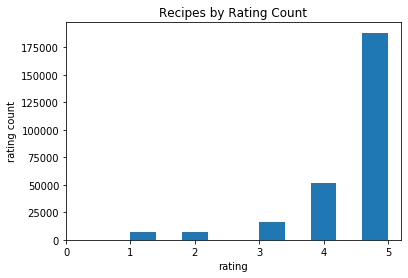

In [213]:
# histogram of tallies of each rating class
plt.figure()
plt.hist(clean_reviews['rate'])
plt.xticks(np.arange(6))
plt.xlabel('rating')
plt.ylabel('rating count')
plt.title('Recipes by Rating Count')
plt.show()

In [214]:
# check portion of ratings that are 5's

len(clean_reviews[clean_reviews['rate']==5]) / len(clean_reviews)

0.6982748077457611

In [215]:
# check portion of ratings that are 4's

len(clean_reviews[clean_reviews['rate']==4]) / len(clean_reviews)

0.19003798758454554

Based on the histogram above, it appears recipes have received very generous ratings (70% are 5s and 20% are 4s), which causes an imbalance in the dataset. Chances are a user is likely rate the recipe a 4 or above. At the same time, ratings are rather subjective in that the value could mean something different for each user. For example, a 4 could mean someone really enjoyed it or it could mean that it was satisfactory for someone else. Because of this, I will binarize the scores where 5 is 1 and everything else is a 0 under my assumption that a 5 likely means that the user 100% enjoyed the recipe and everything else means that they did not 100% love the recipe. This also balances the distribution better as instead of 30% of ratings being spread across 4 classes, it is now 1 class of 0. In a way, this is also similar to Netflix's current rating system where you have the option to give a movie/TV show a thumbs up or not.

In [216]:
# dictionary of replacement values
new_rating = {5: 1, 4: 0, 3: 0, 2: 0, 1: 0}

# binarize ratings where 5 is 1 and <5 is 0
clean_reviews['rate'].replace(new_rating, inplace=True)

# check
clean_reviews['rate'].unique()

array([1, 0])

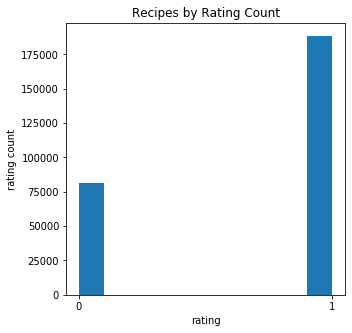

In [217]:
# histogram of tallies of updated rating classes
plt.figure(figsize=(5,5))
plt.hist(clean_reviews['rate'])
plt.xticks(np.arange(0,2,1))
plt.xlabel('rating')
plt.ylabel('rating count')
plt.title('Recipes by Rating Count')
plt.show()

Now that we have binarized the ratings, I would also like to see the distribution of the rating counts of each user and recipe.

In [218]:
# total reviews per recipe
recipe_review_df = pd.DataFrame(clean_reviews.groupby('recipe_id')['rate'].count())
recipe_review_df = recipe_review_df.sort_values('rate', ascending=False)

# check
recipe_review_df.reset_index(inplace=True)
recipe_review_df

recipe_id  rate
0         12698   984
1          8384   984
2          7565   984
3         15184   983
4         10687   983
...         ...   ...
1723       9233    10
1724       9291    10
1725      15069     9
1726       9211     6
1727       9094     4

[1728 rows x 2 columns]

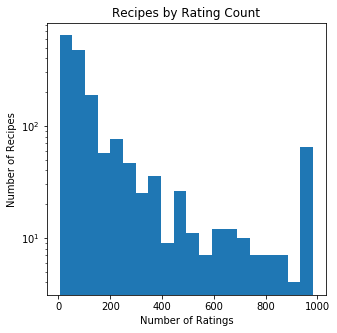

In [219]:
# histogram of tallies of ratings by recipe
plt.figure(figsize=(5,5))
plt.hist(recipe_review_df['rate'], bins=20)
plt.yscale('log')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Recipes')
plt.title('Recipes by Rating Count')
plt.show()

Based on the number of ratings per recipe, it looks like at the minimum, there are 4 total ratings which is good as it is harder to make inferences/recommendations if recipes only have 1 rating. The dataset is not large so I'm not concerned about running into memory issues, so for now, I will not be reducing the number of recipes any further.

Next, we will check the number of ratings given per user.

In [220]:
# total reviews per user
user_review_df = pd.DataFrame(clean_reviews.groupby('profile_id')['rate'].count())
user_review_df = user_review_df.sort_values('rate', ascending=False)

# check
user_review_df.reset_index(inplace=True)

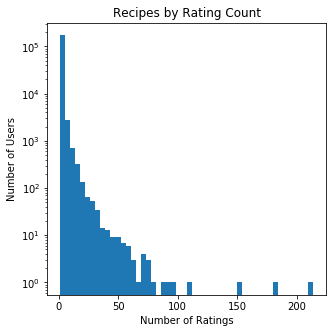

In [221]:
# histogram of tallies of ratings by user
plt.figure(figsize=(5,5))
plt.hist(user_review_df['rate'], bins=50)
plt.yscale('log')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.title('Recipes by Rating Count')
plt.show()

In [222]:
# number of recipes with 1 rating 
len(user_review_df[user_review_df['rate']<=2])

158337

In [223]:
# number of recipes with more than 1 rating 
len(user_review_df[user_review_df['rate']>2])

17210

In [224]:
# number of recipes with more than 1 rating 
len(user_review_df[user_review_df['rate']>=5])

6106

Based on the # of ratings per user, 158,337 users out of 175,547 users have only rated 1 or recipes and 6,106 users that have given more than 5 ratings. To reduce dimensionality, while drawing a balance between "inactive" users and maintaining a decent sized dataset, I will drop the users that have only given 2 ratings. It would also be challenging to find similarities between these users and the recipes if they have not provided many ratings.

In [225]:
# reduce datasete to users who have provided more than 2 ratings
user_review_df = user_review_df[user_review_df['rate']>2]

# check
user_review_df

profile_id  rate
0         1153011   214
1         2043209   181
2         4590553   152
3          303790   109
4         1197175    97
...           ...   ...
17205     4182724     3
17206     3808064     3
17207     4182040     3
17208      884388     3
17209      350583     3

[17210 rows x 2 columns]

With the list of users reduced, we can create a new dataframe with these users and their individual ratings per recipe.

In [226]:
# take list of reduced user IDs
clean_reviews_df = user_review_df['profile_id']

# check
clean_reviews_df

0        1153011
1        2043209
2        4590553
3         303790
4        1197175
          ...   
17205    4182724
17206    3808064
17207    4182040
17208     884388
17209     350583
Name: profile_id, Length: 17210, dtype: int64

In [227]:
# left join user ratings and recipe
clean_reviews_df = pd.merge(clean_reviews_df, clean_reviews, how='left', on='profile_id')

# check
clean_reviews_df

profile_id  recipe_id  rate
0         1153011       7246     1
1         1153011       7269     0
2         1153011       7303     1
3         1153011       7306     1
4         1153011       7307     1
...           ...        ...   ...
90160      884388      11314     1
90161      884388      15603     0
90162      350583       9804     1
90163      350583      11373     1
90164      350583      15767     1

[90165 rows x 3 columns]

Finally, we will save the cleaned reviews to csv.

In [61]:
# save to csv
clean_reviews_df.to_csv('clean_reviews.csv', index=False)

In [233]:
# check saved csv
clean_reviews_df = pd.read_csv('clean_reviews.csv')
clean_reviews_df.head()

profile_id  recipe_id  rate
0     1153011       7246     1
1     1153011       7269     0
2     1153011       7303     1
3     1153011       7306     1
4     1153011       7307     1

Next, we will look at the newly created ingredients dataframe to see if there are any general patterns we can see before conducting a basket analysis. First, we look at the general number of ingredients by recipes.

In [246]:
# set index to recipe_id
basket_df.set_index('recipe_id', inplace=True)

# check 
basket_df.head()

almond  amaretto  anchovy  anise  apple  apple juice  applesauce  \
recipe_id                                                                     
7000            0         0        0      0      0            0           0   
7001            1         0        0      0      0            0           0   
7003            0         0        0      0      0            0           1   
7006            0         0        0      0      1            0           0   
7007            0         0        0      0      0            0           0   

           apricot  arrowroot powder  artichoke  ...  whole wheat  wild rice  \
recipe_id                                        ...                           
7000             0                 0          0  ...            0          0   
7001             0                 0          0  ...            0          0   
7003             0                 0          0  ...            0          0   
7006             0                 0          0  ...            0          0   
7007             0                 0          0  ...            0          0   

           wine  wonton wrappers  worcestershire sauce  xanthan gum  yeast  \
recipe_id                                                                    
7000          0                0                     0            0      1   
7001          0                0                     0            0      0   
7003          0                0                     0            0      0   
7006          0                0                     0            0      0   
7007          0                0                     0            0      0   

           yellow squash  yogurt  zucchini  
recipe_id                                   
7000                   0       0         0  
7001                   0       0         0  
7003                   0       0         0  
7006                   0       0         0  
7007                   0       0         0  

[5 rows x 371 columns]

In [256]:
# make a copy of ingredients
ingred_df = basket_df.copy()
ingred_df.head()

almond  amaretto  anchovy  anise  apple  apple juice  applesauce  \
recipe_id                                                                     
7000            0         0        0      0      0            0           0   
7001            1         0        0      0      0            0           0   
7003            0         0        0      0      0            0           1   
7006            0         0        0      0      1            0           0   
7007            0         0        0      0      0            0           0   

           apricot  arrowroot powder  artichoke  ...  whole wheat  wild rice  \
recipe_id                                        ...                           
7000             0                 0          0  ...            0          0   
7001             0                 0          0  ...            0          0   
7003             0                 0          0  ...            0          0   
7006             0                 0          0  ...            0          0   
7007             0                 0          0  ...            0          0   

           wine  wonton wrappers  worcestershire sauce  xanthan gum  yeast  \
recipe_id                                                                    
7000          0                0                     0            0      1   
7001          0                0                     0            0      0   
7003          0                0                     0            0      0   
7006          0                0                     0            0      0   
7007          0                0                     0            0      0   

           yellow squash  yogurt  zucchini  
recipe_id                                   
7000                   0       0         0  
7001                   0       0         0  
7003                   0       0         0  
7006                   0       0         0  
7007                   0       0         0  

[5 rows x 371 columns]

In [257]:
# create new column with some of ingredients by recipe
ingred_df['total'] = ingred_df.sum(axis=1)
ingred_df.head()

almond  amaretto  anchovy  anise  apple  apple juice  applesauce  \
recipe_id                                                                     
7000            0         0        0      0      0            0           0   
7001            1         0        0      0      0            0           0   
7003            0         0        0      0      0            0           1   
7006            0         0        0      0      1            0           0   
7007            0         0        0      0      0            0           0   

           apricot  arrowroot powder  artichoke  ...  wild rice  wine  \
recipe_id                                        ...                    
7000             0                 0          0  ...          0     0   
7001             0                 0          0  ...          0     0   
7003             0                 0          0  ...          0     0   
7006             0                 0          0  ...          0     0   
7007             0                 0          0  ...          0     0   

           wonton wrappers  worcestershire sauce  xanthan gum  yeast  \
recipe_id                                                              
7000                     0                     0            0      1   
7001                     0                     0            0      0   
7003                     0                     0            0      0   
7006                     0                     0            0      0   
7007                     0                     0            0      0   

           yellow squash  yogurt  zucchini  total  
recipe_id                                          
7000                   0       0         0      6  
7001                   0       0         0     13  
7003                   0       0         0     10  
7006                   0       0         0     14  
7007                   0       0         0      9  

[5 rows x 372 columns]

In [258]:
# reset index
ingred_df.reset_index(inplace=True)

# check
ingred_df

recipe_id  almond  amaretto  anchovy  anise  apple  apple juice  \
0          7000       0         0        0      0      0            0   
1          7001       1         0        0      0      0            0   
2          7003       0         0        0      0      0            0   
3          7006       0         0        0      0      1            0   
4          7007       0         0        0      0      0            0   
...         ...     ...       ...      ...    ...    ...          ...   
3858      15990       0         0        0      0      0            0   
3859      15994       0         0        0      0      0            0   
3860      15995       0         0        0      0      0            0   
3861      15996       0         0        0      0      1            0   
3862      15997       0         0        0      0      0            0   

      applesauce  apricot  arrowroot powder  ...  wild rice  wine  \
0              0        0                 0  ...          0     0   
1              0        0                 0  ...          0     0   
2              1        0                 0  ...          0     0   
3              0        0                 0  ...          0     0   
4              0        0                 0  ...          0     0   
...          ...      ...               ...  ...        ...   ...   
3858           0        0                 0  ...          0     0   
3859           0        0                 0  ...          0     0   
3860           0        0                 0  ...          0     0   
3861           0        0                 0  ...          0     0   
3862           0        0                 0  ...          0     0   

      wonton wrappers  worcestershire sauce  xanthan gum  yeast  \
0                   0                     0            0      1   
1                   0                     0            0      0   
2                   0                     0            0      0   
3                   0                     0            0      0   
4                   0                     0            0      0   
...               ...                   ...          ...    ...   
3858                0                     0            0      0   
3859                0                     0            0      0   
3860                0                     0            0      0   
3861                0                     0            0      0   
3862                0                     0            0      0   

      yellow squash  yogurt  zucchini  total  
0                 0       0         0      6  
1                 0       0         0     13  
2                 0       0         0     10  
3                 0       0         0     14  
4                 0       0         0      9  
...             ...     ...       ...    ...  
3858              0       0         0      8  
3859              0       0         0     10  
3860              0       0         0      5  
3861              0       0         0     10  
3862              0       0         0      6  

[3863 rows x 373 columns]

In [259]:
# take only last column 
ingred_df = ingred_df[['recipe_id', 'total']]
ingred_df.head()

recipe_id  total
0       7000      6
1       7001     13
2       7003     10
3       7006     14
4       7007      9

In [269]:
# describe new df
ingred_df.describe()

recipe_id        total
count   3863.000000  3863.000000
mean   10749.248512     8.221331
std     2462.470321     2.934366
min     7000.000000     1.000000
25%     8440.500000     6.000000
50%    10590.000000     8.000000
75%    12240.000000    10.000000
max    15997.000000    25.000000

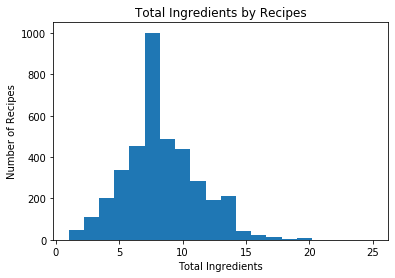

In [268]:
# visualize number of ingredients by recipes
plt.figure()
plt.hist(ingred_df['total'], bins=20)
plt.title('Total Ingredients by Recipes')
plt.xlabel('Total Ingredients')
plt.ylabel('Number of Recipes')
plt.show()

Based off the distribution, it looks like the number of ingredients per recipe is generally around 8. This may be valuable to keep in mind when a user puts in ingredients into their basket and how the recommendations may have to be accepting of greater than 8 ingredients.

Next, it would be interesting to see what the top 10 ingredients are.

In [270]:
# create df with just the counts of each ingredient that appear in the recipes
ingredient_count_df = pd.DataFrame(basket_df.sum(), columns=['count']).sort_values('count', ascending=False).reset_index()

# top 10 ingredients
ingredient_top10 = ingredient_count_df.head(10)
ingredient_top10

# top 30 ingredients
ingredient_top20 = ingredient_count_df.head(20)
ingredient_top20

index  count
0             egg   2410
1     white sugar   2299
2           flour   2287
3          butter   2029
4            salt   1799
5         vanilla   1678
6     baking soda   1018
7            milk   1000
8     brown sugar    860
9   baking powder    826
10      chocolate    772
11          sugar    694
12       cinnamon    685
13         walnut    631
14     shortening    488
15  vegetable oil    446
16   cream cheese    333
17          pecan    328
18         nutmeg    296
19         raisin    291

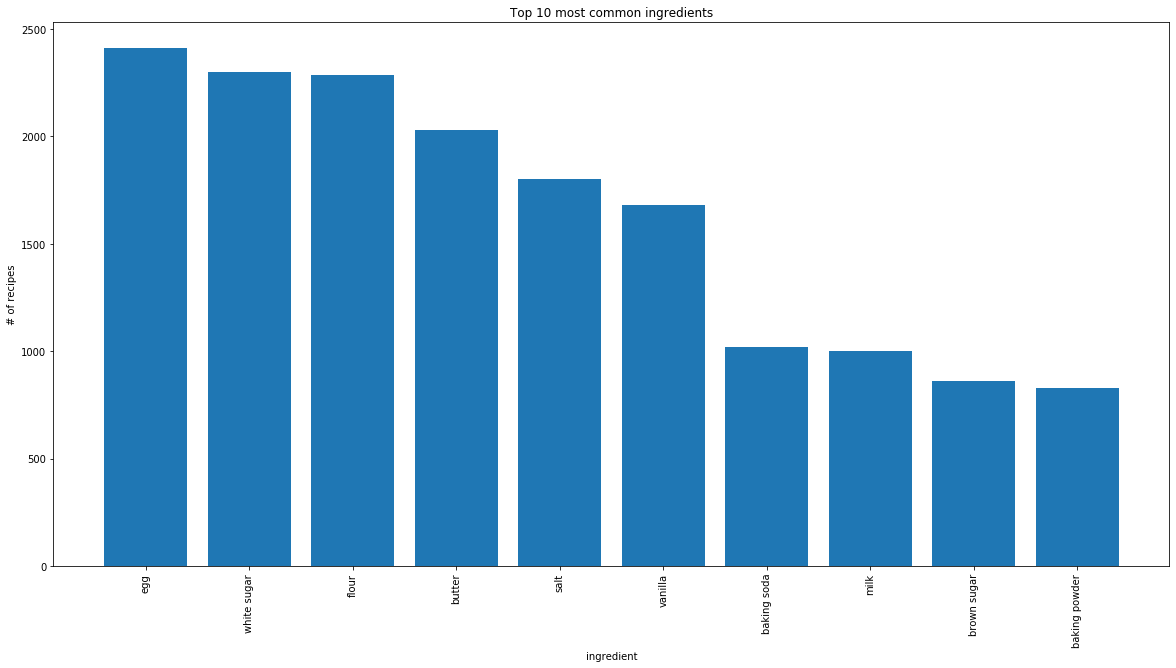

In [271]:
# visualizing top 10 ingredients
plt.figure(figsize=(20,10))
plt.bar(ingredient_top10['index'], ingredient_top10['count'])
plt.xticks(rotation=90)
plt.xlabel('ingredient')
plt.ylabel('# of recipes')
plt.title('Top 10 most common ingredients')
plt.show()

It seems like there are a lot of baking ingredients that appear in the top 10. What would also be interesting to see is the number of recipes by category so see what the assortment is that we have in the dataset.

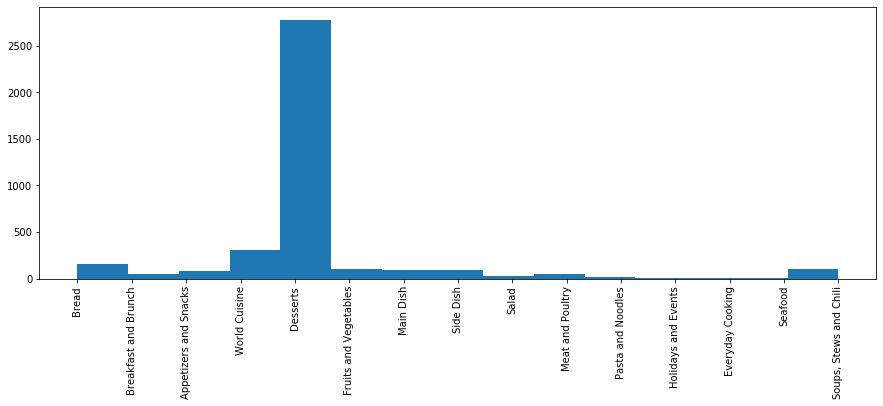

In [272]:
# distribution of recipes by categories
plt.figure(figsize=(15,5))
plt.hist(clean_recipe_df['category'], bins=len(clean_recipe_df['category'].unique()))
plt.xticks(rotation=90)
plt.show()

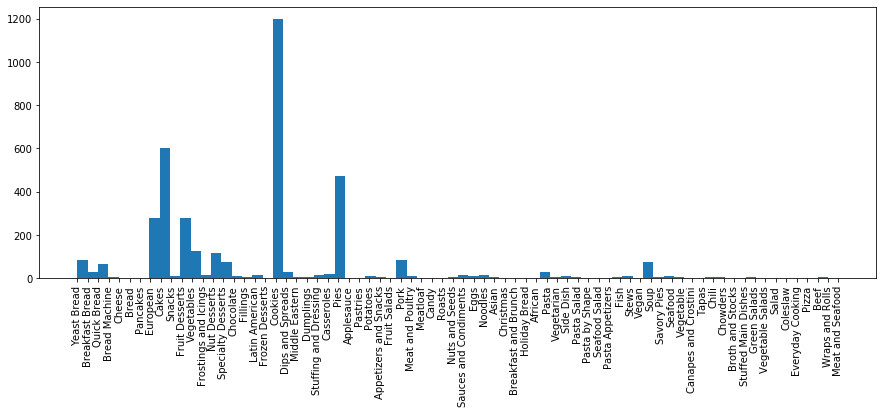

In [273]:
# distribution of recipes by subcategories
plt.figure(figsize=(15,5))
plt.hist(clean_recipe_df['sub_category'], bins=len(clean_recipe_df['sub_category'].unique()))
plt.xticks(rotation=90)
plt.show()

Based on the histogram of the categories, it appears that there are drastically more dessert recipes than there are any other recipes. Looking deeper into the subcategories, it appears `Cookies` seems like the major culprit as there appears to be about 1200 cookie recipes in the dataset. This could be due to the range of recipes ID's we had in the dataset or there could just be more dessert recipes on AllRecipes.com or just in general.

We will be mindful of this when performing a Market Basket Analysis, when it comes to support of the ingredient. However, at this point, I do not suspect that it would be an issue when it comes to finding interrelations and also recommender as it will not be dictated by the frequency of the category but rather the likeness of the recipe and the ingredient. One thing I will keep in mind is potentially dropping the cookie recipes.

## <a id="basket_analysis">Market Basket Analysis</a>

Next, let's take a look at the support between the individual ingredients and begin with looking into the Market Basket analysis by firstly looking at the support of the top 20 ingredients.

In [274]:
# top 20 ingredients
top20_ing = list(ingredient_top20['index'])

In [275]:
# matrix of top 20 ingredients
ing_table = basket_df[top20_ing].T.dot(basket_df[top20_ing])/100
ing_table

egg  white sugar  flour  butter   salt  vanilla  baking soda  \
egg            24.10        17.94  17.81   14.38  13.57    13.68         8.64   
white sugar    17.94        22.99  17.42   13.90  12.98    12.30         8.21   
flour          17.81        17.42  22.87   14.75  14.21    12.26         9.89   
butter         14.38        13.90  14.75   20.29   9.64    10.94         6.06   
salt           13.57        12.98  14.21    9.64  17.99     8.94         7.15   
vanilla        13.68        12.30  12.26   10.94   8.94    16.78         6.16   
baking soda     8.64         8.21   9.89    6.06   7.15     6.16        10.18   
milk            6.45         6.45   5.86    5.56   4.73     4.90         2.01   
brown sugar     6.50         4.40   6.78    5.67   5.14     4.69         4.47   
baking powder   7.39         6.90   8.01    4.85   6.04     5.05         3.10   
chocolate       5.04         4.71   4.41    5.02   3.31     4.43         2.65   
sugar           4.67         3.47   4.87    4.85   2.98     4.14         1.70   
cinnamon        5.30         5.06   5.39    3.67   4.39     2.91         3.42   
walnut          4.81         4.06   4.75    4.10   3.54     3.56         2.75   
shortening      3.98         3.59   4.59    1.49   3.55     2.67         2.63   
vegetable oil   3.42         2.60   2.56    0.93   2.44     2.04         1.65   
cream cheese    1.94         1.94   1.44    2.11   0.87     1.95         0.48   
pecan           2.39         2.07   1.99    2.30   1.46     2.03         0.85   
nutmeg          2.25         2.07   2.24    1.48   1.97     1.06         1.38   
raisin          2.18         2.04   2.29    1.61   1.79     1.20         1.55   

                milk  brown sugar  baking powder  chocolate  sugar  cinnamon  \
egg             6.45         6.50           7.39       5.04   4.67      5.30   
white sugar     6.45         4.40           6.90       4.71   3.47      5.06   
flour           5.86         6.78           8.01       4.41   4.87      5.39   
butter          5.56         5.67           4.85       5.02   4.85      3.67   
salt            4.73         5.14           6.04       3.31   2.98      4.39   
vanilla         4.90         4.69           5.05       4.43   4.14      2.91   
baking soda     2.01         4.47           3.10       2.65   1.70      3.42   
milk           10.00         1.70           2.66       2.02   1.95      1.63   
brown sugar     1.70         8.60           2.41       2.43   0.91      2.28   
baking powder   2.66         2.41           8.26       1.55   1.73      1.92   
chocolate       2.02         2.43           1.55       7.72   1.51      0.63   
sugar           1.95         0.91           1.73       1.51   6.94      1.14   
cinnamon        1.63         2.28           1.92       0.63   1.14      6.85   
walnut          1.56         2.45           1.84       1.78   1.35      1.90   
shortening      1.63         1.74           1.98       0.96   1.12      1.33   
vegetable oil   0.96         0.65           1.06       0.64   1.02      1.14   
cream cheese    0.92         0.30           0.42       0.65   1.37      0.52   
pecan           0.86         1.03           0.60       0.71   0.87      0.61   
nutmeg          0.95         0.94           0.73       0.08   0.38      2.18   
raisin          0.67         1.03           0.95       0.17   0.32      1.62   

               walnut  shortening  vegetable oil  cream cheese  pecan  nutmeg  \
egg              4.81        3.98           3.42          1.94   2.39    2.25   
white sugar      4.06        3.59           2.60          1.94   2.07    2.07   
flour            4.75        4.59           2.56          1.44   1.99    2.24   
butter           4.10        1.49           0.93          2.11   2.30    1.48   
salt             3.54        3.55           2.44          0.87   1.46    1.97   
vanilla          3.56        2.67           2.04          1.95   2.03    1.06   
baking soda      2.75        2.63           1.65          0.48   0.

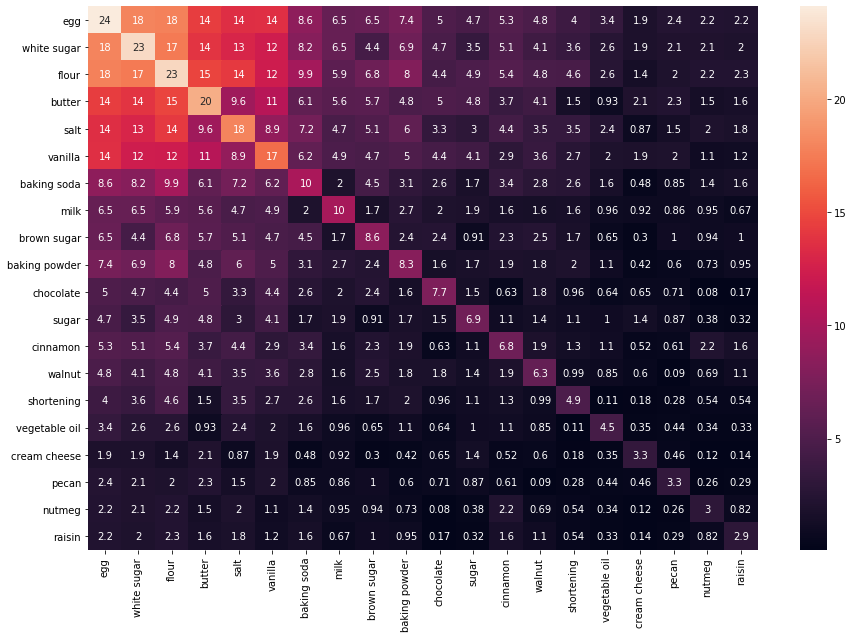

In [276]:
# visualize the support of the top 20 ingredients
plt.figure(figsize=(15,10))
sns.heatmap(ing_table, annot=True)
plt.show()

Looking at the top 20 ingredients, it looks like most common items are related to desserts, likely due to the distribution of the recipes by categories. However, I will not downsampling this category to allow for more association rules to be detected which will allow the recommender more options to suggest consequents.

Before applying the apriori function to the baskets of ingredients, we need to determine the minimum support to apply - that is, the frequency that the ingredient appears in all the recipes in the dataset. For this we, will plot out the support of each individual ingredient on a histogram and determine the cutoff point. The default in apriori is 0.5 (50%) so we will use this as a baseline for comparison.

In [277]:
# check number of ingredients
basket_df.shape[1]

371

In [278]:
# looking at support of each ingredient
support = basket_df.sum()/len(basket_df)
support = support.sort_values(ascending=False)
support

egg                            0.623867
white sugar                    0.595133
flour                          0.592027
butter                         0.525239
salt                           0.465700
                                 ...   
lite frozen whipped topping    0.000259
liquid sweetener               0.000259
linguica                       0.000259
lavender flower                0.000259
kielbasa                       0.000259
Length: 371, dtype: float64

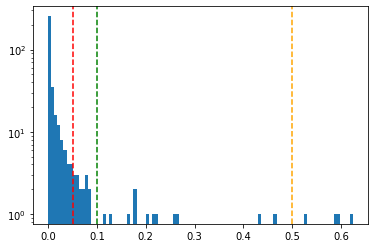

In [279]:
# plot the ingredients' support on histogram
plt.figure()
plt.hist(support, bins=100)
plt.yscale('log')
plt.axvline(0.05, color='red', linestyle='--')
plt.axvline(0.10, color='green', linestyle='--')
plt.axvline(0.5, color='orange', linestyle='--')
plt.show()

In [280]:
# number of ingredients with support over 5%
print(f'At 5% support, there are {len(support[support > 0.05])} ingredients')

# number of ingredients with support over 10%
print(f'At 10% support, there are {len(support[support > 0.10])} ingredients')

# number of ingredients with support over 50%
print(f'At 50% support, there are {len(support[support > 0.5])} ingredients')

At 5% support, there are 31 ingredients
At 10% support, there are 16 ingredients
At 50% support, there are 4 ingredients


Judging by the histogram above, the default minimum support of 50% would cut off a lot of the ingredients, which suggests that it may be too conservative. At 50% minimum support, there would only be 4 ingredients that fit this criteria. Given that there are 371 recipes in our dataset, even at 5% minimum support, this would only capture 31 ingredients or ~8% of the ingredients. 

I will also check the number of ingredients captured if we were to set minimum support between 0 and 1%, at increments of .1. 

In [281]:
# check number of ingredients captured based on minimum support from 0 to 1%
for i in np.arange(0,0.1,0.01):
    print(f'{i}: {len(support[support > i])} ingredients OR {len(support[support > i])/371*100}%')
    

0.0: 371 ingredients OR 100.0%
0.01: 91 ingredients OR 24.528301886792452%
0.02: 63 ingredients OR 16.9811320754717%
0.03: 49 ingredients OR 13.20754716981132%
0.04: 38 ingredients OR 10.242587601078167%
0.05: 31 ingredients OR 8.355795148247978%
0.06: 25 ingredients OR 6.738544474393531%
0.07: 22 ingredients OR 5.929919137466308%
0.08: 18 ingredients OR 4.8517520215633425%
0.09: 16 ingredients OR 4.31266846361186%


Based on the above, we would need to set minimum support at 0.04% to capture 10% of the ingredients. Even at 1%, we only capture about a quarter of the ingredients. I will take 1% for now, as I want to see what patterns we can capture with a quarter of the ingredients and if there are any relationships between these items.

Now, using apriori function with minimum support of 1%, we can find the frequent items/antecedents including groups of ingredients. 

In [282]:
# determining frequent itemsets with minimum support of 1%
frequent_itemsets = apriori(basket_df, min_support=0.01, use_colnames=True)

frequent_itemsets

support                                           itemsets
0     0.068858                                           (almond)
1     0.034688                                            (apple)
2     0.012943                                       (applesauce)
3     0.011649                                          (apricot)
4     0.015014                                            (bacon)
...        ...                                                ...
7296  0.010096  (vanilla, walnut, cinnamon, baking soda, white...
7297  0.016309  (vanilla, butter, chocolate, white sugar, egg,...
7298  0.013720  (vanilla, walnut, butter, white sugar, egg, br...
7299  0.010614  (vanilla, walnut, butter, chocolate, white sug...
7300  0.014497  (vanilla, butter, baking soda, chocolate, whit...

[7301 rows x 2 columns]

In [283]:
# see itemsets in descending order by support
frequent_itemsets = frequent_itemsets.sort_values('support', ascending=False)

# top 10 itemsets
frequent_itemsets.head(10)

support              itemsets
34   0.623867                 (egg)
88   0.595133         (white sugar)
35   0.592027               (flour)
14   0.525239              (butter)
74   0.465700                (salt)
434  0.464406    (white sugar, egg)
400  0.461041          (egg, flour)
465  0.450945  (white sugar, flour)
83   0.434377             (vanilla)
231  0.381828       (flour, butter)

Essentially, in the table above is what we saw earlier when we looked at the support of each individual ingredient. Additionally, what we are also seeing here are that itemsets like white sugar and egg are also in the top 10 based on support.

Next, by applying the `association_rules` function, we can get the other metrics based on these itemsets. These include `confidence`, `lift`, `leverage`, and `conviction`. For the most part, my main focus will be the `lift` metric as this, statistically, will indicate that if the number is above 1 then the antecedents and consequents occur together more than they do independently by chance. In other words, the antecedent increases the likelihood that the consequent is part of the same transaction.

In [284]:
# find association rules with lift above 1
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# sort rules by lift in descending order
rules = rules.sort_values('lift', ascending=False)

# check
rules.head(10)

antecedents                      consequents  \
199300      (cinnamon, flour, molasses)            (ginger, baking soda)   
199309            (ginger, baking soda)      (cinnamon, flour, molasses)   
199307             (cinnamon, molasses)     (ginger, flour, baking soda)   
199302     (ginger, flour, baking soda)             (cinnamon, molasses)   
198583            (ginger, baking soda)             (molasses, cinnamon)   
198578             (molasses, cinnamon)            (ginger, baking soda)   
199295  (cinnamon, ginger, baking soda)                (molasses, flour)   
199314                (molasses, flour)  (cinnamon, ginger, baking soda)   
199312          (molasses, baking soda)        (cinnamon, ginger, flour)   
199297        (cinnamon, ginger, flour)          (molasses, baking soda)   

        antecedent support  consequent support   support  confidence  \
199300            0.013720            0.018379  0.010096    0.735849   
199309            0.018379            0.013720  0.010096    0.549296   
199307            0.014497            0.017862  0.010096    0.696429   
199302            0.017862            0.014497  0.010096    0.565217   
198583            0.018379            0.014497  0.010096    0.549296   
198578            0.014497            0.018379  0.010096    0.696429   
199295            0.014755            0.018897  0.010096    0.684211   
199314            0.018897            0.014755  0.010096    0.534247   
199312            0.016050            0.018638  0.010096    0.629032   
199297            0.018638            0.016050  0.010096    0.541667   

             lift  leverage  conviction  
199300  40.036407  0.009844    3.716135  
199309  40.036407  0.009844    2.188309  
199307  38.989907  0.009837    3.235279  
199302  38.989907  0.009837    2.266658  
198583  37.891600  0.009829    2.186586  
198578  37.891600  0.009829    3.233573  
199295  36.206921  0.009817    3.106825  
199314  36.206921  0.009817    2.115378  
199312  33.749328  0.009797    2.645410  
199297  33.749328  0.009797    2.146801

In [46]:
# save rules to csv
rules.to_csv('association_rules.csv', index=False)

In [285]:
# check association_rules.csv
pd.read_csv('association_rules.csv')

antecedents                 consequents  \
0        cinnamon, flour, molasses         baking soda, ginger   
1              baking soda, ginger   cinnamon, flour, molasses   
2               cinnamon, molasses  baking soda, flour, ginger   
3       baking soda, flour, ginger          cinnamon, molasses   
4              baking soda, ginger          cinnamon, molasses   
...                            ...                         ...   
201891                      nutmeg         egg, flour, vanilla   
201892       butter, salt, vanilla                      raisin   
201893                      raisin       butter, salt, vanilla   
201894                raisin, salt        vanilla, white sugar   
201895        vanilla, white sugar                raisin, salt   

        antecedent support  consequent support   support  confidence  \
0                 0.013720            0.018379  0.010096    0.735849   
1                 0.018379            0.013720  0.010096    0.549296   
2                 0.014497            0.017862  0.010096    0.696429   
3                 0.017862            0.014497  0.010096    0.565217   
4                 0.018379            0.014497  0.010096    0.549296   
...                    ...                 ...       ...         ...   
201891            0.076624            0.280352  0.021486    0.280405   
201892            0.151178            0.075330  0.011390    0.075342   
201893            0.075330            0.151178  0.011390    0.151203   
201894            0.046337            0.318405  0.014755    0.318436   
201895            0.318405            0.046337  0.014755    0.046341   

             lift  leverage  conviction  
0       40.036407  0.009844    3.716135  
1       40.036407  0.009844    2.188309  
2       38.989907  0.009837    3.235279  
3       38.989907  0.009837    2.266658  
4       37.891600  0.009829    2.186586  
...           ...       ...         ...  
201891   1.000190  0.000004    1.000074  
201892   1.000165  0.000002    1.000013  
201893   1.000165  0.000002    1.000029  
201894   1.000095  0.000001    1.000045  
201895   1.000095  0.000001    1.000005  

[201896 rows x 9 columns]

Upon reading in the association rules table, we can see that the tuples have been converted to frozensets. Because of this, I will apply some cleaning tactics to extract the ingredients out of the frozensets. First, we will convert the tuplies to lists. 

In [286]:
# convert antecedents and consequents to lists
rules['antecedents'] = rules['antecedents'].apply(lambda x: list(x))
rules['consequents'] = rules['consequents'].apply(lambda x: list(x))

# check
rules

antecedents                   consequents  \
199300   [cinnamon, flour, molasses]         [ginger, baking soda]   
199309         [ginger, baking soda]   [cinnamon, flour, molasses]   
199307          [cinnamon, molasses]  [ginger, flour, baking soda]   
199302  [ginger, flour, baking soda]          [cinnamon, molasses]   
198583         [ginger, baking soda]          [molasses, cinnamon]   
...                              ...                           ...   
51441                       [nutmeg]         [vanilla, egg, flour]   
159842       [vanilla, salt, butter]                      [raisin]   
159849                      [raisin]       [vanilla, salt, butter]   
100014                [raisin, salt]        [vanilla, white sugar]   
100009        [vanilla, white sugar]                [raisin, salt]   

        antecedent support  consequent support   support  confidence  \
199300            0.013720            0.018379  0.010096    0.735849   
199309            0.018379            0.013720  0.010096    0.549296   
199307            0.014497            0.017862  0.010096    0.696429   
199302            0.017862            0.014497  0.010096    0.565217   
198583            0.018379            0.014497  0.010096    0.549296   
...                    ...                 ...       ...         ...   
51441             0.076624            0.280352  0.021486    0.280405   
159842            0.151178            0.075330  0.011390    0.075342   
159849            0.075330            0.151178  0.011390    0.151203   
100014            0.046337            0.318405  0.014755    0.318436   
100009            0.318405            0.046337  0.014755    0.046341   

             lift  leverage  conviction  
199300  40.036407  0.009844    3.716135  
199309  40.036407  0.009844    2.188309  
199307  38.989907  0.009837    3.235279  
199302  38.989907  0.009837    2.266658  
198583  37.891600  0.009829    2.186586  
...           ...       ...         ...  
51441    1.000190  0.000004    1.000074  
159842   1.000165  0.000002    1.000013  
159849   1.000165  0.000002    1.000029  
100014   1.000095  0.000001    1.000045  
100009   1.000095  0.000001    1.000005  

[201896 rows x 9 columns]

Now that that the tuples of ingredients have been converted to lists, we can strip the special characters by treating the list as string. Before doing so, I will also sort each list of list for cleanliness.

In [287]:
# sort each list of list 
rules['antecedents'] = rules['antecedents'].apply(lambda x:sorted(x))
rules['consequents'] = rules['consequents'].apply(lambda x:sorted(x))

# check
rules.head()

antecedents                   consequents  \
199300   [cinnamon, flour, molasses]         [baking soda, ginger]   
199309         [baking soda, ginger]   [cinnamon, flour, molasses]   
199307          [cinnamon, molasses]  [baking soda, flour, ginger]   
199302  [baking soda, flour, ginger]          [cinnamon, molasses]   
198583         [baking soda, ginger]          [cinnamon, molasses]   

        antecedent support  consequent support   support  confidence  \
199300            0.013720            0.018379  0.010096    0.735849   
199309            0.018379            0.013720  0.010096    0.549296   
199307            0.014497            0.017862  0.010096    0.696429   
199302            0.017862            0.014497  0.010096    0.565217   
198583            0.018379            0.014497  0.010096    0.549296   

             lift  leverage  conviction  
199300  40.036407  0.009844    3.716135  
199309  40.036407  0.009844    2.188309  
199307  38.989907  0.009837    3.235279  
199302  38.989907  0.009837    2.266658  
198583  37.891600  0.009829    2.186586

In [288]:
# convert antecedents and consequents to string and then strip special characters
rules['antecedents'] = rules['antecedents'].astype(str).apply(lambda x: x.lstrip("['").rstrip("']")).replace("\'","", regex=True)
rules['consequents'] = rules['consequents'].astype(str).apply(lambda x: x.lstrip("['").rstrip("']")).replace("\'","", regex=True)

# check
rules.head()

antecedents                 consequents  \
199300   cinnamon, flour, molasses         baking soda, ginger   
199309         baking soda, ginger   cinnamon, flour, molasses   
199307          cinnamon, molasses  baking soda, flour, ginger   
199302  baking soda, flour, ginger          cinnamon, molasses   
198583         baking soda, ginger          cinnamon, molasses   

        antecedent support  consequent support   support  confidence  \
199300            0.013720            0.018379  0.010096    0.735849   
199309            0.018379            0.013720  0.010096    0.549296   
199307            0.014497            0.017862  0.010096    0.696429   
199302            0.017862            0.014497  0.010096    0.565217   
198583            0.018379            0.014497  0.010096    0.549296   

             lift  leverage  conviction  
199300  40.036407  0.009844    3.716135  
199309  40.036407  0.009844    2.188309  
199307  38.989907  0.009837    3.235279  
199302  38.989907  0.009837    2.266658  
198583  37.891600  0.009829    2.186586

Now that the table has been cleaned up, I can again, save and overwrite the `association_rules.csv`.

In [68]:
# save rules to csv
rules.to_csv('association_rules.csv', index=False)

In [15]:
# check association_rules.csv
rules = pd.read_csv('association_rules.csv')
rules.head()

antecedents                 consequents  antecedent support  \
0   cinnamon, flour, molasses         baking soda, ginger            0.013720   
1         baking soda, ginger   cinnamon, flour, molasses            0.018379   
2          cinnamon, molasses  baking soda, flour, ginger            0.014497   
3  baking soda, flour, ginger          cinnamon, molasses            0.017862   
4         baking soda, ginger          cinnamon, molasses            0.018379   

   consequent support   support  confidence       lift  leverage  conviction  
0            0.018379  0.010096    0.735849  40.036407  0.009844    3.716135  
1            0.013720  0.010096    0.549296  40.036407  0.009844    2.188309  
2            0.017862  0.010096    0.696429  38.989907  0.009837    3.235279  
3            0.014497  0.010096    0.565217  38.989907  0.009837    2.266658  
4            0.014497  0.010096    0.549296  37.891600  0.009829    2.186586

Now that we have our association rules and various metrics, we can visualize the lift and confidence - the two key metrics that I care more about, with lift being the primary target.

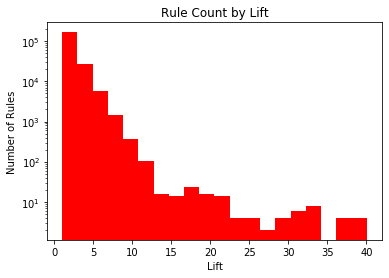

In [290]:
# plot lift
plt.figure()
plt.hist(rules['lift'], bins=20, color='red')
plt.yscale('log')
plt.title('Rule Count by Lift')
plt.xlabel('Lift')
plt.ylabel('Number of Rules')
plt.show()

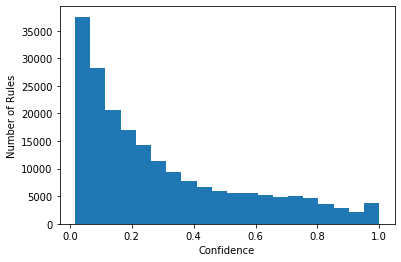

In [291]:
# plot conviction
plt.figure()
plt.hist(rules['confidence'], bins=20)
plt.xlabel('Confidence')
plt.ylabel('Number of Rules')
plt.show()

As we can see from our association rules table, there are 201,896 rules with lift over 1. More surprisingly, is that there are rules with lift well above 1 like antecedent `(molasses, flour, cinnamon)` has a lift of 40 with consequent `(baking soda, ginger)`. This makes me very confident to say that there is very high correlation between the 2 itemsets and that when a recipe includes the antecedent, the consequent is very likely to be in the recipe as well. Additionally, what I notice is that, the combination of the 5 ingredients frequent the top 10 rules.

We will also keep in mind the `confidence` metric which identifies the likelihood that a basket that includes the antecedent also includes the consequent. For this, the higher the value, the better and we can see that there is a large number of rules that are between 0 and 0.2. 

Putting this into the perspective of a recommender system, when a user selects an ingredient or set of ingredients, if it matches any of the antecedents, then we can recommend the consequent.

For now, we will test extracting a consequent based on an antecedent.

In [292]:
# test antecedent input of 'flour, molasses' to get consequent with highest lift 
rules[rules['antecedents'] == "flour, molasses"]['consequents'][:1]

6    baking soda, cinnamon, ginger
Name: consequents, dtype: object

In [293]:
# test antecedent input of 'flour, molasses' to get consequent with highest lift using list
list(rules[rules['antecedents'] == "flour, molasses"]['consequents'])[0]

'baking soda, cinnamon, ginger'

In [294]:
# test antecedent input of 'flour, molasses' to get random consequent
rules[rules['antecedents'] == "flour, molasses"]['consequents'].sample(1)

6    baking soda, cinnamon, ginger
Name: consequents, dtype: object

That seemed to work as intended, however that is if the antecedents appear exactly as they appear in the association rules. So we will consider workarounds when they don't match exactly. My thoughts are we can approach this in several options:\
1) Check if the ingredients inputted by the user match exactly with antecedents in the association rules.\
2) If not, then isolate each ingredient inputted to see if they match with the singular antecedents.\
3) If that fails as well, we will attempt to match based on network neighbours.\
4) If all else fails, a random recommendation that is in our ingredient list will be suggested.

In [295]:
# assigning variables to test ingredients 
x = 'flour'
y = 'molasses'
z = 'potatos'

In [296]:
# if only x y ingredients selected
xy = x + ', ' + y

# random consequent output
rules[rules['antecedents'] == xy]['consequents'].sample(1)

193214    egg
Name: consequents, dtype: object

In [13]:
# function to sort ingredients inputted by user
def sort_ingredients(ingredients):
    ing = ingredients.lower().split(', ')
    ing = sorted(ing)
    return ', '.join(ing)

In [298]:
# if only x y z ingredients selected
xyz = z + ', ' + x + ', ' + y + ', ' + 'feet'
xyz

'potatos, flour, molasses, feet'

In [ ]:
# take user input
xyz = input('What ingredients would you like to add to your shopping cart?\
            \nPlease separate ingredients with a comma. \n')


# original ingredients input as list
xyz_split = xyz.lower().split(', ')

# sort ingredients input to match association rules
ingredients = sort_ingredients(xyz)

# setting variable for nested while loop
index_num = 0

# check if ingredients inputted matches antecedents in association rules
if (rules['antecedents'] == ingredients).sum() > 0:
    # random consequent output
    print(f'{xyz} have been added to your shopping cart. We also think you would enjoy the following item(s) as well:')
    # make recommendation
    item_reco = rules[rules['antecedents'] == xyz_split[index_num]]['consequents'].sample(1)
    display(item_reco)
    # offer to add recommendations to basket
    response = input('Would you like us to add these items to your basket? (Y/N)?')
    # add recommendations to basket if user says Y
    if response == 'Y':
        xyz2 = xyz + ', ' + item_reco
        print('Great, your basket has been updated to:')
        display(xyz2)
    # no changes to basket
    else: 
        print('No problem. Your basket remains as:')
        display(xyz)
else:
    # random ingredient from list of input ingredients
    while index_num < len(xyz.split(', ')):
        # check if individual ingredient is part of association rules or if we have exhausted all ingredients in 
        # the list, if so then break out of loop
        if (rules['antecedents'] == xyz_split[index_num]).sum() > 0 or index_num == (len(xyz_split) - 1):
            break
        else:
            # if ingredient not part of association rules then check next ingredient in list 
            index_num += 1
    
    if (rules['antecedents'] == xyz_split[index_num]).sum() > 0: 
        # random consequent output
        print(f'{xyz} have been added to your shopping cart. We also think you would enjoy the following item(s) as well:')
        # make recommendation
        item_reco = rules[rules['antecedents'] == xyz_split[index_num]]['consequents'].sample(1)
        display(item_reco)
        # offer to add recommendations to basket
        response = input('Would you like us to add these items to your basket? (Y/N)?')
        # add recommendations to basket if user says Y
        if response == 'Y':
            xyz2 = xyz + ', ' + item_reco
            print('Great, your basket has been updated to:')
            display(xyz2)
        # no changes to basket
        else: 
            print('No problem. Your basket remains as:')
            display(xyz)
    else: 
        print('Sorry, I got nothing to offer you.')
    
# rules[rules['antecedents'] == ingredients]

Based on the code above, for what I can see, I  have exhausted all the possibilities given what a list of ingredients that a user inputs, in terms of the information available in the previously established association rules from the basket analysis (note: the one exception is spelling errors, but spelling errors upon input will be underscored with a red dotted line). 

For the next step, it is to tackle the issue when a user provides a list of ingredients where none of the ingredients are part of the association rules, however at least one of the ingredients is part of the entire ingredients used in all the recipes available. For this, I will be leveraging network analysis to find the neighbouring ingredients (hopefully the neighbor with the highest weighted edge).

## <a id="networkx">Network Analysis</a>

Leverage association_rules, we can find every pair combination between each ingredient that appear in each recipe. Additionally, we can use the support as the weight for the edges.

In [3]:
# read in baskets data
basket_df = pd.read_csv('market_baskets.csv')
basket_df.set_index('recipe_id', inplace=True)

In [4]:
# check
basket_df.head()

almond  amaretto  anchovy  anise  apple  apple juice  applesauce  \
recipe_id                                                                     
7000            0         0        0      0      0            0           0   
7001            1         0        0      0      0            0           0   
7003            0         0        0      0      0            0           1   
7006            0         0        0      0      1            0           0   
7007            0         0        0      0      0            0           0   

           apricot  arrowroot powder  artichoke  ...  whole wheat  wild rice  \
recipe_id                                        ...                           
7000             0                 0          0  ...            0          0   
7001             0                 0          0  ...            0          0   
7003             0                 0          0  ...            0          0   
7006             0                 0          0  ...            0          0   
7007             0                 0          0  ...            0          0   

           wine  wonton wrappers  worcestershire sauce  xanthan gum  yeast  \
recipe_id                                                                    
7000          0                0                     0            0      1   
7001          0                0                     0            0      0   
7003          0                0                     0            0      0   
7006          0                0                     0            0      0   
7007          0                0                     0            0      0   

           yellow squash  yogurt  zucchini  
recipe_id                                   
7000                   0       0         0  
7001                   0       0         0  
7003                   0       0         0  
7006                   0       0         0  
7007                   0       0         0  

[5 rows x 371 columns]

In [5]:
# using apriori to find all pairs in the recipes 
# min_support of 0.0002 since for pair to be in 1 of 3,863 recipes is 0.026% 
frequent_items = apriori(basket_df, min_support=0.0002, max_len=2, use_colnames=True)

frequent_items.head()

support    itemsets
0  0.068858    (almond)
1  0.002589  (amaretto)
2  0.000518   (anchovy)
3  0.009578     (anise)
4  0.034688     (apple)

In [6]:
# find associations between pairs of ingredients, support_only since no other metric needs to be considered
pairs = association_rules(frequent_items, support_only=True, min_threshold=0.0002)

# check
pairs.head(10)

antecedents    consequents  antecedent support  consequent support  \
0     (amaretto)       (almond)                 NaN                 NaN   
1       (almond)     (amaretto)                 NaN                 NaN   
2        (anise)       (almond)                 NaN                 NaN   
3       (almond)        (anise)                 NaN                 NaN   
4       (almond)        (apple)                 NaN                 NaN   
5        (apple)       (almond)                 NaN                 NaN   
6       (almond)  (apple juice)                 NaN                 NaN   
7  (apple juice)       (almond)                 NaN                 NaN   
8       (almond)   (applesauce)                 NaN                 NaN   
9   (applesauce)       (almond)                 NaN                 NaN   

    support  confidence  lift  leverage  conviction  
0  0.001035         NaN   NaN       NaN         NaN  
1  0.001035         NaN   NaN       NaN         NaN  
2  0.001553         NaN   NaN       NaN         NaN  
3  0.001553         NaN   NaN       NaN         NaN  
4  0.001294         NaN   NaN       NaN         NaN  
5  0.001294         NaN   NaN       NaN         NaN  
6  0.000518         NaN   NaN       NaN         NaN  
7  0.000518         NaN   NaN       NaN         NaN  
8  0.000777         NaN   NaN       NaN         NaN  
9  0.000777         NaN   NaN       NaN         NaN

As the antecedents and consequents are tuples, I will convert them to strings.

In [7]:
# convert antecedents and consequents to lists
pairs['antecedents'] = pairs['antecedents'].apply(lambda x: list(x))
pairs['consequents'] = pairs['consequents'].apply(lambda x: list(x))

# check
pairs.head()

antecedents consequents  antecedent support  consequent support   support  \
0  [amaretto]    [almond]                 NaN                 NaN  0.001035   
1    [almond]  [amaretto]                 NaN                 NaN  0.001035   
2     [anise]    [almond]                 NaN                 NaN  0.001553   
3    [almond]     [anise]                 NaN                 NaN  0.001553   
4    [almond]     [apple]                 NaN                 NaN  0.001294   

   confidence  lift  leverage  conviction  
0         NaN   NaN       NaN         NaN  
1         NaN   NaN       NaN         NaN  
2         NaN   NaN       NaN         NaN  
3         NaN   NaN       NaN         NaN  
4         NaN   NaN       NaN         NaN

In [8]:
# convert antecedents and consequents to string and then strip special characters
pairs['antecedents'] = pairs['antecedents'].astype(str).apply(lambda x: x.lstrip("['").rstrip("']"))
pairs['consequents'] = pairs['consequents'].astype(str).apply(lambda x: x.lstrip("['").rstrip("']"))

# check
pairs.head()

antecedents consequents  antecedent support  consequent support   support  \
0    amaretto      almond                 NaN                 NaN  0.001035   
1      almond    amaretto                 NaN                 NaN  0.001035   
2       anise      almond                 NaN                 NaN  0.001553   
3      almond       anise                 NaN                 NaN  0.001553   
4      almond       apple                 NaN                 NaN  0.001294   

   confidence  lift  leverage  conviction  
0         NaN   NaN       NaN         NaN  
1         NaN   NaN       NaN         NaN  
2         NaN   NaN       NaN         NaN  
3         NaN   NaN       NaN         NaN  
4         NaN   NaN       NaN         NaN

Based on the association rules table, it looks like every two rows have the same ingredients, just reversed where the former antecedent is the consequent is the second row. Just to confirm, I will look at the tail 10 rows. 

In [9]:
# check
pairs.tail(10)

antecedents    consequents  antecedent support  consequent support  \
20312    whole wheat          yeast                 NaN                 NaN   
20313          yeast    whole wheat                 NaN                 NaN   
20314    whole wheat         yogurt                 NaN                 NaN   
20315         yogurt    whole wheat                 NaN                 NaN   
20316    xanthan gum          yeast                 NaN                 NaN   
20317          yeast    xanthan gum                 NaN                 NaN   
20318          yeast         yogurt                 NaN                 NaN   
20319         yogurt          yeast                 NaN                 NaN   
20320       zucchini  yellow squash                 NaN                 NaN   
20321  yellow squash       zucchini                 NaN                 NaN   

        support  confidence  lift  leverage  conviction  
20312  0.002589         NaN   NaN       NaN         NaN  
20313  0.002589         NaN   NaN       NaN         NaN  
20314  0.000518         NaN   NaN       NaN         NaN  
20315  0.000518         NaN   NaN       NaN         NaN  
20316  0.000259         NaN   NaN       NaN         NaN  
20317  0.000259         NaN   NaN       NaN         NaN  
20318  0.000518         NaN   NaN       NaN         NaN  
20319  0.000518         NaN   NaN       NaN         NaN  
20320  0.000518         NaN   NaN       NaN         NaN  
20321  0.000518         NaN   NaN       NaN         NaN

By looking at the head 10 rows and the tail 10 rows, it looks like my intuitions were correct in that every two rows have the same ingredients. We will assume this is true for the whole table, hence we will skip every other row and also drop the columns with no values.

In [10]:
# skip every other row as they are duplicates
pairs = pairs.iloc[::2]
pairs.head()

antecedents  consequents  antecedent support  consequent support   support  \
0    amaretto       almond                 NaN                 NaN  0.001035   
2       anise       almond                 NaN                 NaN  0.001553   
4      almond        apple                 NaN                 NaN  0.001294   
6      almond  apple juice                 NaN                 NaN  0.000518   
8      almond   applesauce                 NaN                 NaN  0.000777   

   confidence  lift  leverage  conviction  
0         NaN   NaN       NaN         NaN  
2         NaN   NaN       NaN         NaN  
4         NaN   NaN       NaN         NaN  
6         NaN   NaN       NaN         NaN  
8         NaN   NaN       NaN         NaN

In [11]:
# drop all columns except for antecedents, consquents and support
pairs.drop(['antecedent support', 'consequent support','confidence', 'lift', 'leverage', 'conviction'],\
           axis=1, inplace=True)

# check
pairs.head()

antecedents  consequents   support
0    amaretto       almond  0.001035
2       anise       almond  0.001553
4      almond        apple  0.001294
6      almond  apple juice  0.000518
8      almond   applesauce  0.000777

In [119]:
# rename support to weight
pairs.columns = ['antecedents', 'consequents', 'weight']

# check
pairs

antecedents    consequents    weight
0         amaretto         almond  0.001035
2           almond          anise  0.001553
4            apple         almond  0.001294
6      apple juice         almond  0.000518
8       applesauce         almond  0.000777
...            ...            ...       ...
20312        yeast    whole wheat  0.002589
20314       yogurt    whole wheat  0.000518
20316  xanthan gum          yeast  0.000259
20318       yogurt          yeast  0.000518
20320     zucchini  yellow squash  0.000518

[10161 rows x 3 columns]

Now that we have our table of nodes and weights (support), we can create a network using the NetworkX function `from_pandas_edgelist`.

In [120]:
# create network from ingredient pairs and support 
G = nx.from_pandas_edgelist(pairs,'antecedents','consequents',['weight'])

To confirm that we have converted the ingredients correctly into a network, i will check if the ingredients are the nodes in the network.

In [122]:
# confirm ingredients are nodes
G.nodes

NodeView(('amaretto', 'almond', 'anise', 'apple', 'apple juice', 'applesauce', 'apricot', 'artificial sweetener', 'baking powder', 'baking soda', 'banana', 'beer', 'black pepper', 'blueberry', 'brandy', 'brown rice', 'brown sugar', 'butter', 'buttermilk', 'cake', 'cardamom', 'carrot', 'cereal', 'cheddar', 'cheese', 'cherry', 'chicken broth', 'chocolate', 'cinnamon', 'citron', 'clove', 'cocoa', 'cocoa powder', 'coconut', 'coffee', 'cookies', 'corn syrup', 'cornstarch', 'cranberry', 'cranberry sauce', 'cream', 'cream cheese', 'currant', 'date', 'egg', 'fig', 'flour', 'food coloring', 'fruit', 'gelatin', 'ginger', 'golden syrup', 'ham', 'hazelnut', 'honey', 'ice cream', 'lard', 'lemon', 'lemon juice', 'liqueur', 'mace', 'margarine', 'marshmallow', 'milk', 'molasses', 'multicolored sprinkles (jimmies', 'mushroom', 'nectarine', 'noodle', 'nut', 'nutmeg', 'oat', 'olive', 'onion', 'orange', 'orange juice', 'pancake', 'pastry', 'peach', 'peanut', 'peanut butter', 'pecan', 'pepper', 'pine nut',

In [123]:
# number of nodes
len(G.nodes)

371

As there are 371 nodes, it will be very difficult to visualize through networkx without looking like a big blog, so I will export the network as gml for further analysis in Gephi. 

In [152]:
# Write out to gml
nx.write_gml(G, 'ingredients.gml')

In [3]:
# load gml
G = nx.read_gml('ingredients.gml')

With Gephi, we were able to get deep insights into the network such as degree distribution and betweenness centrality of ingredients. Additionally, we can better visualize communities of ingredients to see if there are any general patterns.

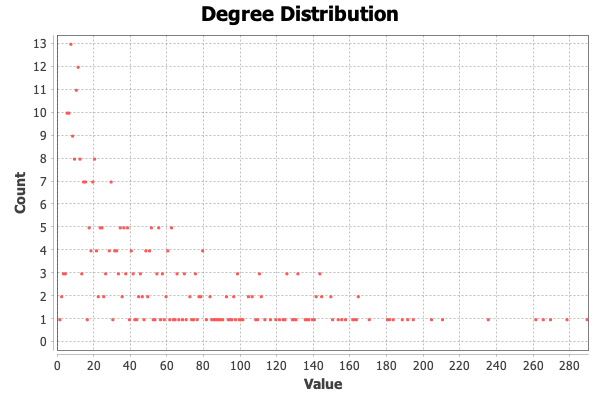

Looking at the degree distribution of the ingredients, we can see that the degrees range from 1 to 289 degrees. Most ingredients fall under 140 degrees, but even then, we can tell that the ingredients are highly connected with each other - most have over one adjacent edges. Using Gephi, to no surprise, the ingredients with the highest degrees are your common ingredients like `salt`, `egg`, `butter`, `white sugar`. On the other end of the spectrum, you have ingredients that are not as prominent in recipes like `creole seasoning`, `cocktail sauce`, and `maple flavored extract`. Either way, this is great that each node as at least one neighbour which will allow the ingredient recommender to find suggestions.

The average path length is 1.9 which means that ingredients, on average, are just 2 degrees apart which reconfirms the closeness of the ingredients and how interconnected the network is. 

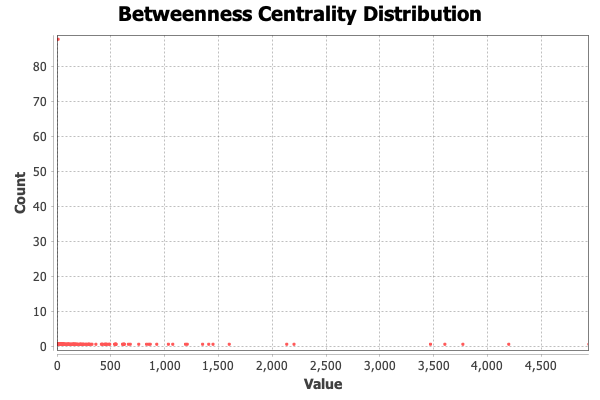

In [4]:
# looking at the betweenness centrality of ingredients
nx.betweenness_centrality(G)

{'amaretto': 7.380089015234404e-06,
 'almond': 0.0040638265006898745,
 'anise': 0.00017665060630375274,
 'apple': 0.004249190861004351,
 'apple juice': 0.0008347312003926853,
 'applesauce': 0.0017891599300909387,
 'apricot': 0.00047530645746725927,
 'artificial sweetener': 1.606693343235805e-05,
 'baking powder': 0.008971859711844768,
 'baking soda': 0.008991009400807187,
 'banana': 0.0006888348593707506,
 'beer': 0.0001688073475378946,
 'black pepper': 0.02109423937565276,
 'blueberry': 0.00016915531947396325,
 'brandy': 0.00046092198063235466,
 'brown rice': 0.0003672074088890452,
 'brown sugar': 0.017580351233532136,
 'butter': 0.05265409722376387,
 'buttermilk': 0.0015186341773209709,
 'cake': 0.0019509106059945544,
 'cardamom': 9.309966051110649e-05,
 'carrot': 0.00604126257517427,
 'cereal': 0.00033652781113027296,
 'cheddar': 0.007900889881747156,
 'cheese': 0.007815179316099893,
 'cherry': 0.006374167737755641,
 'chicken broth': 0.002455056260593925,
 'chocolate': 0.01343378396

In [5]:
# sort ingredients by betweennss centrality
{k:round(v,3) for k,v in sorted(nx.betweenness_centrality(G).items(), key=lambda item: item[1], reverse=True)}

{'salt': 0.072,
 'egg': 0.061,
 'flour': 0.055,
 'butter': 0.053,
 'white sugar': 0.051,
 'milk': 0.032,
 'onion': 0.031,
 'pepper': 0.023,
 'black pepper': 0.021,
 'vegetable oil': 0.021,
 'garlic': 0.02,
 'brown sugar': 0.018,
 'vanilla': 0.017,
 'ham': 0.016,
 'olive': 0.015,
 'chocolate': 0.013,
 'lemon juice': 0.013,
 'cinnamon': 0.012,
 'sour cream': 0.012,
 'potato': 0.011,
 'whipping cream': 0.01,
 'bread': 0.01,
 'cream cheese': 0.009,
 'baking soda': 0.009,
 'baking powder': 0.009,
 'bacon': 0.009,
 'tomato': 0.009,
 'cheddar': 0.008,
 'nutmeg': 0.008,
 'cheese': 0.008,
 'sugar': 0.008,
 'walnut': 0.008,
 'cream': 0.008,
 'parsley': 0.007,
 'ginger': 0.007,
 'margarine': 0.007,
 'mushroom': 0.007,
 'lemon': 0.007,
 'cherry': 0.006,
 'sausage': 0.006,
 'carrot': 0.006,
 'pecan': 0.006,
 'celery': 0.006,
 'honey': 0.005,
 'raisin': 0.005,
 'cornstarch': 0.004,
 'apple': 0.004,
 'yeast': 0.004,
 'beef': 0.004,
 'almond': 0.004,
 'bell pepper': 0.004,
 'vinegar': 0.004,
 'chicken

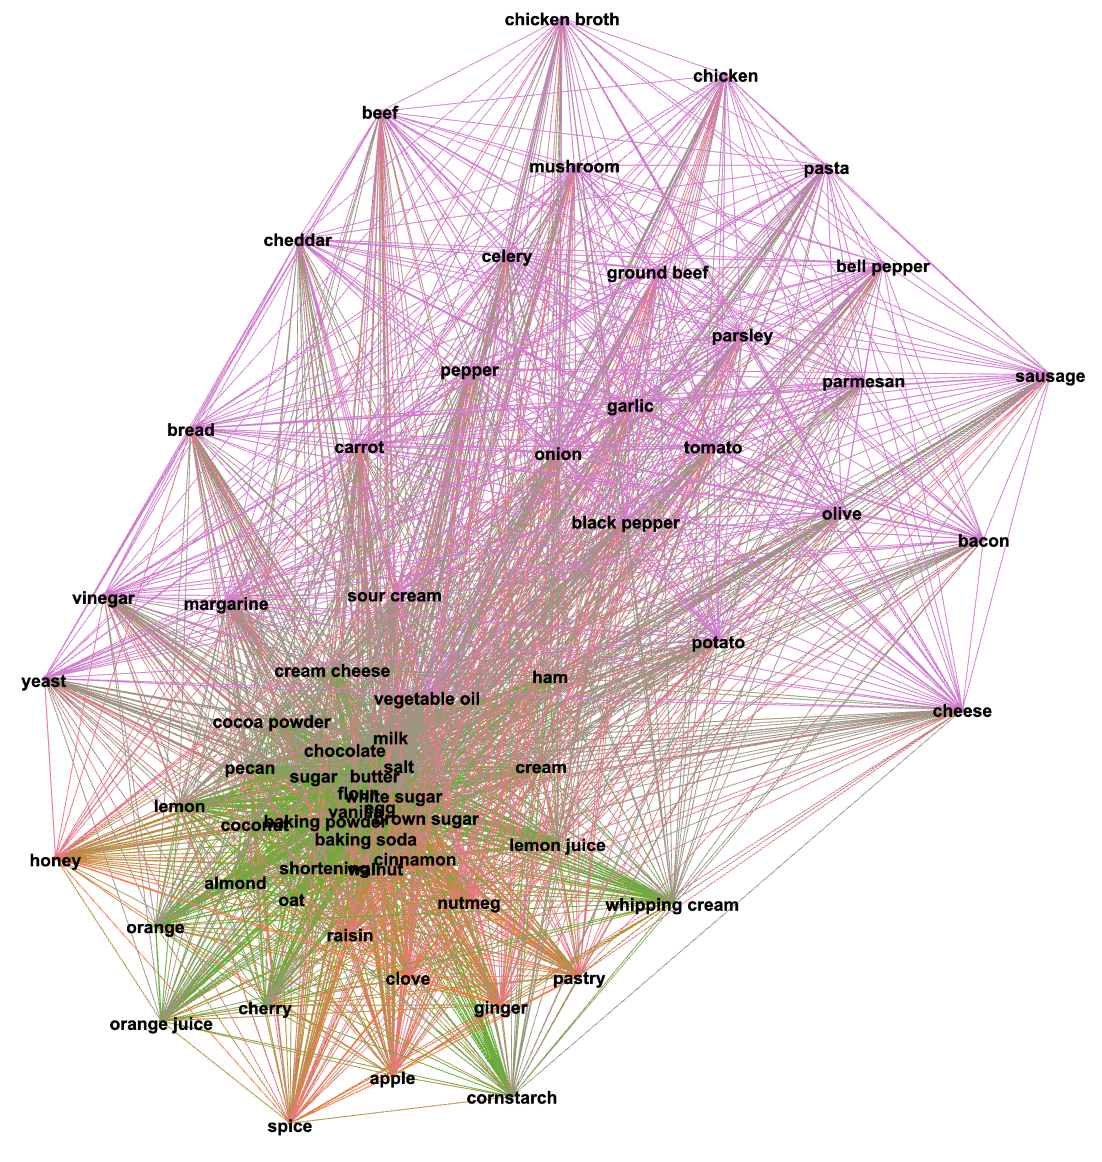

Looking at the network communities, it is very interesting to see that there are really 3 main communities or groupings of ingredients: those that are common in mains (purple), those common in desserts (green) and neutral ingredients that are common across recipes like vegetable oil, honey, spice. Looking at the betweenness centrality, it looks like these ingredients acts as that bridge between the the two larger communities.

This also goes back to the idea of using network analysis as a back up ingredient recommender because we can tell by the topography that the nearest ingredients are usually falls into the same categories or types of meals.

To determine if I will need another fall back in case not every ingredient has a neighbour, I will check if the network is fully connected. If so, then I will not need to worry aboout finding a backup recommender for isolated ingredients. 

In [153]:
# check if network is fully connected
nx.is_connected(G)

True

In [156]:
list(nx.find_cliques(G))

[['whipped topping mix',
  'milk',
  'sugar',
  'vegetable oil',
  'flour',
  'cream cheese',
  'butter',
  'white sugar',
  'egg',
  'cake',
  'vanilla',
  'pecan',
  'walnut',
  'cherry',
  'coconut',
  'chocolate',
  'lemon',
  'strawberry'],
 ['whipped topping mix',
  'milk',
  'sugar',
  'vegetable oil',
  'flour',
  'cream cheese',
  'butter',
  'white sugar',
  'egg',
  'cake',
  'vanilla',
  'pecan',
  'walnut',
  'cherry',
  'coconut',
  'chocolate',
  'lemon',
  'coffee'],
 ['whipped topping mix',
  'milk',
  'sugar',
  'vegetable oil',
  'flour',
  'cream cheese',
  'butter',
  'white sugar',
  'egg',
  'cake',
  'vanilla',
  'pecan',
  'walnut',
  'cherry',
  'coconut',
  'chocolate',
  'lemon',
  'pistachio'],
 ['whipped topping mix',
  'milk',
  'sugar',
  'vegetable oil',
  'flour',
  'cream cheese',
  'butter',
  'white sugar',
  'egg',
  'cake',
  'vanilla',
  'pecan',
  'walnut',
  'cherry',
  'coconut',
  'chocolate',
  'peanut butter'],
 ['whipped topping mix',
  'm

For this part of the recommender, I would like the recommender to recommend the neighbouring ingredient randomly by the proportional weights. To achieve this, I will leverage Pandas DataFrames by having the neighbours and respective weights as the columns. This DataFrame will then be sorted in descending order by weights and recommendations will be made randomly based on weights.

In [151]:
# check neighbours for sample ingredient: yeast
list(G.neighbors('yeast'))

['almond',
 'anise',
 'apple',
 'applesauce',
 'apricot',
 'baking powder',
 'baking soda',
 'banana',
 'barley',
 'basil',
 'beef',
 'beer',
 'black pepper',
 'blueberry',
 'bran',
 'bread',
 'brown rice',
 'brown sugar',
 'butter',
 'buttermilk',
 'candy',
 'caramel',
 'caraway',
 'cardamom',
 'carrot',
 'celery',
 'cereal',
 'cheddar',
 'cheese',
 'cherry',
 'chili',
 'cinnamon',
 'citron',
 'cocoa powder',
 'coffee',
 'corn syrup',
 'cornmeal',
 'cornstarch',
 'cottage cheese',
 'cream',
 'cumin',
 'currant',
 'dill',
 'egg',
 'fennel',
 'flour',
 'fruit',
 'garlic',
 'gelatin',
 'ghee',
 'ginger',
 'gluten',
 'granola',
 'honey',
 'italian seasoning',
 'kosher',
 'lard',
 'lecithin',
 'lemon',
 'lemon juice',
 'macadamia nut',
 'mace',
 'margarine',
 'milk',
 'molasses',
 'mozzarella',
 'mushroom',
 'nutmeg',
 'oat',
 'olive',
 'onion',
 'orange',
 'orange juice',
 'parmesan',
 'parsley',
 'pastry',
 'pecan',
 'pepper',
 'poppy',
 'potato',
 'pumpkin',
 'quinoa',
 'raisin',
 'red 

In [134]:
# check wegith of sample ingredient, yeast, with sample neighbour, almond 
G.get_edge_data('yeast', 'almond')['weight']

0.0010354646647683149

In [129]:
# create df of neighbours to sample ingredient, yeast
neighbours_df = pd.DataFrame(list(G.neighbors('yeast')), columns=['neighbours'])
neighbours_df.head()

neighbours
0      almond
1       anise
2       apple
3  applesauce
4     apricot

In [145]:
# create column with respective weights
neighbours_df['weight'] = neighbours_df['neighbours'].apply(lambda x: G.get_edge_data('yeast', x)['weight'])

# sort df in descending order by weight
neighbours_df.sort_values('weight', ascending=False, inplace=True)

# reset index
neighbours_df.reset_index(drop=True, inplace=True)

# check
neighbours_df.head()

neighbours    weight
0         salt  0.024333
1  white sugar  0.019156
2        flour  0.018121
3         milk  0.013979
4          egg  0.012684

In [151]:
# reco top ingredient
neighbours_df.nlargest(1, 'weight').loc[:, 'neighbours']

0    salt
Name: neighbours, dtype: object

In [141]:
# reco based off of random proportioned by weight
neighbours_df.sample(1, weights='weight').loc[:,'neighbours']

12    black pepper
Name: neighbours, dtype: object

Now, that we were able to successfully do that, next is to create the recommender based on a user input to return the neighbour. Following that, is to add it to our existing recommender, as a fallback in case the user input is not part of the association rules at all. As recall, the current recommender is as follows:

In [ ]:
# take user input
xyz = input('What ingredients would you like to add to your shopping cart?\
            \nPlease separate ingredients with a comma. \n')


# original ingredients input as list
xyz_split = xyz.lower().split(', ')

# sort ingredients input to match association rules
ingredients = sort_ingredients(xyz)

# setting variable for nested while loop
index_num = 0

# check if ingredients inputted matches antecedents in association rules
if (rules['antecedents'] == ingredients).sum() > 0:
    # random consequent output
    print(f'{xyz} have been added to your shopping cart. We also think you would enjoy the following item(s) as well:')
    # make recommendation
    item_reco = rules[rules['antecedents'] == xyz_split[index_num]]['consequents'].sample(1)
    display(item_reco)
    # offer to add recommendations to basket
    response = input('Would you like us to add these items to your basket? (Y/N)?')
    # add recommendations to basket if user says Y
    if response == 'Y':
        xyz2 = xyz + ', ' + item_reco
        print('Great, your basket has been updated to:')
        display(xyz2)
    # no changes to basket
    else: 
        print('No problem. Your basket remains as:')
        display(xyz)
else:
    # random ingredient from list of input ingredients
    while index_num < len(xyz.split(', ')):
        # check if individual ingredient is part of association rules or if we have exhausted all ingredients in 
        # the list, if so then break out of loop
        if (rules['antecedents'] == xyz_split[index_num]).sum() > 0 or index_num == (len(xyz_split) - 1):
            break
        else:
            # if ingredient not part of association rules then check next ingredient in list 
            index_num += 1
    
    if (rules['antecedents'] == xyz_split[index_num]).sum() > 0: 
        # random consequent output
        print(f'{xyz} have been added to your shopping cart. We also think you would enjoy the following item(s) as well:')
        # make recommendation
        item_reco = rules[rules['antecedents'] == xyz_split[index_num]]['consequents'].sample(1)
        display(item_reco)
        # offer to add recommendations to basket
        response = input('Would you like us to add these items to your basket? (Y/N)?')
        # add recommendations to basket if user says Y
        if response == 'Y':
            xyz2 = xyz + ', ' + item_reco
            print('Great, your basket has been updated to:')
            display(xyz2)
        # no changes to basket
        else: 
            print('No problem. Your basket remains as:')
            display(xyz)
    else: 
        print('Sorry, I got nothing to offer you.')
    
# rules[rules['antecedents'] == ingredients]

What ingredients would you like to add to your shopping cart?            
Please separate ingredients with a comma. 
ginger
ginger have been added to your shopping cart. We also think you would enjoy the following item(s) as well:


944    clove, egg, flour
Name: consequents, dtype: object

In [165]:
list(nx.nodes(G))

['amaretto',
 'almond',
 'anise',
 'apple',
 'apple juice',
 'applesauce',
 'apricot',
 'artificial sweetener',
 'baking powder',
 'baking soda',
 'banana',
 'beer',
 'black pepper',
 'blueberry',
 'brandy',
 'brown rice',
 'brown sugar',
 'butter',
 'buttermilk',
 'cake',
 'cardamom',
 'carrot',
 'cereal',
 'cheddar',
 'cheese',
 'cherry',
 'chicken broth',
 'chocolate',
 'cinnamon',
 'citron',
 'clove',
 'cocoa',
 'cocoa powder',
 'coconut',
 'coffee',
 'cookies',
 'corn syrup',
 'cornstarch',
 'cranberry',
 'cranberry sauce',
 'cream',
 'cream cheese',
 'currant',
 'date',
 'egg',
 'fig',
 'flour',
 'food coloring',
 'fruit',
 'gelatin',
 'ginger',
 'golden syrup',
 'ham',
 'hazelnut',
 'honey',
 'ice cream',
 'lard',
 'lemon',
 'lemon juice',
 'liqueur',
 'mace',
 'margarine',
 'marshmallow',
 'milk',
 'molasses',
 'multicolored sprinkles (jimmies',
 'mushroom',
 'nectarine',
 'noodle',
 'nut',
 'nutmeg',
 'oat',
 'olive',
 'onion',
 'orange',
 'orange juice',
 'pancake',
 'pastry'

In [174]:
# list of nodes in network
nodes_list = list(nx.nodes(G))

for i in range(len(xyz_split)):
    if xyz_split[i] in nodes_list:
        # create df of neighbours to sample ingredient, yeast
        neighbours_df = pd.DataFrame(list(G.neighbors(xyz_split[i])), columns=['neighbours'])

        # create column with respective weights
        neighbours_df['weight'] = neighbours_df['neighbours'].apply(lambda x: G.get_edge_data(xyz_split[i], x)['weight'])

        # sort df in descending order by weight
        neighbours_df.sort_values('weight', ascending=False, inplace=True)

        # reset index
        neighbours_df.reset_index(drop=True, inplace=True)
        
        break
    
    else:
        # if all the ingredients fails every step, then a random ingredient will be suggested
        random.choice(nodes_list)
    
# reco based off of random proportioned by weight
display(neighbours_df.sample(1, weights='weight').loc[:,'neighbours'])

2    egg
Name: neighbours, dtype: object

Plugging the whole code back into our current ingredeint recommender. 

In [176]:
# take user input
xyz = input('What ingredients would you like to add to your shopping cart?\
            \nPlease separate ingredients with a comma. \n')


# original ingredients input as list
xyz_split = xyz.lower().split(', ')

# sort ingredients input to match association rules
ingredients = sort_ingredients(xyz)

# setting variable for nested while loop
index_num = 0

# list of nodes in network
nodes_list = list(nx.nodes(G))

# check if ingredients inputted matches antecedents in association rules
if (rules['antecedents'] == ingredients).sum() > 0:
    # random consequent output
    print(f'{xyz} have been added to your shopping cart. We also think you would enjoy the following item(s) as well:')
    # make recommendation
    item_reco = rules[rules['antecedents'] == xyz_split[index_num]]['consequents'].sample(1)
    display(item_reco)
    # offer to add recommendations to basket
    response = input('Would you like us to add these items to your basket? (Y/N)?')
    # add recommendations to basket if user says Y
    if response == 'Y':
        xyz2 = xyz + ', ' + item_reco
        print('Great, your basket has been updated to:')
        display(xyz2)
    # no changes to basket
    else: 
        print('No problem. Your basket remains as:')
        display(xyz)
else:
    # random ingredient from list of input ingredients
    while index_num < len(xyz.split(', ')):
        # check if individual ingredient is part of association rules or if we have exhausted all ingredients in 
        # the list, if so then break out of loop
        if (rules['antecedents'] == xyz_split[index_num]).sum() > 0 or index_num == (len(xyz_split) - 1):
            break
        else:
            # if ingredient not part of association rules then check next ingredient in list 
            index_num += 1
    
    if (rules['antecedents'] == xyz_split[index_num]).sum() > 0: 
        # random consequent output
        print(f'{xyz} have been added to your shopping cart. We also think you would enjoy the following item(s) as well:')
        # make recommendation
        item_reco = rules[rules['antecedents'] == xyz_split[index_num]]['consequents'].sample(1)
        display(item_reco)
        # offer to add recommendations to basket
        response = input('Would you like us to add these items to your basket? (Y/N)?')
        # add recommendations to basket if user says Y
        if response == 'Y':
            xyz2 = xyz + ', ' + item_reco
            print('Great, your basket has been updated to:')
            display(xyz2)
        # no changes to basket
        else: 
            print('No problem. Your basket remains as:')
            display(xyz)
    else: 
        for i in range(len(xyz_split)):
            if xyz_split[i] in nodes_list:
                # create df of neighbours to sample ingredient, yeast
                neighbours_df = pd.DataFrame(list(G.neighbors(xyz_split[i])), columns=['neighbours'])

                # create column with respective weights
                neighbours_df['weight'] = neighbours_df['neighbours'].apply(lambda x: G.get_edge_data(xyz_split[i], x)['weight'])

                # sort df in descending order by weight
                neighbours_df.sort_values('weight', ascending=False, inplace=True)

                # reset index
                neighbours_df.reset_index(drop=True, inplace=True)

                break

            else:
                # if all the ingredients fails every step, then a random ingredient will be suggested
                random.choice(nodes_list)
    
# reco based off of random proportioned by weight
display(neighbours_df.sample(1, weights='weight').loc[:,'neighbours'])
    

What ingredients would you like to add to your shopping cart?            
Please separate ingredients with a comma. 
zucchini


30    date
Name: neighbours, dtype: object

Now, that we have created the recommender for the ingredients portion of the recommender system. The next step is to create our recipe recommender, based off the input of the user ID and their selected ingredients.

This is where I will utilize Surprise to build the model to predict users' ratings and suggest recipes that the user will like. 

## <a id="model">Modelling</a>

### <a id="base_models">Base Models</a>

Using the Dataset module in the surprise package, we will load in the cleaned reviews data into the format required by surprise. The order of our columns is user, item, rating, which we will input as the line_format upon reading in the data. Since we binarized the ratings, the rating scale will be 0-1.

In [3]:
# read in clean reviews data to see what we are working with 
reviews_df = pd.read_csv('clean_reviews.csv')
reviews_df.head()

profile_id  recipe_id  rate
0     1153011       7246     1
1     1153011       7269     0
2     1153011       7303     1
3     1153011       7306     1
4     1153011       7307     1

In [4]:
# check size of dataset
reviews_df.shape

(90165, 3)

In [5]:
# number of users
len(reviews_df['profile_id'].unique())

17210

In [6]:
# number of recipes
len(reviews_df['recipe_id'].unique())

1724

In [5]:
# setup reader parameters 

reader = Reader(line_format='user item rating', rating_scale=(0, 1), skip_lines=1, sep=',')


In [6]:
# loading frm csv
reviews_data = Dataset.load_from_file('clean_reviews.csv', reader=reader)

# check
reviews_data

The Surprise package offers many different alogorithms to train our model on. As such, as a baseline, I will be running a base model on a plethora of models that is offered. These include: `BaselineOnly`, `SVD`, `SVDpp`, `KNNBasic`, `KNNWithMeans`, `KNNWithZScore`, `KNNBaseline`, `SlopeOne`, and `CoClustering`. These will be measured on on 3 parameters: `RMSE` (Root Mean Squared of Error), `MAE` (Mean Absolute Error), and `MSE` (Mean Squared Error). 

Once we have the scores of each base model, we can review them on the measurements and determine which model, overall, has the lowest score between the 3 measurements. From there, I will perform a grid search over the best base model to find the optimal hyperparameters.

In [105]:
%%time

# set up base models
algos = [BaselineOnly(), SVD(), SVDpp(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), KNNBaseline(), SlopeOne(),\
         CoClustering()]

scores_df = pd.DataFrame()

for algo in algos:
    # for each model, we will check RMSE, MAE and MSE scores on 5 folds
    scores = cross_validate(algo, reviews_data, measures=['RMSE', 'MAE', 'MSE'], cv=5, verbose=True)
    
    # we will append the mean scores of each metric to the dataframe
    scores_df[algo] = pd.DataFrame.from_dict(scores).mean(axis=0)

# check
scores_df

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE, MSE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4564  0.4542  0.4528  0.4536  0.4568  0.4548  0.0016  
MAE (testset)     0.4166  0.4147  0.4142  0.4142  0.4166  0.4152  0.0011  
MSE (testset)     0.2083  0.2063  0.2050  0.2058  0.2086  0.2068  0.0014  
Fit time          0.28    0.29    0.36    0.34    0.31    0.32    0.03    
Test time         0.12    0.11    0.16    0.11    0.13    0.12    0.02    
Evaluating RMSE, MAE, MSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4637  0.4624  0.4638  0.4610  0.4595  0.4621  0.0016  
MAE (testset)     0.4111  0.4090  0.4105  0.4078  0.4066  0.4090  0.0017  
MSE (testset)     0.2151  0.2138  0.2151  0

<surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x1a337cff50>  \
test_rmse                                           0.454764                                    
test_mae                                            0.415224                                    
test_mse                                            0.206813                                    
fit_time                                            0.315726                                    
test_time                                           0.123530                                    

           <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x1a337f6050>  \
test_rmse                                           0.462096                                  
test_mae                                            0.408999                                  
test_mse                                            0.213536                                  
fit_time                                            4.933702                                  
test_time                                           0.306679                                  

           <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x1a337f6090>  \
test_rmse                                           0.455981                                    
test_mae                                            0.403174                                    
test_mse                                            0.207919                                    
fit_time                                           19.183354                                    
test_time                                           0.551925                                    

           <surprise.prediction_algorithms.knns.KNNBasic object at 0x1a337f60d0>  \
test_rmse                                           0.520542                       
test_mae                                            0.432168                       
test_mse                                            0.270969                       
fit_time                                           32.800325                       
test_time                                           4.189376                       

           <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x1a337f6110>  \
test_rmse                                           0.512735                           
test_mae                                            0.391802                           
test_mse                                            0.262907                           
fit_time                                           31.880533                           
test_time                                           3.397628                           

           <surprise.prediction_algorithms.knns.KNNWithZScore object at 0x1a337f6150>  \
test_rmse                                           0.513263                            
test_mae                                            0.391200                            
test_mse                                            0.263446                            
fit_time                                           33.593514                            
test_time                                           3.595699                            

           <surprise.prediction_algorithms.knns.KNNBaseline object at 0x1a337f6190>  \
test_rmse                                           0.498760                          
test_mae                                            0.415162                          
test_mse                                            0.248762                          
fit_time                                           28.904111                          
test_time                                           3.534178                          

           <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x1a337f61d0>  \
test_rmse                                           0.532138                            
test

In [106]:
# rename columns
scores_df.columns = ['BaselineOnly', 'SVD', 'SVDpp', 'KNNBasic', 'KNNWithMeans', 'KNNWithZScore', 'KNNBaseline()',\
                    'SlopeOne', 'CoClustering']

# check
scores_df

BaselineOnly       SVD      SVDpp   KNNBasic  KNNWithMeans  \
test_rmse      0.454764  0.462096   0.455981   0.520542      0.512735   
test_mae       0.415224  0.408999   0.403174   0.432168      0.391802   
test_mse       0.206813  0.213536   0.207919   0.270969      0.262907   
fit_time       0.315726  4.933702  19.183354  32.800325     31.880533   
test_time      0.123530  0.306679   0.551925   4.189376      3.397628   

           KNNWithZScore  KNNBaseline()  SlopeOne  CoClustering  
test_rmse       0.513263       0.498760  0.532138      0.502467  
test_mae        0.391200       0.415162  0.400790      0.384385  
test_mse        0.263446       0.248762  0.283173      0.252478  
fit_time       33.593514      28.904111  0.401583      3.871469  
test_time       3.595699       3.534178  0.615568      0.123166

In [107]:
# transpose 
socres_df = scores_df.T

In [109]:
# best scores 
# lower RMSE indicates better fit and how accurately model predicts the response 
# larger MSE means data is widely ranged around mean, lower is better
# MAE tells us how big the error is between forecasted value and acual value

scores_df['best_model'] = scores_df.min(1)

# check
scores_df

BaselineOnly       SVD      SVDpp   KNNBasic  KNNWithMeans  \
test_rmse      0.454764  0.462096   0.455981   0.520542      0.512735   
test_mae       0.415224  0.408999   0.403174   0.432168      0.391802   
test_mse       0.206813  0.213536   0.207919   0.270969      0.262907   
fit_time       0.315726  4.933702  19.183354  32.800325     31.880533   
test_time      0.123530  0.306679   0.551925   4.189376      3.397628   

           KNNWithZScore  KNNBaseline()  SlopeOne  CoClustering  best_model  
test_rmse       0.513263       0.498760  0.532138      0.502467    0.454764  
test_mae        0.391200       0.415162  0.400790      0.384385    0.384385  
test_mse        0.263446       0.248762  0.283173      0.252478    0.206813  
fit_time       33.593514      28.904111  0.401583      3.871469    0.315726  
test_time       3.595699       3.534178  0.615568      0.123166    0.123166

In [110]:
# pickle scores_df
joblib.dump(scores_df, "scores_df.pkl")

['scores_df.pkl']

### <a id="gridsearch">Gridsearch</a>  

Based on the results that we got from fitting the trainset on each base model, the best model (determined by achieving the lowest scores amongst the 3 measurements) is the BaselineOnly model. The BaselineOnly model had the best score in terms of RMSE and MSE. RMSE is the more important measurement out of the three as it indicates how well the fit is and how accurate the model is to predict the correct response. 

Additionally, `CoClustering` scored the best in terms of MAE, so we will also perform a gridsearch on this model. Once hyperparameters are tuned for both models, we will check again to see which has the better RMSE score and take that as our final model. 

In [8]:
np.arange(0,0.11,0.01)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

In [10]:
# set up param grid for ALS and SGD methods for the BaselineOnly model
# als - alternating least squares
# reg_i regularization parameter for items
# reg_u regularization parameter for users
param_grid_als = {'bsl_options': {'method':['als'], 'n_epochs': np.arange(1,21,5), 'reg_i': np.arange(1,51,5),
              'reg_u': np.arange(1,51,5)}}

# sgd - stochastic gradient descent 
# reg reguarization parameter of cost function 
param_grid_sgd = {'bsl_options': {'method':['sgd'], 'reg': np.arange(0,0.11,0.01),'n_epochs': np.arange(1,21,5), 'learning_rate':np.arange(0,0.011,0.001)}}

In [12]:
%%time 
# gridsearch for BaselineOnly model with ALS method

baseline_als_gs = GridSearchCV(BaselineOnly, param_grid_als, measures=['rmse', 'mae'], cv=5, n_jobs=-1, joblib_verbose=10)

baseline_als_gs.fit(reviews_data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  4

CPU times: user 52min 32s, sys: 42.6 s, total: 53min 14s
Wall time: 53min 50s


[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 53.8min finished


In [13]:
# pickle baseline_gs
joblib.dump(baseline_als_gs, "baseline_als_gs.pkl")

['baseline_als_gs.pkl']

In [9]:
# load baseline_gs
baseline_als_gs = joblib.load("baseline_als_gs.pkl")

In [32]:
# best score
baseline_als_gs.best_score

{'rmse': 0.45299285330099315, 'mae': 0.3880184583189629}

In [33]:
# optimal parameters
baseline_als_gs.best_params

{'rmse': {'bsl_options': {'method': 'als',
   'n_epochs': 16,
   'reg_i': 16,
   'reg_u': 6}},
 'mae': {'bsl_options': {'method': 'als',
   'n_epochs': 16,
   'reg_i': 1,
   'reg_u': 1}}}

In [14]:
%%time 
# gridsearch for BaselineOnly model with SGD method

baseline_sgd_gs = GridSearchCV(BaselineOnly, param_grid_sgd, measures=['rmse', 'mae'], cv=5, n_jobs=-1, joblib_verbose=10)

baseline_sgd_gs.fit(reviews_data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  4

CPU times: user 1h 3min 17s, sys: 43.6 s, total: 1h 4min
Wall time: 1h 4min 39s


[Parallel(n_jobs=-1)]: Done 2420 out of 2420 | elapsed: 64.6min finished


In [15]:
# pickle baseline_gs
joblib.dump(baseline_sgd_gs, "baseline_sgd_gs.pkl")

['baseline_sgd_gs.pkl']

In [29]:
# load baseline_gs
baseline_sgd_gs = joblib.load("baseline_sgd_gs.pkl")

In [11]:
# best score
baseline_sgd_gs.best_score

{'rmse': 0.4537910958116057, 'mae': 0.40030346904479996}

In [12]:
# optimal parameters
baseline_sgd_gs.best_params

{'rmse': {'bsl_options': {'method': 'sgd',
   'reg': 0.1,
   'n_epochs': 16,
   'learning_rate': 0.006}},
 'mae': {'bsl_options': {'method': 'sgd',
   'reg': 0.0,
   'n_epochs': 16,
   'learning_rate': 0.01}}}

Now to conduct a gridsearch of the dataset on a CoClustering model as that was identified as the model that had the best MAE score.

In [16]:
# set up param grid for ALS and SGD methods for the BaselineOnly model
# n_cltr_u = number of user clusters
# n_cltr_i = number of item clusters

param_grid_cc = {'n_cltr_u':np.arange(1,11,1), 'n_cltr_i': np.arange(1,11,1), 'n_epochs': np.arange(1,21,5)}

In [17]:
# gridsearch for CoClustering model

cocluster_gs = GridSearchCV(CoClustering, param_grid_cc, measures=['rmse', 'mae'], cv=5, n_jobs=-1, joblib_verbose=10)

cocluster_gs.fit(reviews_data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  5

In [18]:
# pickle baseline_gs
joblib.dump(cocluster_gs, "cocluster_gs.pkl")

['cocluster_gs.pkl']

In [13]:
# load cocluster_gs
cocluster_gs = joblib.load("cocluster_gs.pkl")

In [14]:
# best score
cocluster_gs.best_score

{'rmse': 0.4947200943033895, 'mae': 0.3811994248211367}

In [15]:
# optimal parameters
cocluster_gs.best_params

{'rmse': {'n_cltr_u': 1, 'n_cltr_i': 1, 'n_epochs': 1},
 'mae': {'n_cltr_u': 1, 'n_cltr_i': 2, 'n_epochs': 1}}

Based on the 3 gridsearches performed above, from BaselineOnly model with ALS and SGD methods and also CoClustering model, the BaselineOnly model with ALS method returned with the best RMSE score. In some instances, the difference in scores between the 3 models is not huge. When it comes to MAE score, the CoClustering model performed the best, however only by a difference of about 0.007 whereas the RMSE score was higher than the the best BaselineOnly model by 0.042. 

For the fact that we are applying greater weight to the RMSE score over the MAE score and also because the difference is much higher in RMSE scores, I will proceed with the BaselineOnly model with ALS method.

I should also note that, comparing these tuned models to the base models, the difference in scores is also not large, but better nonetheless. For example, the base model for the BaselineOnly model was 0.4548 whereas the model with the best parameters is 0.4530.

Next I will perform another gridserach with more granular parameters around the best parameters that were discovered in our initial BaselineOnly gridsearch. The hope is that we can achieve more optimized hyperparameters, thus a better RMSE score.

In [16]:
# setting u parameters for more in depth gridsearch
param_grid_als = {'bsl_options': {'method':['als'], 'n_epochs': np.arange(14,20,1), 'reg_i': np.arange(13,20,1),
              'reg_u': np.arange(3,10,1)}}

In [17]:
%%time 
# gridsearch for BaselineOnly model with ALS method

baseline_als_gs = GridSearchCV(BaselineOnly, param_grid_als, measures=['rmse', 'mae'], cv=5, n_jobs=-1, joblib_verbose=10)

baseline_als_gs.fit(reviews_data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  8

CPU times: user 50min 23s, sys: 1min 9s, total: 51min 32s
Wall time: 1h 4min 33s


[Parallel(n_jobs=-1)]: Done 1470 out of 1470 | elapsed: 64.5min finished


In [18]:
# pickle baseline_gs
joblib.dump(baseline_als_gs, "baseline_als_gs2.pkl")

['baseline_als_gs2.pkl']

In [3]:
# load baseline_gs
baseline_als_gs2 = joblib.load("baseline_als_gs2.pkl")

In [4]:
# best score
baseline_als_gs2.best_score

{'rmse': 0.4532018275017119, 'mae': 0.3998869238009824}

After performing the refined gridsearch on the BaselineOnly model with ALS method, I actually ended up with a higher RMSE score. For this reason, I will be sticking with the parameters from the original gridsearch and that is: `n_epochs`: 16, `reg_i`: 16, `reg_u`: 6. This tuned model also requres less epochs.

In [34]:
# optimal parameters
baseline_als_gs.best_params

{'rmse': {'bsl_options': {'method': 'als',
   'n_epochs': 16,
   'reg_i': 16,
   'reg_u': 6}},
 'mae': {'bsl_options': {'method': 'als',
   'n_epochs': 16,
   'reg_i': 1,
   'reg_u': 1}}}

In [35]:
# full results
baseline_als_gs.cv_results

{'split0_test_rmse': array([0.46684598, 0.45434457, 0.45530382, 0.45660941, 0.45770655,
        0.45859459, 0.45931938, 0.45992005, 0.46042556, 0.46085694,
        0.46606806, 0.45297239, 0.45389602, 0.45520224, 0.45630649,
        0.4572026 , 0.45793494, 0.45854246, 0.45905413, 0.45949104,
        0.46609315, 0.45268655, 0.45359912, 0.45490841, 0.45601766,
        0.45691889, 0.45765602, 0.45826787, 0.45878345, 0.45922388,
        0.46628216, 0.45267517, 0.45357928, 0.45489047, 0.45600308,
        0.45690777, 0.45764812, 0.45826291, 0.45878113, 0.45922393,
        0.4665189 , 0.45276364, 0.45366065, 0.45497317, 0.4560882 ,
        0.45699541, 0.45773811, 0.45835504, 0.45887519, 0.45931973,
        0.46676449, 0.45289348, 0.45378434, 0.45509779, 0.45621466,
        0.45712378, 0.45786828, 0.45848684, 0.45900846, 0.45945433,
        0.46700506, 0.45304012, 0.45392605, 0.45524016, 0.45635846,
        0.45726908, 0.458015  , 0.45863485, 0.45915763, 0.45960454,
        0.46723765, 0.453192

In [52]:
# make df out of gridsearch result rankings

gridsearch_df = pd.DataFrame(baseline_als_gs.cv_results['rank_test_rmse'], columns=['rank'])
gridsearch_df

rank
0     379
1      92
2     116
3     172
4     224
..    ...
395   196
396   242
397   285
398   325
399   346

[400 rows x 1 columns]

In [51]:
# finding the search that ranked 1
gridsearch_df[gridsearch_df['rank']==1]

rank
331     1

In [36]:
# mean RMSE scores per grid search
baseline_als_gs.cv_results['mean_test_rmse']

array([0.46803574, 0.45522826, 0.45596071, 0.4571551 , 0.45818832,
       0.4590364 , 0.45973447, 0.46031671, 0.46080909, 0.46123097,
       0.46709648, 0.45358255, 0.45427996, 0.45547776, 0.45652002,
       0.45737776, 0.4580851 , 0.45867577, 0.45917573, 0.45960445,
       0.46704773, 0.45319076, 0.45388307, 0.45508711, 0.45613645,
       0.45700062, 0.45771368, 0.45830941, 0.45881397, 0.45924679,
       0.46719585, 0.45311803, 0.45380651, 0.45501417, 0.45606806,
       0.45693658, 0.45765353, 0.4582527 , 0.45876033, 0.45919587,
       0.46740524, 0.45316424, 0.45384927, 0.45505968, 0.45611688,
       0.45698852, 0.45770829, 0.45830996, 0.4588198 , 0.45925732,
       0.46763259, 0.4532623 , 0.45394436, 0.4551568 , 0.45621649,
       0.45709051, 0.45781241, 0.45841599, 0.45892751, 0.45936653,
       0.46785812, 0.45338422, 0.4540637 , 0.45527767, 0.4563393 ,
       0.45721518, 0.45793876, 0.45854383, 0.45905668, 0.45949688,
       0.46807754, 0.45351676, 0.45419399, 0.45540913, 0.45647

To visualize what the average RMSE score was per search, I will plot this on a line graph and see if there are any noticeable patterns.

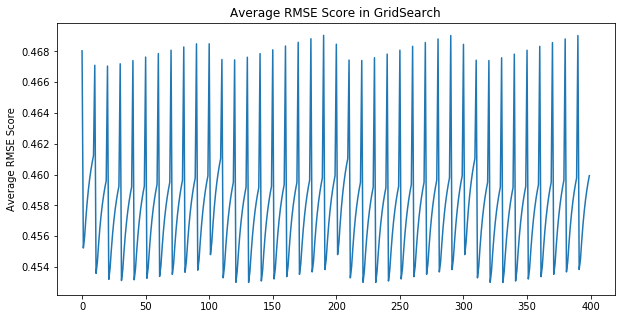

In [40]:
# plot 
plt.figure(figsize=(10,5))
plt.plot(baseline_als_gs.cv_results['mean_test_rmse'])
plt.title('Average RMSE Score in GridSearch')
plt.ylabel('Average RMSE Score')
plt.show()

Based on the line graph above, it looks like the RMSE scores went through repeated cycles ranging between 0.452 and 0.47. What I can see here is that model is very sensitive and the slightest change to the parameters can cause a huge difference in how the model performs. Even though the scores constantly fluctuated, we achieve the best overall RMSE score at 332nd search. 

Now that we have found our optimal hyperparameters, I will make this the final model and fit the full trainset to it so that the model can perform at its best, in other words, having the highest predictability of user/time scores.

### <a id="finalmodel">Final Model</a> 

In [7]:
# build full trainset
full_trainset = reviews_data.build_full_trainset()
full_trainset

In [10]:
# using best_estimator function, we can call on the optimal parameters that were found 
# Instantiate model with best RMSE score
bs_algo = baseline_als_gs.best_estimator['rmse']

# Fit model to full_trainset
bs_algo.fit(full_trainset) 

Estimating biases using als...


Now that the model has been fitted, we can build an anti testset that contains all the recipes that a user has not rated yet. This is what our model will use to make predictions.

In [11]:
# build anti testset
anti_testset = full_trainset.build_anti_testset()

In [12]:
%%time
# making predictions on all user/item combinations that don't have a rating
predictions = bs_algo.test(anti_testset)
predictions

CPU times: user 3min 17s, sys: 1min 45s, total: 5min 2s
Wall time: 6min 25s


[Prediction(uid='1153011', iid='7013', r_ui=0.6565629678921976, est=0.44829276064559487, details={'was_impossible': False}),
 Prediction(uid='1153011', iid='7287', r_ui=0.6565629678921976, est=0.5762108193881077, details={'was_impossible': False}),
 Prediction(uid='1153011', iid='7421', r_ui=0.6565629678921976, est=0.5635602299752724, details={'was_impossible': False}),
 Prediction(uid='1153011', iid='7465', r_ui=0.6565629678921976, est=0.45619102147173834, details={'was_impossible': False}),
 Prediction(uid='1153011', iid='7502', r_ui=0.6565629678921976, est=0.4881478504349859, details={'was_impossible': False}),
 Prediction(uid='1153011', iid='7534', r_ui=0.6565629678921976, est=0.35964150951704893, details={'was_impossible': False}),
 Prediction(uid='1153011', iid='7550', r_ui=0.6565629678921976, est=0.4466458495426709, details={'was_impossible': False}),
 Prediction(uid='1153011', iid='7562', r_ui=0.6565629678921976, est=0.37757146353398435, details={'was_impossible': False}),
 Pre

In [ ]:
# pickle the predictions
joblib.dump(predictions, "predictions.pkl")

In [64]:
# check accuracy
accuracy.rmse(predictions)

RMSE: 0.1397


0.139713592071889

Surprisingly, based on the anti test we constructed, we got an RMSE score that is close to 0 (0.1397). However, when it comes to recommenders, it difficult to know just how accurate it is. Ideally, we would like to do some A/B testing to confirm or validate that the recommendations are relevant to the user. Instead, what we have done is use gridsearch with 5 folds on each search so that the validation set doubled as the test set. Since we don't have the opportunity to put this in a real life scenario for A/B testing, just comparing it to our model which had an RMSE score of 0.4530, I would like to say that the score we achieved from the predictions is favourable.

Now, that we have the predictions, we can store the information in a DataFrame.

In [14]:
# check number of predictions
len(predictions)

29579882

In [18]:
# check prediction at index 0 
predictions[0]

Prediction(uid='1153011', iid='7013', r_ui=0.6565629678921976, est=0.44829276064559487, details={'was_impossible': False})

In [34]:
# transforming predictions into a list of lists
predictions_list = []

for i in range(len(predictions)):
    # user_id
    uid = predictions[i][0]

    # item_id
    iid = predictions[i][1]
    
    # average ratings for user 
    r_ui = predictions[i][2]

    # estimated rating for item
    est = predictions[i][3]
    
    predictions_list.append([uid, iid, r_ui, est])
    
predictions_list

[['1153011', '7013', 0.6565629678921976, 0.44829276064559487],
 ['1153011', '7287', 0.6565629678921976, 0.5762108193881077],
 ['1153011', '7421', 0.6565629678921976, 0.5635602299752724],
 ['1153011', '7465', 0.6565629678921976, 0.45619102147173834],
 ['1153011', '7502', 0.6565629678921976, 0.4881478504349859],
 ['1153011', '7534', 0.6565629678921976, 0.35964150951704893],
 ['1153011', '7550', 0.6565629678921976, 0.4466458495426709],
 ['1153011', '7562', 0.6565629678921976, 0.37757146353398435],
 ['1153011', '7583', 0.6565629678921976, 0.47450033146401016],
 ['1153011', '7615', 0.6565629678921976, 0.5343040202293299],
 ['1153011', '7671', 0.6565629678921976, 0.3459246844110504],
 ['1153011', '7832', 0.6565629678921976, 0.49330541202836975],
 ['1153011', '7835', 0.6565629678921976, 0.39688598529554786],
 ['1153011', '7843', 0.6565629678921976, 0.31867197003248093],
 ['1153011', '7865', 0.6565629678921976, 0.4475105168450915],
 ['1153011', '7958', 0.6565629678921976, 0.4080504266690063],


In [2]:
# creating dataframe from predictions lists
predictions_df = pd.DataFrame(predictions_list)

NameError: name 'predictions_list' is not defined

In [ ]:
# rename columns
predictions_df.columns = ['user_id', 'recipe_id', 'avg_rating', 'est_rating']

In [ ]:
# check
predictions_df

In [50]:
# check datatypes
predictions_df.dtypes

user_id        object
recipe_id      object
avg_rating    float64
est_rating    float64
dtype: object

In [52]:
# convert user_id and recipe_id to int
predictions_df['user_id'] = predictions_df['user_id'].astype(int)
predictions_df['recipe_id'] = predictions_df['recipe_id'].astype(int)

In [53]:
# check datatypes
predictions_df.dtypes

user_id         int64
recipe_id       int64
avg_rating    float64
est_rating    float64
dtype: object

In [9]:
# save predictions_df to csv
predictions_df.to_csv('predictions.csv', index=False)

In [3]:
# check
predictions_df = pd.read_csv('predictions.csv')
predictions_df

user_id  recipe_id  avg_rating  est_rating
0         1153011       7013    0.656563    0.448293
1         1153011       7287    0.656563    0.576211
2         1153011       7421    0.656563    0.563560
3         1153011       7465    0.656563    0.456191
4         1153011       7502    0.656563    0.488148
...           ...        ...         ...         ...
29579877   350583       9223    0.656563    0.770866
29579878   350583      10603    0.656563    0.735548
29579879   350583       9603    0.656563    0.742252
29579880   350583       7275    0.656563    0.711931
29579881   350583      11172    0.656563    0.693799

[29579882 rows x 4 columns]

## <a id="recommender">Recommender</a> 

### <a id="recommendertesting">Recommender Testing</a>

Now that we have our predicted ratings setup, we can proceed with building our custom function for users to provide their input. Let's start with a very basic recommender that just suggests the top 3 recipes that the model thinks the particular user will enjoy.

Because we are dealing with a memory based recommender, we need to ensure that the user is already existing otherwise we will run into a cold start issue, which we will address later by offering general popular recipes. To check if the user is already existing, we will ask for user ID input to run a check in the "system" first.

In [99]:
# while loop to ensure integer gets inputted by user
while True:
    try:
        user_id = int(input('Please log in with your user ID: '))
    except ValueError:
        print('Sorry, that does not seem to be a valid user ID. Please Try again.')
        continue
    else: 
        break

# check if user ID is part of current users
# if user exists already
if (user_id in predictions_df['user_id']) == True:             
    display(predictions_df[predictions_df['user_id'] == user_id].sort_values('est_rating', ascending=False).head(3)[['recipe_id', 'est_rating']])
# if doesn't exist
else: 
    print('It looks like you are a new user! Welcome to DONO, we have some great recipes that we think you will enjoy!')
    print('')

Please log in with your user ID: 292388293
It looks like you are a new user! Welcome to DONO, we have some great recipes that we think you will enjoy!



Great, so that seemed to work. However, it won't make much sense to the user by just seeing the recipe_id, so we will add in the recipe name and URL next (upon final output, we will also apply other features of the recipes to give user a more in depth understanding of the recipe, such as nutrition values).

In [19]:
# read in recipe dataset
recipes_df = pd.read_csv('clean_recipe_df.csv')
recipes_df.head()

recipe_id                  recipe_name  \
0     7000.0        Golden Crescent Rolls   
1     7001.0  Poppy Seed Bread with Glaze   
2     7003.0           Applesauce Bread I   
3     7006.0           Apple Raisin Bread   
4     7007.0     Buttermilk Oatmeal Bread   

                                      url              category  \
0  https://www.allrecipes.com/recipe/7000                 Bread   
1  https://www.allrecipes.com/recipe/7001  Breakfast and Brunch   
2  https://www.allrecipes.com/recipe/7003  Breakfast and Brunch   
3  https://www.allrecipes.com/recipe/7006  Breakfast and Brunch   
4  https://www.allrecipes.com/recipe/7007                 Bread   

      sub_category  rating  rating_5  rating_4  rating_3  rating_2  ...  \
0      Yeast Bread    4.57     279.0      85.0      18.0      12.0  ...   
1  Breakfast Bread    4.79     174.0      19.0       7.0       2.0  ...   
2  Breakfast Bread    4.38      77.0      43.0      15.0       3.0  ...   
3  Breakfast Bread    4.11      19.0      19.0       3.0       1.0  ...   
4      Quick Bread    4.21      28.0      20.0       5.0       4.0  ...   

   servings  yields  calories  fat_g  cholesterol_mg  carbs_g  sodium_mg  \
0      20.0    20.0     181.0    7.7            37.0     24.4      173.0   
1      24.0     2.0     302.0   13.8            24.0     42.0      192.0   
2      24.0     2.0     251.0   11.0            25.0     36.7       70.0   
3      12.0     1.0     218.0    7.8            31.0     34.1      320.0   
4      12.0     1.0     194.0   10.3            16.0     22.6      220.0   

   protein_g                                         image_link  \
0        3.6  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
1        3.1  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
2        2.8  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
3        4.3  https://imagesvc.meredithcorp.io/v3/mm/image?u...   
4        3.2  https://imagesvc.meredithcorp.io/v3/mm/image?u...   

                                         ingredients  
0  yeast,water,white sugar,salt,egg,butter,flour,...  
1  flour,salt,baking powder,poppy,butter,vegetabl...  
2  flour,egg,white sugar,vegetable oil,applesauce...  
3  flour,baking powder,baking soda,salt,cinnamon,...  
4  oat,buttermilk,vegetable oil,egg,brown sugar,f...  

[5 rows x 23 columns]

In [22]:
# merge recipe_df with predictions_df on recipe_id
recommender_v1 = pd.merge(predictions_df, recipes_df, how='left', on='recipe_id')

# check
recommender_v1

TypeError: Can only merge Series or DataFrame objects, a <class 'pandas.io.formats.style.Styler'> was passed

In [ ]:
# check columns

recommender_v1.columns

In [ ]:
# drop unnecessary columns
recommender_v1.drop(['rating_5', 'rating_4', 'rating_3', 'rating_2', 'rating_1', 'prep_time', 'yields',\
                     'ingredients'], axis=1, inplace=True)

# check
recommender_v1

In [ ]:
# save recommender_v1 to csv
recommender_v1.to_csv('recommender_v1.csv', index=False)

In [ ]:
# check save
recommender_v1 = pd.read_csv('recommender_v1.csv')

In [ ]:
# check content
recommender_v1.head()

This merge actually took a long time to load, so I will try to reduce the size by change floats to ints, where possible. This includes: `rating_counts`, `servings`, `calories`.

In [13]:
# setting columns to int where possible
recommender_v1[['rating_counts', 'servings', 'calories']] = recommender_v1[['rating_counts', 'servings', 'calories']].astype(int)

# check
recommender_v1

user_id  recipe_id  avg_rating  est_rating  \
0         1153011       7013    0.656563    0.448293   
1         1153011       7287    0.656563    0.576211   
2         1153011       7421    0.656563    0.563560   
3         1153011       7465    0.656563    0.456191   
4         1153011       7502    0.656563    0.488148   
...           ...        ...         ...         ...   
29579877   350583       9223    0.656563    0.770866   
29579878   350583      10603    0.656563    0.735548   
29579879   350583       9603    0.656563    0.742252   
29579880   350583       7275    0.656563    0.711931   
29579881   350583      11172    0.656563    0.693799   

                                  recipe_name  \
0         Mocha Chocolate Chip Banana Muffins   
1                         Lick Your Lips Cake   
2                      Better Than Sex Cake I   
3                                Dump Cake IV   
4                           Coco-Cola Cake II   
...                                       ...   
29579877   Sweet Potato Casserole with Eggnog   
29579878            Grandma Wright's No Bakes   
29579879        Chocolate and Almond Biscotti   
29579880                    Mom's Carrot Cake   
29579881            Cookie Mold Sugar Cookies   

                                              url   category    sub_category  \
0          https://www.allrecipes.com/recipe/7013      Bread     Quick Bread   
1          https://www.allrecipes.com/recipe/7287   Desserts           Cakes   
2          https://www.allrecipes.com/recipe/7421   Desserts           Cakes   
3          https://www.allrecipes.com/recipe/7465   Desserts  Fruit Desserts   
4          https://www.allrecipes.com/recipe/7502   Desserts           Cakes   
...                                           ...        ...             ...   
29579877   https://www.allrecipes.com/recipe/9223  Side Dish      Casseroles   
29579878  https://www.allrecipes.com/recipe/10603   Desserts         Cookies   
29579879   https://www.allrecipes.com/recipe/9603   Desserts    Nut Desserts   
29579880   https://www.allrecipes.com/recipe/7275   Desserts           Cakes   
29579881  https://www.allrecipes.com/recipe/11172   Desserts         Cookies   

          rating  rating_counts  servings  calories  fat_g  cholesterol_mg  \
0           4.65            727        18       267   13.3            10.0   
1           4.70             46        18       240    9.0            32.0   
2           4.67            231        24       315   11.5             9.0   
3           4.36            166        12       400   20.4            42.0   
4           4.53            119        18       454   20.7            62.0   
...          ...            ...       ...       ...    ...             ...   
29579877    4.67             72         8       238    6.5            14.0   
29579878    4.41             46        48        87    3.7             5.0   
29579879    4.15             65        18       261   12.4            21.0   
29579880    4.43             44        18       424   21.3            45.0   
29579881    3.65             83        48        82    4.1            18.0   

          carbs_g  sodium_mg  protein_g  \
0            36.5      252.0        2.7   
1            38.3      285.0        2.7   
2            50.5      274.0        3.4   
3            53.0      401.0        2.4   
4            66.9      199.0        3.4   
...           ...        ...        ...   
29579877     42.6      250.0        3.3   
29579878     12.7       27.0        1.5   
29579879     34.6       78.0        5.6   
29579880     55.6      299.0        4.8   
29579881     10.2       79.0        1.1   

                                                 image_link  
0         https://imagesvc.meredithcorp.io/v3/mm/image?u...  
1         https://imagesvc.meredithcorp.io/v3/mm/image?u...  
2         https://imagesvc.meredithcorp.io/v3/mm/image?u...  
3         https://imagesvc.meredithcorp.io/v3/mm/image?u...  
4         https://image

In [14]:
# resave to csv
recommender_v1.to_csv('recommender_v1.csv', index=False)

Now, to apply the same code but for the user to get back more info about the recipes.

In [32]:
# while loop to ensure integer gets inputted by user
while True:
    try:
        user_id = int(input('Please log in with your user ID: '))
    except ValueError:
        print('Sorry, that does not seem to be a valid user ID. Please Try again.')
        continue
    else: 
        break

# check if user ID is part of current users
# if user exists already
if (user_id in recommender_v1['user_id']) == True:  
    print('Welcome back to DONO! We have some great recipes that we think you will really enjoy!')
    display(recommender_v1[recommender_v1['user_id'] == user_id].sort_values('est_rating', ascending=False).head(3).\
            iloc[:, 2:-1].reset_index(drop=True))#[['recipe_id', 'est_rating']])
# if doesn't exist
else: 
    print('It looks like you are a new user! Welcome to DONO, we have some great recipes that we think you will enjoy!')
    print('')

Please log in with your user ID: 350583
Welcome back to DONO! We have some great recipes that we think you will really enjoy!


avg_rating  est_rating                 recipe_name  \
0    0.656563    0.971822  Ruth's Grandma's Pie Crust   
1    0.656563    0.969371            Black Magic Cake   
2    0.656563    0.966752          Marshmallow Treats   

                                       url  category sub_category  rating  \
0  https://www.allrecipes.com/recipe/15995  Desserts         Pies    4.78   
1   https://www.allrecipes.com/recipe/8372  Desserts        Cakes    4.77   
2   https://www.allrecipes.com/recipe/9959  Desserts      Cookies    4.75   

   rating_counts  servings  calories  fat_g  cholesterol_mg  carbs_g  \
0         1507.0      32.0     163.0   11.5             6.0     13.1   
1         3022.0      24.0     155.0    5.5            16.0     25.7   
2         1005.0      24.0      65.0    2.0             5.0     11.8   

   sodium_mg  protein_g  
0      148.0        1.8  
1      240.0        2.3  
2       65.0        0.6

Confirming that works, we can now further improve the recommender by making suggestions based on the user's ingredient input - this would act as the filter to make more tailored recommendations. 

One issue to note is that it is still taking some time to load up the recommendations, so I will later try to reduce the dataset upon login rather than after ingredient input.

For the most part, the recipe recommender is working, so next we have to be able to apply the user ingredients so that more tailored recipes will be suggested. For that, we will combine the recipes table with the ingredients table so that each unique ingredient will essentially be label encoded to act as a filter to find more suitable recipes.

In [2]:
# read in ingredients df
basket_df = pd.read_csv('market_baskets.csv')
basket_df.set_index('recipe_id', inplace=True)
basket_df

almond  amaretto  anchovy  anise  apple  apple juice  applesauce  \
recipe_id                                                                     
7000            0         0        0      0      0            0           0   
7001            1         0        0      0      0            0           0   
7003            0         0        0      0      0            0           1   
7006            0         0        0      0      1            0           0   
7007            0         0        0      0      0            0           0   
...           ...       ...      ...    ...    ...          ...         ...   
15990           0         0        0      0      0            0           0   
15994           0         0        0      0      0            0           0   
15995           0         0        0      0      0            0           0   
15996           0         0        0      0      1            0           0   
15997           0         0        0      0      0            0           0   

           apricot  arrowroot powder  artichoke  ...  whole wheat  wild rice  \
recipe_id                                        ...                           
7000             0                 0          0  ...            0          0   
7001             0                 0          0  ...            0          0   
7003             0                 0          0  ...            0          0   
7006             0                 0          0  ...            0          0   
7007             0                 0          0  ...            0          0   
...            ...               ...        ...  ...          ...        ...   
15990            0                 0          0  ...            0          0   
15994            0                 0          0  ...            0          0   
15995            0                 0          0  ...            0          0   
15996            0                 0          0  ...            0          0   
15997            0                 0          0  ...            0          0   

           wine  wonton wrappers  worcestershire sauce  xanthan gum  yeast  \
recipe_id                                                                    
7000          0                0                     0            0      1   
7001          0                0                     0            0      0   
7003          0                0                     0            0      0   
7006          0                0                     0            0      0   
7007          0                0                     0            0      0   
...         ...              ...                   ...          ...    ...   
15990         0                0                     0            0      0   
15994         0                0                     0            0      0   
15995         0                0                     0            0      0   
15996         0                0                     0            0      0   
15997         0                0                     0            0      0   

           yellow squash  yogurt  zucchini  
recipe_id                                   
7000                   0       0         0  
7001                   0       0         0  
7003                   0       0         0  
7006                   0       0         0  
7007                   0       0         0  
...                  ...     ...       ...  
15990                  0       0         0  
15994                  0       0         0  
15995                  0       0         0  
15996                  0       0         0  
15997                  0       0         0  

[3863 rows x 371 columns]

In [309]:
# filter to recipes that contain any ingredient in the list of ingredients
basket_df[basket_df[['almond', 'amaretto', 'applesauce']].values == 1]

almond  amaretto  anchovy  anise  apple  apple juice  applesauce  \
recipe_id                                                                     
7001            1         0        0      0      0            0           0   
7003            0         0        0      0      0            0           1   
7019            0         0        0      0      0            0           1   
7071            0         0        0      0      0            0           1   
7098            1         0        0      0      0            0           0   
...           ...       ...      ...    ...    ...          ...         ...   
15706           1         0        0      0      0            0           0   
15723           1         0        0      0      0            0           0   
15761           1         0        0      0      0            0           0   
15911           0         0        0      0      0            0           1   
15977           1         0        0      0      0            0           0   

           apricot  arrowroot powder  artichoke  ...  whole wheat  wild rice  \
recipe_id                                        ...                           
7001             0                 0          0  ...            0          0   
7003             0                 0          0  ...            0          0   
7019             0                 0          0  ...            0          0   
7071             0                 0          0  ...            0          0   
7098             0                 0          0  ...            0          0   
...            ...               ...        ...  ...          ...        ...   
15706            0                 0          0  ...            0          0   
15723            0                 0          0  ...            0          0   
15761            0                 0          0  ...            0          0   
15911            0                 0          0  ...            0          0   
15977            0                 0          0  ...            0          0   

           wine  wonton wrappers  worcestershire sauce  xanthan gum  yeast  \
recipe_id                                                                    
7001          0                0                     0            0      0   
7003          0                0                     0            0      0   
7019          0                0                     0            0      0   
7071          0                0                     0            0      1   
7098          0                0                     0            0      1   
...         ...              ...                   ...          ...    ...   
15706         0                0                     0            0      0   
15723         0                0                     0            0      0   
15761         0                0                     0            0      0   
15911         0                0                     0            0      0   
15977         0                0                     0            0      0   

           yellow squash  yogurt  zucchini  
recipe_id                                   
7001                   0       0         0  
7003                   0       0         0  
7019                   0       0         0  
7071                   0       0         0  
7098                   0       0         0  
...                  ...     ...       ...  
15706                  0       0         0  
15723                  0       0         0  
15761                  0       0         0  
15911                  0       0         0  
15977                  0       0         0  

[326 rows x 371 columns]

In [310]:
# check if ingredients in list of ingredients are part of existing ingredient columns
temp_list = []

for x in xyz.split(', '):
    if x in basket_df.columns:
        temp_list.append(x)
        
temp_list

['zucchini', 'sugar']

In [317]:
# calculate how many of ingredients in list of ingredients does recipe include and sort aggregate from highest to lowest
temp_df = pd.DataFrame(basket_df[basket_df[temp_list].values == 1][temp_list].sum(axis=1).sort_values(ascending=False), columns=['total']).reset_index()
temp_df.head()

recipe_id  total
0       7758      2
1       8309      2
2       9758      2
3       9758      2
4       7494      2

In [313]:
# check duplicates
temp_df.duplicated().sum()

5

Based on the results above, I notice that some recipe ID's duplicated through the process. To prevent showing duplicate recommendations, I will ensure a step is added to drop duplicates before making the recommendation.

In [319]:
# drop duplicates
temp_df.drop_duplicates(inplace=True)

# check
temp_df.duplicated().sum()

0

In [320]:
# get recipes that use the most number of ingredients in list of user selected ingredients
temp_df = temp_df[temp_df['total'] == temp_df['total'].max()]

# check
temp_df

recipe_id  total
0       7758      2
1       8309      2
2       9758      2
4       7494      2
6       8364      2

Once we have a table with the aggregates of how many of the user chosen ingredients are in each recipe, we can then merge this with their predicted ratings and make suggestions based on the highest predicted recipe rating or a random one based on the predicted rating as the weight.

In [3]:
# read in recipes df
recommender_v2 = pd.read_csv('recommender_v1.csv')
recommender_v2.head()

user_id  recipe_id  avg_rating  est_rating  \
0  1153011       7013    0.656563    0.448293   
1  1153011       7287    0.656563    0.576211   
2  1153011       7421    0.656563    0.563560   
3  1153011       7465    0.656563    0.456191   
4  1153011       7502    0.656563    0.488148   

                           recipe_name  \
0  Mocha Chocolate Chip Banana Muffins   
1                  Lick Your Lips Cake   
2               Better Than Sex Cake I   
3                         Dump Cake IV   
4                    Coco-Cola Cake II   

                                      url  category    sub_category  rating  \
0  https://www.allrecipes.com/recipe/7013     Bread     Quick Bread    4.65   
1  https://www.allrecipes.com/recipe/7287  Desserts           Cakes    4.70   
2  https://www.allrecipes.com/recipe/7421  Desserts           Cakes    4.67   
3  https://www.allrecipes.com/recipe/7465  Desserts  Fruit Desserts    4.36   
4  https://www.allrecipes.com/recipe/7502  Desserts           Cakes    4.53   

   rating_counts  servings  calories  fat_g  cholesterol_mg  carbs_g  \
0            727        18       267   13.3            10.0     36.5   
1             46        18       240    9.0            32.0     38.3   
2            231        24       315   11.5             9.0     50.5   
3            166        12       400   20.4            42.0     53.0   
4            119        18       454   20.7            62.0     66.9   

   sodium_mg  protein_g                                         image_link  
0      252.0        2.7  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
1      285.0        2.7  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
2      274.0        3.4  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
3      401.0        2.4  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
4      199.0        3.4  https://imagesvc.meredithcorp.io/v3/mm/image?u...

In [321]:
%%time

# merge recipes that include user selected ingredients to corresponding recipe information 
test_reco = pd.merge(temp_df, recommender_v2, how='left', on='recipe_id')

# check
test_reco

CPU times: user 11 s, sys: 36.1 s, total: 47.1 s
Wall time: 2min 5s


recipe_id  total    user_id  avg_rating  est_rating        recipe_name  \
0           7758      2  1153011.0    0.656563    0.560826  Zucchini Cake III   
1           7758      2  2043209.0    0.656563    0.583390  Zucchini Cake III   
2           7758      2  4590553.0    0.656563    0.846570  Zucchini Cake III   
3           7758      2   303790.0    0.656563    0.906504  Zucchini Cake III   
4           7758      2  1197175.0    0.656563    0.481556  Zucchini Cake III   
...          ...    ...        ...         ...         ...                ...   
51528       7494      2  3808064.0    0.656563    0.816202    Zucchini Cake I   
51529       7494      2  4182040.0    0.656563    0.718451    Zucchini Cake I   
51530       7494      2   884388.0    0.656563    0.692211    Zucchini Cake I   
51531       7494      2   350583.0    0.656563    0.818045    Zucchini Cake I   
51532       8364      2        NaN         NaN         NaN                NaN   

                                          url               category  \
0      https://www.allrecipes.com/recipe/7758  Fruits and Vegetables   
1      https://www.allrecipes.com/recipe/7758  Fruits and Vegetables   
2      https://www.allrecipes.com/recipe/7758  Fruits and Vegetables   
3      https://www.allrecipes.com/recipe/7758  Fruits and Vegetables   
4      https://www.allrecipes.com/recipe/7758  Fruits and Vegetables   
...                                       ...                    ...   
51528  https://www.allrecipes.com/recipe/7494  Fruits and Vegetables   
51529  https://www.allrecipes.com/recipe/7494  Fruits and Vegetables   
51530  https://www.allrecipes.com/recipe/7494  Fruits and Vegetables   
51531  https://www.allrecipes.com/recipe/7494  Fruits and Vegetables   
51532                                     NaN                    NaN   

      sub_category  rating  rating_counts  servings  calories  fat_g  \
0       Vegetables    4.68          166.0      14.0     439.0   22.9   
1       Vegetables    4.68          166.0      14.0     439.0   22.9   
2       Vegetables    4.68          166.0      14.0     439.0   22.9   
3       Vegetables    4.68          166.0      14.0     439.0   22.9   
4       Vegetables    4.68          166.0      14.0     439.0   22.9   
...            ...     ...            ...       ...       ...    ...   
51528   Vegetables    4.65          159.0      12.0     794.0   43.7   
51529   Vegetables    4.65          159.0      12.0     794.0   43.7   
51530   Vegetables    4.65          159.0      12.0     794.0   43.7   
51531   Vegetables    4.65          159.0      12.0     794.0   43.7   
51532          NaN     NaN            NaN       NaN       NaN    NaN   

       cholesterol_mg  carbs_g  sodium_mg  protein_g  \
0                53.0     55.7      349.0        5.3   
1                53.0     55.7      349.0        5.3   
2                53.0     55.7      349.0        5.3   
3                53.0     55.7      349.0        5.3   
4                53.0     55.7      349.0        5.3   
...               ...      ...        ...        ...   
51528           103.0     96.1      529.0        7.2   
51529           103.0     96.1      529.0        7.2   
51530           103.0     96.1      529.0        7.2   
51531           103.0     96.1      529.0        7.2   
51532             NaN      NaN        NaN        NaN   

                                              image_link  
0      https://imagesvc.meredithcorp.io/v3/mm/image?u...  
1      https://imagesvc.meredithcorp.io/v3/mm/image?u...  
2      https://imagesvc.meredithcorp.io/v3/mm/image?u...  
3      https://imagesvc.meredithcorp.io/v3/mm/image?u...  
4      https://imagesvc.meredithcorp.io/v3/mm/image?u...  
...                                                  ...  
51528  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
51529  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
51530  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
51531  https://imagesvc.meredithcorp.io/v

Given the merged dataframe, we can next filter for the user ID - we will use user ID 350583 for the test.

In [322]:
# filter merged df to user ID 350803
test_reco2 = test_reco[test_reco['user_id'] == 350583].sort_values('est_rating', ascending=False)

# check
test_reco2.head()

recipe_id  total   user_id  avg_rating  est_rating  \
17173       7758      2  350583.0    0.656563    0.854035   
51531       7494      2  350583.0    0.656563    0.818045   
34344       8309      2  350583.0    0.656563    0.782566   

                          recipe_name                                     url  \
17173               Zucchini Cake III  https://www.allrecipes.com/recipe/7758   
51531                 Zucchini Cake I  https://www.allrecipes.com/recipe/7494   
34344  Zucchini Chocolate Orange Cake  https://www.allrecipes.com/recipe/8309   

                    category sub_category  rating  rating_counts  servings  \
17173  Fruits and Vegetables   Vegetables    4.68          166.0      14.0   
51531  Fruits and Vegetables   Vegetables    4.65          159.0      12.0   
34344  Fruits and Vegetables   Vegetables    4.58          142.0      12.0   

       calories  fat_g  cholesterol_mg  carbs_g  sodium_mg  protein_g  \
17173     439.0   22.9            53.0     55.7      349.0        5.3   
51531     794.0   43.7           103.0     96.1      529.0        7.2   
34344     481.0   20.1            78.0     71.8      561.0        7.3   

                                              image_link  
17173  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
51531  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
34344  https://imagesvc.meredithcorp.io/v3/mm/image?u...

In [323]:
# recommend top 3 recipes
test_reco2.nlargest(3, 'est_rating').reset_index(drop=True)

recipe_id  total   user_id  avg_rating  est_rating  \
0       7758      2  350583.0    0.656563    0.854035   
1       7494      2  350583.0    0.656563    0.818045   
2       8309      2  350583.0    0.656563    0.782566   

                      recipe_name                                     url  \
0               Zucchini Cake III  https://www.allrecipes.com/recipe/7758   
1                 Zucchini Cake I  https://www.allrecipes.com/recipe/7494   
2  Zucchini Chocolate Orange Cake  https://www.allrecipes.com/recipe/8309   

                category sub_category  rating  rating_counts  servings  \
0  Fruits and Vegetables   Vegetables    4.68          166.0      14.0   
1  Fruits and Vegetables   Vegetables    4.65          159.0      12.0   
2  Fruits and Vegetables   Vegetables    4.58          142.0      12.0   

   calories  fat_g  cholesterol_mg  carbs_g  sodium_mg  protein_g  \
0     439.0   22.9            53.0     55.7      349.0        5.3   
1     794.0   43.7           103.0     96.1      529.0        7.2   
2     481.0   20.1            78.0     71.8      561.0        7.3   

                                          image_link  
0  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
1  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
2  https://imagesvc.meredithcorp.io/v3/mm/image?u...

In [324]:
# recommend random 3 recipes weighted by predicted ratings
test_reco2.sample(3, weights='est_rating').reset_index(drop=True)

recipe_id  total   user_id  avg_rating  est_rating  \
0       7494      2  350583.0    0.656563    0.818045   
1       7758      2  350583.0    0.656563    0.854035   
2       8309      2  350583.0    0.656563    0.782566   

                      recipe_name                                     url  \
0                 Zucchini Cake I  https://www.allrecipes.com/recipe/7494   
1               Zucchini Cake III  https://www.allrecipes.com/recipe/7758   
2  Zucchini Chocolate Orange Cake  https://www.allrecipes.com/recipe/8309   

                category sub_category  rating  rating_counts  servings  \
0  Fruits and Vegetables   Vegetables    4.65          159.0      12.0   
1  Fruits and Vegetables   Vegetables    4.68          166.0      14.0   
2  Fruits and Vegetables   Vegetables    4.58          142.0      12.0   

   calories  fat_g  cholesterol_mg  carbs_g  sodium_mg  protein_g  \
0     794.0   43.7           103.0     96.1      529.0        7.2   
1     439.0   22.9            53.0     55.7      349.0        5.3   
2     481.0   20.1            78.0     71.8      561.0        7.3   

                                          image_link  
0  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
1  https://imagesvc.meredithcorp.io/v3/mm/image?u...  
2  https://imagesvc.meredithcorp.io/v3/mm/image?u...

In [332]:
# recommend random 3 recipes weighted by predicted ratings
test_reco3 = test_reco2.sample(3, weights='est_rating').reset_index(drop=True)

# show reduced columns
test_reco3[['recipe_name', 'est_rating', 'url','category', 'sub_category', 'rating_counts', 'servings',\
            'calories', 'fat_g', 'cholesterol_mg', 'carbs_g', 'sodium_mg', 'protein_g']]

recipe_name  est_rating  \
0                 Zucchini Cake I    0.818045   
1               Zucchini Cake III    0.854035   
2  Zucchini Chocolate Orange Cake    0.782566   

                                      url               category sub_category  \
0  https://www.allrecipes.com/recipe/7494  Fruits and Vegetables   Vegetables   
1  https://www.allrecipes.com/recipe/7758  Fruits and Vegetables   Vegetables   
2  https://www.allrecipes.com/recipe/8309  Fruits and Vegetables   Vegetables   

   rating_counts  servings  calories  fat_g  cholesterol_mg  carbs_g  \
0          159.0      12.0     794.0   43.7           103.0     96.1   
1          166.0      14.0     439.0   22.9            53.0     55.7   
2          142.0      12.0     481.0   20.1            78.0     71.8   

   sodium_mg  protein_g  
0      529.0        7.2  
1      349.0        5.3  
2      561.0        7.3

Ok, now that the test seems to work. I will adjust the code to allow for user input and then piece it together with the ingredients recommender.

### <a id="finalrecommender">Final Recommender</a>

Putting all the code together to create the final recommender that takes in user input and provides user output based on the flow chart below:
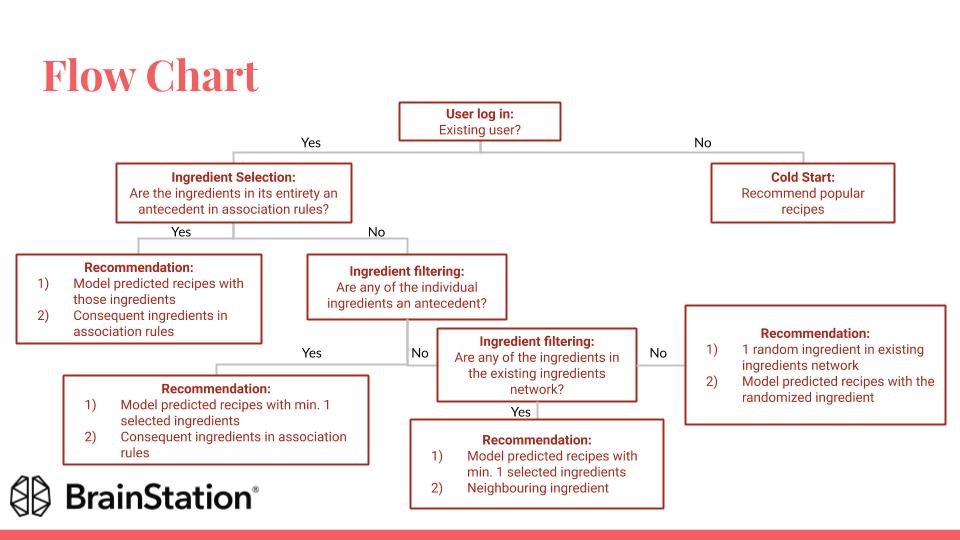

In [ ]:
%%time

# import df's needed
basket_df = pd.read_csv('market_baskets.csv', index_col='recipe_id')
rules = pd.read_csv('association_rules.csv')
recommender_v2 = pd.read_csv('recommender_v1.csv')
G = nx.read_gml('ingredients.gml')

In [ ]:
# function to sort ingredients inputted by user
def sort_ingredients(ingredients):
    ing = ingredients.lower().split(', ')
    ing = sorted(ing)
    return ', '.join(ing)

In [ ]:
# make url clickable
def make_clickable(val):
    # target _blank to open new window
    return '<a target="_blank" href="{}">{}</a>'.format(val, val)

In [ ]:
%%time
# new reco df
new_reco_df = recommender_v2.drop(['user_id','est_rating'], axis=1)

# drop duplicates
new_reco_df.drop_duplicates(inplace=True)

# recommendations for net new users out of top 100 recipes
net_new_reco = new_reco_df.sort_values('rating', ascending=False).head(100)

In [ ]:
'''
When prompted to enter a user ID for testing, a confirmed user ID is 350583 
Enter a random set of numbers to populate the cold start recommendations
'''


# columns to display
new_reco_cols = ['recipe_name', 'url','category', 'sub_category', 'rating', 'rating_counts', 'servings',\
                'calories', 'fat_g', 'cholesterol_mg', 'carbs_g', 'sodium_mg', 'protein_g']

# recommendations for net new users
net_new_reco_2 = net_new_reco.drop_duplicates().sample(3, weights='rating_counts', replace=False).\
                reset_index(drop=True)[new_reco_cols]

# make links clickable
net_new_reco_3 = net_new_reco_2.style.format({'url': make_clickable})

# get user id
while True:
    try:
        user_id = int(input('\033[1m' + 'Please log in with your user ID: '))
        if user_id in list(recommender_v2['user_id']):
            print('\033[1m' + '\nWelcome back to DONO!')
        else:
            print('\033[1m' + '\nThank you for signing up to DONO, where our goal here is to help simplify your life.')
            print('To start, below are some recipes we think you would really enjoy:')
            display(net_new_reco_3)
    except ValueError:
        print('\033[1m' + 'Sorry, that does not seem to be a valid user ID. Please Try again.')
        continue
    else: 
        break
        
# filter recommender first to speed up output in next cell
recommender_v3 = recommender_v2[recommender_v2['user_id'] == user_id]

In [ ]:
'''
When prompted, add any number of comma delimited ingredients (not case-sensitive)
'''

# take user input
xyz = input('\033[1m' + 'What ingredients would you like to add to your shopping cart?\
            \n(Please separate ingredients with a comma.) \n')


# original ingredients input as list
xyz_split = xyz.lower().split(', ')

# sort ingredients input to match association rules
ingredients = sort_ingredients(xyz)

# setting variable for nested while loop
index_num = 0

# list of nodes in network
nodes_list = list(nx.nodes(G))

# empty list
ingredient_list = []

# check if ingredients in list of ingredients are part of existing ingredient columns
for ingredient in xyz_split:
    # if ingredient is in existing recipe ingredients, append to list
    if ingredient in basket_df.columns:
        ingredient_list.append(ingredient)
    else:
        pass

if len(ingredient_list) > 0: 
    # calculate how many of ingredients in list of ingredients does recipe include and sort aggregate from highest to lowest
    ingredient_df = pd.DataFrame(basket_df[basket_df[ingredient_list].values == 1][ingredient_list].sum(axis=1).\
                                 sort_values(ascending=False), columns=['total']).reset_index()

    # drop duplicates, if any
    ingredient_df.drop_duplicates(inplace=True)

    # merge recipes that include user selected ingredients to corresponding recipe information 
    recipe_reco = pd.merge(ingredient_df, recommender_v3, how='left', on='recipe_id')

    # filter merged df to user ID 
    recipe_reco = recipe_reco[recipe_reco['user_id'] == user_id].sort_values('est_rating', ascending=False)
    
    # if there are less than recipes that use the max number of ingredients
    if len(recipe_reco[recipe_reco['total'] == recipe_reco['total'].max()]) < 3:
        recipe_reco = recipe_reco.head(10).sample(3, weights='est_rating').reset_index(drop=True)
    
    else: 
        # get recipes that use the most number of ingredients in list of user selected ingredients
        recipe_reco = recipe_reco[recipe_reco['total'] == recipe_reco['total'].max()]

        # recommend random 3 recipes weighted by predicted ratings
        recipe_reco = recipe_reco.sample(3, weights='est_rating').reset_index(drop=True)

    # recommendations with reduced columns
    reco_columns = ['recipe_name', 'est_rating', 'url','category', 'sub_category', 'rating', 'rating_counts', 'servings',\
                    'calories', 'fat_g', 'cholesterol_mg', 'carbs_g', 'sodium_mg', 'protein_g']

    recipe_reco = recipe_reco[reco_columns]

    # make links clickable
    recipe_reco = recipe_reco.style.format({'url': make_clickable})

else: 
    pass

# check if ingredients inputted matches antecedents in association rules
if (rules['antecedents'] == ingredients).sum() > 0:
    # random consequent output weighted by lift metric
    print('\033[1m' + f'\n{xyz} have been added to your shopping cart.\nBased on the item(s) you have chosen, we think you may enjoy these recipes:')
    # make recipe recommendation
    display(recipe_reco)
    print('\033[1m' + f'\nWe think you would enjoy the following item(s) as well:')
    # make ingredient recommendation
    item_reco = rules[rules['antecedents'] == ingredients].sample(1, weights='lift')['consequents']
    display(item_reco)

else:
    # random ingredient from list of input ingredients
    while index_num < len(xyz.split(', ')):
        # check if individual ingredient is part of association rules or if we have exhausted all ingredients in 
        # the list, if so then break out of loop
        if (rules['antecedents'] == xyz_split[index_num]).sum() > 0 or index_num == (len(xyz_split) - 1):
            break
        else:
            # if ingredient not part of association rules then check next ingredient in list 
            index_num += 1
    
    if (rules['antecedents'] == xyz_split[index_num]).sum() > 0: 
        # random consequent output weighted by lift
        print('\033[1m' + f'\n{xyz} have been added to your shopping cart. \nBased on the item(s) you have chosen, we think you may enjoy these recipes:')
        # make recipe recommendation
        display(recipe_reco)
        # make ingredient recommendation
        item_reco = rules[rules['antecedents'] == xyz_split[index_num]].sample(1, weights='lift')['consequents']
        print('\033[1m' + f'\nWe think you would enjoy the following item(s) as well:')
        display(item_reco)
    else: 
        for i in range(len(xyz_split)):
            if xyz_split[i] in nodes_list:
                # create df of neighbours to sample ingredient, yeast
                neighbours_df = pd.DataFrame(list(G.neighbors(xyz_split[i])), columns=['neighbours'])

                # create column with respective weights
                neighbours_df['weight'] = neighbours_df['neighbours'].apply(lambda x: G.get_edge_data(xyz_split[i], x)['weight'])

                # sort df in descending order by weight
                neighbours_df.sort_values('weight', ascending=False, inplace=True)

                # reset index
                neighbours_df.reset_index(drop=True, inplace=True)
                
                # make recipe recommendation
                print('\033[1m' + f'\n{xyz} have been added to your shopping cart. \nBased on the item(s) you have chosen, we think you may enjoy these recipes:')
                display(recipe_reco)

                # make ingredient recommendation
                # reco based off of random proportioned by weight
                print('\033[1m' + f'\nWe think you would enjoy the following item(s) as well:')
                display(neighbours_df.sample(1, weights='weight').loc[:,'neighbours'])

                break

            else:
                # if all the ingredients fail every step, then a random ingredient will be suggested
                item_backup = random.choice(nodes_list)

                # find recipes that have the random suggested ingredient
                ingredient_df = basket_df[basket_df[item_backup] == 1][item_backup].reset_index()

                # drop duplicates, if any
                ingredient_df.drop_duplicates(inplace=True)

                # merge recipes that include user selected ingredients to corresponding recipe information 
                recipe_reco = pd.merge(ingredient_df, recommender_v3, how='left', on='recipe_id')

                # filter merged df to user ID 
                recipe_reco = recipe_reco[recipe_reco['user_id'] == user_id].sort_values('est_rating', ascending=False)

                # if recipe_reco is less than 3 recipes
                if len(recipe_reco) < 3: 
                    recipe_reco = recipe_reco
                
                else:
                    # recommend random 3 recipes weighted by predicted ratings
                    recipe_reco = recipe_reco.sample(3, weights='est_rating').reset_index(drop=True)

                # recommendations with reduced columns
                recipe_reco = recipe_reco[reco_columns]
                
                # make links clickable
                recipe_reco = recipe_reco.style.format({'url': make_clickable})
                
                print('\033[1m' + f'\n{xyz} have been added to your shopping cart.')
                
                # random ingredient recommendation
                print('\033[1m' + f'\nWe think you would enjoy the following item(s) as well:')
                display(item_backup)
                
                # recipe recommendation
                print('\033[1m' + f'\nWith the suggested item, you can make great recipes like:')
                display(recipe_reco)

